# 📋 INSTRUCCIONES DE CONFIGURACIÓN

Este notebook ahora funciona en tu entorno local de VS Code y lee archivos **directamente desde Google Drive en la nube** (no requiere sincronización local).

## 🔧 Configuración Inicial (Primera vez)

### 🔷 OPCIÓN 1: Service Account (Recomendado para automación)

**Ventajas:** No requiere intervención del usuario, ideal para scripts automatizados, más seguro.

1. Ve a [Google Cloud Console](https://console.cloud.google.com/)
2. Crea un proyecto nuevo o selecciona uno existente
3. Habilita la **Google Drive API**:
   - Menú lateral > "APIs y servicios" > "Biblioteca"
   - Busca "Google Drive API" y haz clic en "Habilitar"
4. Crear Service Account:
   - Ve a "IAM y administración" > "Cuentas de servicio"
   - Clic en "+ CREAR CUENTA DE SERVICIO"
   - Dale un nombre (ej: "notebook-drive-access")
   - Haz clic en "Crear y continuar"
   - Rol: "Editor" (o permisos específicos de Drive)
   - Haz clic en "Continuar" y "Listo"
5. Descargar clave:
   - Haz clic en la cuenta de servicio creada
   - Pestaña "Claves" > "Agregar clave" > "Crear clave nueva"
   - Tipo: JSON
   - Descarga el archivo
6. **Importante**: Guarda el archivo JSON descargado como:
   - `sheets-service-account.json` o `target-credentials.json`
   - En la misma carpeta donde está este notebook
7. **Muy Importante**: Comparte tu carpeta `SHAPES_INFRAESTRUCTURA` en Google Drive con:
   - El email de la service account (aparece en el JSON, termina en `@...gserviceaccount.com`)
   - Dale permisos de "Editor"

### 🔷 OPCIÓN 2: OAuth 2.0 (Para uso personal/interactivo)

**Ventajas:** Usa tu cuenta personal de Google, más fácil de configurar inicialmente.

1. Ve a [Google Cloud Console](https://console.cloud.google.com/)
2. Crea un proyecto nuevo o selecciona uno existente
3. Habilita la **Google Drive API** (igual que arriba)
4. Crear credenciales OAuth:
   - Ve a "APIs y servicios" > "Credenciales"
   - Clic en "+ CREAR CREDENCIALES" > "ID de cliente de OAuth"
   - Si es primera vez, configura la pantalla de consentimiento:
     - Tipo: "Externo" (si no tienes Google Workspace)
     - Llena información básica
     - En "Scopes", no agregues nada extra por ahora
     - Usuarios de prueba: agrega tu email
   - Tipo de aplicación: "Aplicación de escritorio"
   - Dale un nombre (ej: "Notebook Infraestructura")
   - Descarga el archivo JSON de credenciales
5. **Importante**: Guarda el archivo JSON descargado como:
   - `credentials.json` o `client_secrets.json`
   - En la misma carpeta donde está este notebook

### 2️⃣ Primera ejecución

1. Ejecuta la segunda celda (Configuración Google Drive API)
2. **Si usas OAuth2**: Se abrirá tu navegador para autenticarte
   - Inicia sesión con tu cuenta de Google
   - Acepta los permisos solicitados
   - La ventana dirá "The authentication flow has completed"
3. **Si usas Service Account**: La autenticación es automática
4. Las credenciales se guardarán para usos futuros

### 3️⃣ Verificar carpeta SHAPES_INFRAESTRUCTURA

La tercera celda buscará automáticamente la carpeta `SHAPES_INFRAESTRUCTURA` en tu Google Drive. Si no la encuentra, te mostrará todas las carpetas disponibles.

## ✅ Después de la configuración inicial

Una vez configurado, las próximas veces solo necesitarás ejecutar las celdas normalmente. El notebook:
- ✓ Leerá archivos directamente desde Google Drive
- ✓ Procesará los shapefiles y datos
- ✓ Guardará los resultados de vuelta en Google Drive
- ✓ No requiere descargar archivos manualmente

## 📁 Archivos requeridos en Google Drive

Asegúrate de tener estos archivos en la carpeta `SHAPES_INFRAESTRUCTURA`:
- `Grupo_Operativo2024_lista.shp` (+ archivos asociados .shx, .dbf, .prj, etc.)
- `Participativo_Urb2024_lista.shp` (+ archivos asociados)
- `Puntos_Estrategicos2024_lista.shp` (+ archivos asociados)
- `15-10-2025 - REPORTE INICIAL VIAS.xlsx`

## 🔍 Solución de problemas

### Error: "No se encontró archivo de credenciales"
- Verifica que el archivo JSON esté en la carpeta correcta
- El nombre del archivo debe ser exactamente: `sheets-service-account.json`, `target-credentials.json`, `credentials.json`, o `client_secrets.json`

### Error: "403 Forbidden" o "Permission denied"
- **Si usas Service Account**: Debes compartir la carpeta de Drive con el email de la service account
- **Si usas OAuth2**: Asegúrate de estar usando la cuenta correcta que tiene acceso a los archivos

### Error al cargar shapefiles
- Los shapefiles tienen múltiples archivos (.shp, .shx, .dbf, .prj)
- Asegúrate de que TODOS los archivos asociados estén en Drive
- Todos deben tener el mismo nombre base (ej: `archivo.shp`, `archivo.shx`, `archivo.dbf`)

---

**¡Ahora puedes comenzar! 🚀** Ejecuta las celdas en orden.

# **ANALISIS DE DATOS VIAS INFRAESTRUCTURA**

In [1]:
# ==========================================
# CONFIGURACIÓN PARA GOOGLE DRIVE API
# ==========================================
# Este notebook lee archivos directamente desde Google Drive en la nube

import os
import io
from pathlib import Path

# Instalar dependencias necesarias si no están instaladas
try:
    from google.oauth2 import service_account
    from google.oauth2.credentials import Credentials
    from google_auth_oauthlib.flow import InstalledAppFlow
    from google.auth.transport.requests import Request
    from googleapiclient.discovery import build
    from googleapiclient.http import MediaIoBaseDownload
    import pickle
except ImportError:
    print("📦 Instalando dependencias de Google Drive API...")
    import subprocess
    subprocess.check_call([
        'pip', 'install', '--upgrade', 
        'google-auth', 
        'google-auth-oauthlib', 
        'google-auth-httplib2', 
        'google-api-python-client'
    ])
    from google.oauth2 import service_account
    from google.oauth2.credentials import Credentials
    from google_auth_oauthlib.flow import InstalledAppFlow
    from google.auth.transport.requests import Request
    from googleapiclient.discovery import build
    from googleapiclient.http import MediaIoBaseDownload
    import pickle

# Definir los scopes necesarios (lectura y escritura para Google Drive)
SCOPES = [
    'https://www.googleapis.com/auth/drive.file',
    'https://www.googleapis.com/auth/drive'
]

def authenticate_google_drive():
    """
    Autentica con Google Drive usando Service Account o OAuth2
    Prioriza Service Account por ser más seguro y no requerir intervención del usuario
    """
    creds = None
    
    # ==========================================
    # MÉTODO 1: Service Account (Recomendado)
    # ==========================================
    service_account_paths = [
        'sheets-service-account.json',
        '../sheets-service-account.json',
        'target-credentials.json',
        '../target-credentials.json',
        os.path.join(os.path.dirname(__file__), 'sheets-service-account.json') if '__file__' in globals() else None,
    ]
    
    service_account_paths = [p for p in service_account_paths if p is not None]
    
    for sa_path in service_account_paths:
        if os.path.exists(sa_path):
            try:
                print(f"🔐 Autenticando con Service Account: {sa_path}")
                creds = service_account.Credentials.from_service_account_file(
                    sa_path, 
                    scopes=SCOPES
                )
                print("✅ Autenticación con Service Account exitosa!")
                return build('drive', 'v3', credentials=creds)
            except Exception as e:
                print(f"⚠ Error al usar Service Account {sa_path}: {str(e)}")
                print("Intentando con OAuth2...")
                creds = None
    
    # ==========================================
    # MÉTODO 2: OAuth2 (Fallback)
    # ==========================================
    token_path = 'token.pickle'
    oauth_credentials_file = None
    
    # Buscar archivo de credenciales OAuth2
    oauth_paths = [
        'credentials.json',
        'client_secrets.json',
        '../credentials.json',
        '../client_secrets.json'
    ]
    
    for oauth_path in oauth_paths:
        if os.path.exists(oauth_path):
            oauth_credentials_file = oauth_path
            break
    
    # Intentar cargar token guardado
    if os.path.exists(token_path):
        try:
            with open(token_path, 'rb') as token:
                creds = pickle.load(token)
            print("🔄 Token OAuth2 cargado desde archivo")
        except Exception as e:
            print(f"⚠ Error al cargar token: {str(e)}")
            creds = None
    
    # Verificar si las credenciales son válidas
    if creds and creds.valid:
        print("✅ Credenciales OAuth2 válidas")
        return build('drive', 'v3', credentials=creds)
    
    # Refrescar token si está expirado
    if creds and creds.expired and creds.refresh_token:
        try:
            print("🔄 Refrescando token OAuth2...")
            creds.refresh(Request())
            with open(token_path, 'wb') as token:
                pickle.dump(creds, token)
            print("✅ Token refrescado exitosamente")
            return build('drive', 'v3', credentials=creds)
        except Exception as e:
            print(f"⚠ Error al refrescar token: {str(e)}")
            creds = None
    
    # Si llegamos aquí, necesitamos crear nuevas credenciales OAuth2
    if oauth_credentials_file:
        try:
            print(f"🔐 Iniciando flujo OAuth2 con: {oauth_credentials_file}")
            print("📱 Se abrirá tu navegador para autenticarte...")
            flow = InstalledAppFlow.from_client_secrets_file(
                oauth_credentials_file, 
                SCOPES
            )
            creds = flow.run_local_server(port=0)
            
            # Guardar credenciales para la próxima ejecución
            with open(token_path, 'wb') as token:
                pickle.dump(creds, token)
            
            print("✅ Autenticación OAuth2 exitosa!")
            return build('drive', 'v3', credentials=creds)
        except Exception as e:
            print(f"❌ Error en flujo OAuth2: {str(e)}")
    
    # ==========================================
    # ERROR: No se pudo autenticar
    # ==========================================
    print("\n" + "="*70)
    print("❌ NO SE PUDO AUTENTICAR CON GOOGLE DRIVE")
    print("="*70)
    print("\n📋 SOLUCIONES DISPONIBLES:")
    print("\n🔷 OPCIÓN 1: Service Account (Recomendado para scripts)")
    print("   1. Ve a https://console.cloud.google.com/")
    print("   2. Selecciona/crea un proyecto")
    print("   3. Ve a 'IAM y administración' > 'Cuentas de servicio'")
    print("   4. Crea una cuenta de servicio")
    print("   5. Descarga la clave JSON")
    print("   6. Guárdala como 'sheets-service-account.json' en este directorio")
    print("   7. ⚠ IMPORTANTE: Comparte tu carpeta de Drive con el email de la service account")
    
    print("\n🔷 OPCIÓN 2: OAuth 2.0 (Para uso personal)")
    print("   1. Ve a https://console.cloud.google.com/")
    print("   2. Habilita la API de Google Drive")
    print("   3. Ve a 'APIs y servicios' > 'Credenciales'")
    print("   4. Crea credenciales tipo 'ID de cliente de OAuth 2.0'")
    print("   5. Tipo: 'Aplicación de escritorio'")
    print("   6. Descarga el JSON")
    print("   7. Guárdalo como 'credentials.json' en este directorio")
    
    print("\n📁 Archivos buscados:")
    print("   Service Account:")
    for p in service_account_paths:
        status = "✅" if os.path.exists(p) else "❌"
        print(f"      {status} {os.path.abspath(p)}")
    print("   OAuth2:")
    for p in oauth_paths:
        status = "✅" if os.path.exists(p) else "❌"
        print(f"      {status} {os.path.abspath(p)}")
    
    print("\n" + "="*70)
    raise FileNotFoundError("No se encontraron credenciales válidas de Google Drive")

# Ejecutar autenticación
print("="*70)
print("🚀 INICIANDO AUTENTICACIÓN CON GOOGLE DRIVE")
print("="*70)

try:
    drive_service = authenticate_google_drive()
    print("\n" + "="*70)
    print("✅ AUTENTICACIÓN COMPLETADA")
    print("="*70)
    print("📂 Ahora puedes acceder a archivos en tu Google Drive")
except Exception as e:
    print(f"\n❌ Error fatal: {str(e)}")
    raise

🚀 INICIANDO AUTENTICACIÓN CON GOOGLE DRIVE
🔐 Autenticando con Service Account: ../sheets-service-account.json
✅ Autenticación con Service Account exitosa!

✅ AUTENTICACIÓN COMPLETADA
📂 Ahora puedes acceder a archivos en tu Google Drive


In [2]:
# ==========================================
# FUNCIONES AUXILIARES PARA GOOGLE DRIVE
# ==========================================

import tempfile
import geopandas as gpd
import pandas as pd

# ID de la carpeta "SHAPES_INFRAESTRUCTURA" en Google Drive
# Extraído de: https://drive.google.com/drive/u/0/folders/1BzpTu43s5TyEOwB43fvYO4RwBfDDdX-T
SHAPES_FOLDER_ID = "1BzpTu43s5TyEOwB43fvYO4RwBfDDdX-T"

def get_folder_id_by_name(service, folder_name, parent_id=None):
    """Busca una carpeta por nombre en Google Drive"""
    query = f"name='{folder_name}' and mimeType='application/vnd.google-apps.folder' and trashed=false"
    if parent_id:
        query += f" and '{parent_id}' in parents"
    
    try:
        results = service.files().list(
            q=query,
            spaces='drive',
            fields='files(id, name)',
            pageSize=10
        ).execute()
        
        files = results.get('files', [])
        
        if not files:
            return None
        
        return files[0]['id']
    except Exception as e:
        print(f"⚠ Error al buscar carpeta: {str(e)}")
        return None

def list_files_in_folder(service, folder_id):
    """Lista todos los archivos en una carpeta de Google Drive"""
    if not folder_id:
        raise ValueError("folder_id no puede ser None o vacío")
    
    query = f"'{folder_id}' in parents and trashed=false"
    
    try:
        results = service.files().list(
            q=query,
            spaces='drive',
            fields='files(id, name, mimeType)',
            pageSize=100
        ).execute()
        
        return results.get('files', [])
    except Exception as e:
        print(f"❌ Error al listar archivos: {str(e)}")
        raise

def download_file_from_drive(service, file_id, file_name):
    """Descarga un archivo de Google Drive a un archivo temporal"""
    request = service.files().get_media(fileId=file_id)
    
    # Crear archivo temporal
    file_extension = os.path.splitext(file_name)[1]
    temp_file = tempfile.NamedTemporaryFile(delete=False, suffix=file_extension)
    
    fh = io.BytesIO()
    downloader = MediaIoBaseDownload(fh, request)
    
    done = False
    while not done:
        status, done = downloader.next_chunk()
        if status:
            print(f"  Descargando {file_name}: {int(status.progress() * 100)}%")
    
    # Escribir al archivo temporal
    with open(temp_file.name, 'wb') as f:
        f.write(fh.getvalue())
    
    return temp_file.name

def load_shapefile_from_drive(service, folder_id, shapefile_name):
    """
    Carga un shapefile desde Google Drive
    Descarga todos los archivos asociados (.shp, .shx, .dbf, etc.)
    """
    if not folder_id:
        raise ValueError("❌ folder_id no puede ser None. Verifica que SHAPES_FOLDER_ID esté configurado correctamente.")
    
    # Buscar todos los archivos del shapefile
    base_name = os.path.splitext(shapefile_name)[0]
    
    files = list_files_in_folder(service, folder_id)
    shapefile_files = [f for f in files if f['name'].startswith(base_name)]
    
    if not shapefile_files:
        raise FileNotFoundError(f"No se encontró el shapefile {shapefile_name} en Google Drive")
    
    # Crear directorio temporal para los archivos del shapefile
    temp_dir = tempfile.mkdtemp()
    
    print(f"\n📦 Descargando shapefile: {shapefile_name}")
    print(f"   Archivos encontrados: {len(shapefile_files)}")
    
    # Descargar todos los archivos asociados
    for file in shapefile_files:
        temp_path = os.path.join(temp_dir, file['name'])
        request = service.files().get_media(fileId=file['id'])
        
        with open(temp_path, 'wb') as f:
            downloader = MediaIoBaseDownload(f, request)
            done = False
            while not done:
                status, done = downloader.next_chunk()
        
        print(f"   ✓ {file['name']}")
    
    # Cargar el shapefile con geopandas
    shp_path = os.path.join(temp_dir, shapefile_name)
    gdf = gpd.read_file(shp_path)
    
    print(f"✅ Shapefile cargado: {gdf.shape[0]} registros")
    
    return gdf

def load_excel_from_drive(service, folder_id, excel_name):
    """Carga un archivo Excel desde Google Drive"""
    if not folder_id:
        raise ValueError("❌ folder_id no puede ser None. Verifica que SHAPES_FOLDER_ID esté configurado correctamente.")
    
    files = list_files_in_folder(service, folder_id)
    excel_file = next((f for f in files if f['name'] == excel_name), None)
    
    if not excel_file:
        raise FileNotFoundError(f"No se encontró el archivo {excel_name} en Google Drive")
    
    print(f"\n📥 Descargando archivo Excel: {excel_name}")
    temp_path = download_file_from_drive(service, excel_file['id'], excel_name)
    
    df = pd.read_excel(temp_path)
    print(f"✅ Excel cargado: {df.shape[0]} registros")
    
    # Limpiar archivo temporal
    os.unlink(temp_path)
    
    return df

# Verificar el ID de la carpeta y listar archivos
print("\n" + "="*70)
print("📂 VERIFICANDO ACCESO A CARPETA DE GOOGLE DRIVE")
print("="*70)

if SHAPES_FOLDER_ID:
    print(f"✓ ID de carpeta configurado: {SHAPES_FOLDER_ID}")
    print(f"✓ URL: https://drive.google.com/drive/folders/{SHAPES_FOLDER_ID}")
    
    try:
        # Listar archivos en la carpeta
        files = list_files_in_folder(drive_service, SHAPES_FOLDER_ID)
        print(f"\n✓ Acceso exitoso a la carpeta")
        print(f"✓ Archivos encontrados: {len(files)}")
        
        if files:
            print(f"\n📁 Primeros 20 archivos:")
            for file in files[:20]:
                print(f"   - {file['name']}")
            
            if len(files) > 20:
                print(f"   ... y {len(files) - 20} archivos más")
        else:
            print("\n⚠ La carpeta está vacía o no tienes permisos de lectura")
            print("   Asegúrate de que:")
            print("   1. La carpeta contenga los archivos necesarios")
            print("   2. Has compartido la carpeta con la service account")
            print("      (si usas service account)")
    
    except Exception as e:
        print(f"\n❌ Error al acceder a la carpeta: {str(e)}")
        print("\n🔧 Soluciones posibles:")
        print("   1. Verifica que hayas compartido la carpeta con:")
        print("      - Tu cuenta de Google (si usas OAuth2)")
        print("      - El email de la service account (si usas service account)")
        print("   2. La carpeta debe tener permisos de 'Lector' o 'Editor'")
        print("   3. Verifica que el ID de la carpeta sea correcto")
else:
    print("❌ SHAPES_FOLDER_ID no está configurado")

print("\n" + "="*70)
print("✅ Configuración completada. Puedes continuar con el análisis.")
print("="*70)


📂 VERIFICANDO ACCESO A CARPETA DE GOOGLE DRIVE
✓ ID de carpeta configurado: 1BzpTu43s5TyEOwB43fvYO4RwBfDDdX-T
✓ URL: https://drive.google.com/drive/folders/1BzpTu43s5TyEOwB43fvYO4RwBfDDdX-T

✓ Acceso exitoso a la carpeta
✓ Archivos encontrados: 20

📁 Primeros 20 archivos:
   - unidades_proyecto.geojson
   - Puntos_Estrategicos2024_lista.prj
   - Puntos_Estrategicos2024_lista.qmd
   - Puntos_Estrategicos2024_lista.shx
   - Puntos_Estrategicos2024_lista.cpg
   - Puntos_Estrategicos2024_lista.dbf
   - Puntos_Estrategicos2024_lista.shp
   - Participativo_Urb2024_lista.cpg
   - Participativo_Urb2024_lista.prj
   - Participativo_Urb2024_lista.dbf
   - Participativo_Urb2024_lista.shx
   - Participativo_Urb2024_lista.shp
   - Participativo_Urb2024_lista.qmd
   - Grupo_Operativo2024_lista.prj
   - Grupo_Operativo2024_lista.cpg
   - Grupo_Operativo2024_lista.shp
   - Grupo_Operativo2024_lista.qmd
   - Grupo_Operativo2024_lista.dbf
   - Grupo_Operativo2024_lista.shx
   - 15-10-2025 - REPORTE INI

## **GRUPO OPERATIVO 2024**

In [3]:
from IPython.display import display

# Cargar el shapefile desde Google Drive
print("="*60)
print("CARGANDO: Grupo Operativo 2024")
print("="*60)

gdf = load_shapefile_from_drive(
    drive_service, 
    SHAPES_FOLDER_ID, 
    "Grupo_Operativo2024_lista.shp"
)

# Mostrar información del geodataframe
print(f"\nShape del geodataframe: {gdf.shape}")
print(f"\nColumnas disponibles:\n{gdf.columns.tolist()}")
print(f"\nTipos de datos:")
print(gdf.dtypes)

# Mostrar la tabla de atributos de forma interactiva
print(f"\n{'='*80}")
print("TABLA DE ATRIBUTOS COMPLETA:")
print(f"{'='*80}\n")
display(gdf)

CARGANDO: Grupo Operativo 2024

📦 Descargando shapefile: Grupo_Operativo2024_lista.shp
   Archivos encontrados: 6
   ✓ Grupo_Operativo2024_lista.prj
   ✓ Grupo_Operativo2024_lista.cpg
   ✓ Grupo_Operativo2024_lista.shp
   ✓ Grupo_Operativo2024_lista.qmd
   ✓ Grupo_Operativo2024_lista.dbf
   ✓ Grupo_Operativo2024_lista.shx
✅ Shapefile cargado: 239 registros

Shape del geodataframe: (239, 41)

Columnas disponibles:
['Name', 'PopupInfo', 'COM_CORRG', 'TIPO_INTER', 'Long_inter', 'JERARQUIZA', 'ID', 'X_INICIAL', 'Y_INICIAL', 'X_FINAL', 'Y_FINAL', 'Id_1', 'FID_1', 'Dirección', 'Barrio', 'Comuna', 'Tipo_Infra', 'Tipo_Int_1', 'Tipo_Mezcl', 'Tipo_Grupo', 'Longitud', 'Año', 'X_INICIA_1', 'Y_INICIA_1', 'X_FINAL_1', 'Y_FINAL_1', 'F__AVANCE', 'ESTADO', 'BP', 'Nompre_BP', 'BPIN', 'VALOR_INTE', 'id_barrio', 'barrio_2', 'comuna_2', 'estra_moda', 'area', 'perimetro', 'Shape_Leng', 'Shape_Area', 'geometry']

Tipos de datos:
Name            object
PopupInfo       object
COM_CORRG       object
TIPO_INTER 

,Name,PopupInfo,COM_CORRG,TIPO_INTER,Long_inter,JERARQUIZA,ID,X_INICIAL,Y_INICIAL,X_FINAL,...,VALOR_INTE,id_barrio,barrio_2,comuna_2,estra_moda,area,perimetro,Shape_Leng,Shape_Area,geometry
0,1,CALLE 44 BIS ENTRE CARRERAS 6 Y 7,COMUNA 4,RECARPETEO VIAL,121,VIA LOCAL,1.0,-76.506483,3.459911,-76.506156,...,"$ 91.233.179,26",0416,La Esmeralda,04,2.0,233761.927,2539.549,2539.548928,233761.894596,"LINESTRING Z (-76.50648 3.45991 0, -76.50647 3..."
1,2,CARRERA 7A BIS ENTRE CALLES 82 Y 84,COMUNA 7,RECARPETEO VIAL,147,VIA LOCAL,2.0,-76.479275,3.466028,-76.477944,...,"$ 110.837.002,90",0701,Alfonso Lopez I,07,3.0,586055.243,3307.810,3307.809007,586055.233057,"LINESTRING Z (-76.47927 3.46603 0, -76.47794 3..."
2,4,CALLE 38 ENTRE CARRERAS 5 Y 7,COMUNA 4,RECARPETEO VIAL,128,VIA LOCAL,4.0,-76.516669,3.469494,-76.515847,...,"$ 96.511.131,78",0413,La Isla,04,2.0,147751.139,2947.977,2947.977316,147751.129447,"LINESTRING Z (-76.51667 3.46949 0, -76.51657 3..."
3,4,CALLE 38 ENTRE CARRERAS 5 Y 7,COMUNA 4,RECARPETEO VIAL,128,VIA LOCAL,4.0,-76.516669,3.469494,-76.515847,...,"$ 96.511.131,78",0419,Unidad Residencial Bueno Madrid,04,3.0,52526.673,1087.241,1087.241495,52526.671099,"LINESTRING Z (-76.51657 3.46938 0, -76.51585 3..."
4,5,CARRERA 41 ENTRE CALLES 41C Y 42,COMUNA 16,RECARPETEO VIAL,91,VIA LOCAL,5.0,-76.508023,3.413809,-76.507405,...,"$ 68.613.382,75",1604,Antonio Nariño,16,2.0,780338.292,3962.553,3962.552813,780338.283931,"LINESTRING Z (-76.50802 3.41381 0, -76.5074 3...."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
234,33,CALLE 5TA ENTRE CARRERA 72 Y 80 (CICLOINFRAEST...,COMUNA 17,CICLOINFRAESTRUCTURA,120,CICLOINFRAESTRUCTURA,33.0,-76.544481,3.386077,-76.545630,...,None,1790,El Gran Limonar,17,5.0,315229.376,2840.733,2840.733420,315229.400664,"MULTILINESTRING Z ((-76.54511 3.39077 0, -76.5..."
235,33,CALLE 5TA ENTRE CARRERA 72 Y 80 (CICLOINFRAEST...,COMUNA 17,CICLOINFRAESTRUCTURA,120,CICLOINFRAESTRUCTURA,33.0,-76.544481,3.386077,-76.545630,...,None,1801,Buenos Aires,18,3.0,209696.378,2227.034,2227.034686,209696.373460,"LINESTRING Z (-76.54555 3.39233 0, -76.54558 3..."
236,33,CALLE 5TA ENTRE CARRERA 72 Y 80 (CICLOINFRAEST...,COMUNA 17,CICLOINFRAESTRUCTURA,120,CICLOINFRAESTRUCTURA,33.0,-76.544481,3.386077,-76.545630,...,None,1783,Ciudad Capri,17,5.0,478792.261,2715.763,2715.762854,478792.240817,"LINESTRING Z (-76.54448 3.38608 0, -76.54488 3..."
237,177,Carrera 43B entre Calles 44 y 46,COMUNA 16,VIA LOCAL,231,MEZCLA CALIENTE,177.0,-76.510612,3.404517,-76.511951,...,None,1602,República de Israel,16,2.0,571918.896,3336.738,3336.737530,571918.929237,"LINESTRING Z (-76.51061 3.40452 0, -76.51195 3..."


### **Eliminación de Columnas Innecesarias**



In [4]:
# Eliminar las columnas especificadas
columns_to_drop = [
    "X_INICIAL", "Y_INICIAL", "X_FINAL", "Y_FINAL",
    "X_INICIA_1", "Y_INICIA_1", "X_FINAL_1", "Y_FINAL_1",
    "id_barrio", "area", "perimetro", "Shape_Leng", "Shape_Area", "COM_CORRG",
    "estra_moda", "ID", "Longitud", "Barrio", "Id_1", "TIPO_INTER",
    "comuna_2", "Name", "Tipo_Mezcl", "Nompre_BP", "JERARQUIZA",
]
gdf = gdf.drop(columns=columns_to_drop)

# Mostrar las columnas restantes para verificar
print("\nColumnas restantes después de eliminar:")
print(gdf.columns.tolist())


Columnas restantes después de eliminar:
['PopupInfo', 'Long_inter', 'FID_1', 'Dirección', 'Comuna', 'Tipo_Infra', 'Tipo_Int_1', 'Tipo_Grupo', 'Año', 'F__AVANCE', 'ESTADO', 'BP', 'BPIN', 'VALOR_INTE', 'barrio_2', 'geometry']


In [5]:
gdf

,PopupInfo,Long_inter,FID_1,Dirección,Comuna,Tipo_Infra,Tipo_Int_1,Tipo_Grupo,Año,F__AVANCE,ESTADO,BP,BPIN,VALOR_INTE,barrio_2,geometry
0,CALLE 44 BIS ENTRE CARRERAS 6 Y 7,121,0,CALLE 44 BIS ENTRE CARRERAS 6 Y 7,COMUNA 4,VIA LOCAL,RECARPETEO,GRUPO OPERATIVO,2024,"100,00%",FINALIZADO,BP26004834,2.023760e+12,"$ 91.233.179,26",La Esmeralda,"LINESTRING Z (-76.50648 3.45991 0, -76.50647 3..."
1,CARRERA 7A BIS ENTRE CALLES 82 Y 84,147,1,CARRERA 7A BIS ENTRE CALLES 82 Y 84,COMUNA 7,VIA LOCAL,RECARPETEO,GRUPO OPERATIVO,2024,"100,00%",FINALIZADO,BP26004834,2.023760e+12,"$ 110.837.002,90",Alfonso Lopez I,"LINESTRING Z (-76.47927 3.46603 0, -76.47794 3..."
2,CALLE 38 ENTRE CARRERAS 5 Y 7,128,2,CALLE 38N ENTRE CARRERAS 5N Y 7N,COMUNA 4,VIA LOCAL,RECARPETEO,GRUPO OPERATIVO,2024,"100,00%",FINALIZADO,BP26004834,2.023760e+12,"$ 96.511.131,78",La Isla,"LINESTRING Z (-76.51667 3.46949 0, -76.51657 3..."
3,CALLE 38 ENTRE CARRERAS 5 Y 7,128,2,CALLE 38N ENTRE CARRERAS 5N Y 7N,COMUNA 4,VIA LOCAL,RECARPETEO,GRUPO OPERATIVO,2024,"100,00%",FINALIZADO,BP26004834,2.023760e+12,"$ 96.511.131,78",Unidad Residencial Bueno Madrid,"LINESTRING Z (-76.51657 3.46938 0, -76.51585 3..."
4,CARRERA 41 ENTRE CALLES 41C Y 42,91,3,CARRERA 41 ENTRE CALLES 41C Y 42,COMUNA 16,VIA LOCAL,RECARPETEO,GRUPO OPERATIVO,2024,"100,00%",FINALIZADO,BP26004239,2.022760e+12,"$ 68.613.382,75",Antonio Nariño,"LINESTRING Z (-76.50802 3.41381 0, -76.5074 3...."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
234,CALLE 5TA ENTRE CARRERA 72 Y 80 (CICLOINFRAEST...,120,0,None,None,None,None,None,0,None,None,None,0.000000e+00,None,El Gran Limonar,"MULTILINESTRING Z ((-76.54511 3.39077 0, -76.5..."
235,CALLE 5TA ENTRE CARRERA 72 Y 80 (CICLOINFRAEST...,120,0,None,None,None,None,None,0,None,None,None,0.000000e+00,None,Buenos Aires,"LINESTRING Z (-76.54555 3.39233 0, -76.54558 3..."
236,CALLE 5TA ENTRE CARRERA 72 Y 80 (CICLOINFRAEST...,120,0,None,None,None,None,None,0,None,None,None,0.000000e+00,None,Ciudad Capri,"LINESTRING Z (-76.54448 3.38608 0, -76.54488 3..."
237,Carrera 43B entre Calles 44 y 46,231,0,None,None,None,None,None,0,None,None,None,0.000000e+00,None,República de Israel,"LINESTRING Z (-76.51061 3.40452 0, -76.51195 3..."


### **Evitar notación científica en la variable "BPIN"**

In [6]:
import pandas as pd

# Establecer opciones de visualización para evitar la notación científica
pd.options.display.float_format = '{:.0f}'.format

# Mostrar el geodataframe nuevamente para ver el cambio
display(gdf)

,PopupInfo,Long_inter,FID_1,Dirección,Comuna,Tipo_Infra,Tipo_Int_1,Tipo_Grupo,Año,F__AVANCE,ESTADO,BP,BPIN,VALOR_INTE,barrio_2,geometry
0,CALLE 44 BIS ENTRE CARRERAS 6 Y 7,121,0,CALLE 44 BIS ENTRE CARRERAS 6 Y 7,COMUNA 4,VIA LOCAL,RECARPETEO,GRUPO OPERATIVO,2024,"100,00%",FINALIZADO,BP26004834,2023760010180,"$ 91.233.179,26",La Esmeralda,"LINESTRING Z (-76.50648 3.45991 0, -76.50647 3..."
1,CARRERA 7A BIS ENTRE CALLES 82 Y 84,147,1,CARRERA 7A BIS ENTRE CALLES 82 Y 84,COMUNA 7,VIA LOCAL,RECARPETEO,GRUPO OPERATIVO,2024,"100,00%",FINALIZADO,BP26004834,2023760010180,"$ 110.837.002,90",Alfonso Lopez I,"LINESTRING Z (-76.47927 3.46603 0, -76.47794 3..."
2,CALLE 38 ENTRE CARRERAS 5 Y 7,128,2,CALLE 38N ENTRE CARRERAS 5N Y 7N,COMUNA 4,VIA LOCAL,RECARPETEO,GRUPO OPERATIVO,2024,"100,00%",FINALIZADO,BP26004834,2023760010180,"$ 96.511.131,78",La Isla,"LINESTRING Z (-76.51667 3.46949 0, -76.51657 3..."
3,CALLE 38 ENTRE CARRERAS 5 Y 7,128,2,CALLE 38N ENTRE CARRERAS 5N Y 7N,COMUNA 4,VIA LOCAL,RECARPETEO,GRUPO OPERATIVO,2024,"100,00%",FINALIZADO,BP26004834,2023760010180,"$ 96.511.131,78",Unidad Residencial Bueno Madrid,"LINESTRING Z (-76.51657 3.46938 0, -76.51585 3..."
4,CARRERA 41 ENTRE CALLES 41C Y 42,91,3,CARRERA 41 ENTRE CALLES 41C Y 42,COMUNA 16,VIA LOCAL,RECARPETEO,GRUPO OPERATIVO,2024,"100,00%",FINALIZADO,BP26004239,2022760010010,"$ 68.613.382,75",Antonio Nariño,"LINESTRING Z (-76.50802 3.41381 0, -76.5074 3...."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
234,CALLE 5TA ENTRE CARRERA 72 Y 80 (CICLOINFRAEST...,120,0,None,None,None,None,None,0,None,None,None,0,None,El Gran Limonar,"MULTILINESTRING Z ((-76.54511 3.39077 0, -76.5..."
235,CALLE 5TA ENTRE CARRERA 72 Y 80 (CICLOINFRAEST...,120,0,None,None,None,None,None,0,None,None,None,0,None,Buenos Aires,"LINESTRING Z (-76.54555 3.39233 0, -76.54558 3..."
236,CALLE 5TA ENTRE CARRERA 72 Y 80 (CICLOINFRAEST...,120,0,None,None,None,None,None,0,None,None,None,0,None,Ciudad Capri,"LINESTRING Z (-76.54448 3.38608 0, -76.54488 3..."
237,Carrera 43B entre Calles 44 y 46,231,0,None,None,None,None,None,0,None,None,None,0,None,República de Israel,"LINESTRING Z (-76.51061 3.40452 0, -76.51195 3..."


In [7]:
gdf.shape

(239, 16)

### **Eliminación de valores nulos en las filas donde "geometry" es null**

In [8]:
# Eliminar las últimas 5 filas del geodataframe
gdf = gdf[:-5]

# Mostrar la nueva cantidad de filas para verificar
print(f"Cantidad de filas después de eliminar las últimas 5: {len(gdf)}")

# Opcional: mostrar las últimas filas para confirmar que fueron eliminadas
display(gdf)

Cantidad de filas después de eliminar las últimas 5: 234


,PopupInfo,Long_inter,FID_1,Dirección,Comuna,Tipo_Infra,Tipo_Int_1,Tipo_Grupo,Año,F__AVANCE,ESTADO,BP,BPIN,VALOR_INTE,barrio_2,geometry
0,CALLE 44 BIS ENTRE CARRERAS 6 Y 7,121,0,CALLE 44 BIS ENTRE CARRERAS 6 Y 7,COMUNA 4,VIA LOCAL,RECARPETEO,GRUPO OPERATIVO,2024,"100,00%",FINALIZADO,BP26004834,2023760010180,"$ 91.233.179,26",La Esmeralda,"LINESTRING Z (-76.50648 3.45991 0, -76.50647 3..."
1,CARRERA 7A BIS ENTRE CALLES 82 Y 84,147,1,CARRERA 7A BIS ENTRE CALLES 82 Y 84,COMUNA 7,VIA LOCAL,RECARPETEO,GRUPO OPERATIVO,2024,"100,00%",FINALIZADO,BP26004834,2023760010180,"$ 110.837.002,90",Alfonso Lopez I,"LINESTRING Z (-76.47927 3.46603 0, -76.47794 3..."
2,CALLE 38 ENTRE CARRERAS 5 Y 7,128,2,CALLE 38N ENTRE CARRERAS 5N Y 7N,COMUNA 4,VIA LOCAL,RECARPETEO,GRUPO OPERATIVO,2024,"100,00%",FINALIZADO,BP26004834,2023760010180,"$ 96.511.131,78",La Isla,"LINESTRING Z (-76.51667 3.46949 0, -76.51657 3..."
3,CALLE 38 ENTRE CARRERAS 5 Y 7,128,2,CALLE 38N ENTRE CARRERAS 5N Y 7N,COMUNA 4,VIA LOCAL,RECARPETEO,GRUPO OPERATIVO,2024,"100,00%",FINALIZADO,BP26004834,2023760010180,"$ 96.511.131,78",Unidad Residencial Bueno Madrid,"LINESTRING Z (-76.51657 3.46938 0, -76.51585 3..."
4,CARRERA 41 ENTRE CALLES 41C Y 42,91,3,CARRERA 41 ENTRE CALLES 41C Y 42,COMUNA 16,VIA LOCAL,RECARPETEO,GRUPO OPERATIVO,2024,"100,00%",FINALIZADO,BP26004239,2022760010010,"$ 68.613.382,75",Antonio Nariño,"LINESTRING Z (-76.50802 3.41381 0, -76.5074 3...."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
229,CARRERA 1C CON CALLE 71,67,215,CARRERA 1C CON CALLE 71,COMUNA 6,VIA LOCAL,BACHEO,GRUPO OPERATIVO,2024,"100,00%",FINALIZADO,BP26004834,2023760010180,"$ 23.863.264,05",San Luis,"LINESTRING Z (-76.48678 3.4782 0, -76.48649 3...."
230,CALLE 126 ENTRE CARRERAS 28F y 28G,105,216,CALLE 126 ENTRE CARRERAS 28F Y 28G,COMUNA 21,VIA LOCAL,RECARPETEO,GRUPO OPERATIVO,2024,"100,00%",FINALIZADO,BP26004834,2023760010180,"$ 79.169.287,79",Pizamos II,"LINESTRING Z (-76.46793 3.4008 0, -76.46786 3...."
231,CALLE 7 OESTE CON CARRERA 2,21,217,CALLE 7 OESTE CON CARRERA 2,COMUNA 2,VIA LOCAL,BACHEO,GRUPO OPERATIVO,2024,"100,00%",FINALIZADO,BP26004834,2023760010180,"$ 7.350.737,59",Arboledas,"LINESTRING Z (-76.5476 3.45008 0, -76.54773 3...."
232,CARRERA 36A ENTRE CALLES 27 y 29,210,218,CARRERA 36A ENTRE CALLES 27 Y 29,COMUNA 11,VIA LOCAL,RECARPETEO,GRUPO OPERATIVO,2024,"100,00%",FINALIZADO,BP26004834,2023760010180,"$ 158.338.575,57",El Jardín,"LINESTRING Z (-76.51727 3.42066 0, -76.51694 3..."


In [9]:
gdf.columns

Index(['PopupInfo', 'Long_inter', 'FID_1', 'Dirección', 'Comuna', 'Tipo_Infra',
       'Tipo_Int_1', 'Tipo_Grupo', 'Año', 'F__AVANCE', 'ESTADO', 'BP', 'BPIN',
       'VALOR_INTE', 'barrio_2', 'geometry'],
      dtype='object')

### **Renombrado de columnas**

In [10]:
cols_new_names={
    "PopupInfo":"nombre_up",
    "Long_inter": "cantidad",
    "Dirección": "direccion",
    "Comuna": "comuna_corregimiento",
    "barrio_2": "barrio_vereda",
    "Tipo_Int_1": "tipo_intervencion",
    "ESTADO": "estado",
    "BP": "bp",
    "BPIN":"bpin",
    "VALOR_INTE": "presupuesto_base",
    "Año": "ano",
    "Tipo_Grupo": "identificador",
    "F__AVANCE": "avance_obra",
    "Tipo_Infra":"nombre_up_detalle",
    "FID_1":"FID"
}

In [11]:
# Renombrar las columnas de gdf usando el diccionario cols_new_names
gdf = gdf.rename(columns=cols_new_names)

# Mostrar las nuevas columnas para verificar el cambio
print("Nombres de las columnas después de renombrar:")
print(gdf.columns.tolist())

Nombres de las columnas después de renombrar:
['nombre_up', 'cantidad', 'FID', 'direccion', 'comuna_corregimiento', 'nombre_up_detalle', 'tipo_intervencion', 'identificador', 'ano', 'avance_obra', 'estado', 'bp', 'bpin', 'presupuesto_base', 'barrio_vereda', 'geometry']


In [12]:
gdf.head()

,nombre_up,cantidad,FID,direccion,comuna_corregimiento,nombre_up_detalle,tipo_intervencion,identificador,ano,avance_obra,estado,bp,bpin,presupuesto_base,barrio_vereda,geometry
0,CALLE 44 BIS ENTRE CARRERAS 6 Y 7,121,0,CALLE 44 BIS ENTRE CARRERAS 6 Y 7,COMUNA 4,VIA LOCAL,RECARPETEO,GRUPO OPERATIVO,2024,"100,00%",FINALIZADO,BP26004834,2023760010180,"$ 91.233.179,26",La Esmeralda,"LINESTRING Z (-76.50648 3.45991 0, -76.50647 3..."
1,CARRERA 7A BIS ENTRE CALLES 82 Y 84,147,1,CARRERA 7A BIS ENTRE CALLES 82 Y 84,COMUNA 7,VIA LOCAL,RECARPETEO,GRUPO OPERATIVO,2024,"100,00%",FINALIZADO,BP26004834,2023760010180,"$ 110.837.002,90",Alfonso Lopez I,"LINESTRING Z (-76.47927 3.46603 0, -76.47794 3..."
2,CALLE 38 ENTRE CARRERAS 5 Y 7,128,2,CALLE 38N ENTRE CARRERAS 5N Y 7N,COMUNA 4,VIA LOCAL,RECARPETEO,GRUPO OPERATIVO,2024,"100,00%",FINALIZADO,BP26004834,2023760010180,"$ 96.511.131,78",La Isla,"LINESTRING Z (-76.51667 3.46949 0, -76.51657 3..."
3,CALLE 38 ENTRE CARRERAS 5 Y 7,128,2,CALLE 38N ENTRE CARRERAS 5N Y 7N,COMUNA 4,VIA LOCAL,RECARPETEO,GRUPO OPERATIVO,2024,"100,00%",FINALIZADO,BP26004834,2023760010180,"$ 96.511.131,78",Unidad Residencial Bueno Madrid,"LINESTRING Z (-76.51657 3.46938 0, -76.51585 3..."
4,CARRERA 41 ENTRE CALLES 41C Y 42,91,3,CARRERA 41 ENTRE CALLES 41C Y 42,COMUNA 16,VIA LOCAL,RECARPETEO,GRUPO OPERATIVO,2024,"100,00%",FINALIZADO,BP26004239,2022760010010,"$ 68.613.382,75",Antonio Nariño,"LINESTRING Z (-76.50802 3.41381 0, -76.5074 3...."


### **Creación de las nuevas columnas para la estandarización**

In [13]:
new_columns_add = ["nombre_centro_gestor","descripcion_intervencion",
                   "url_proceso", "plataforma",
                   "fecha_inicio","fecha_fin",
                   "referencia_proceso","referencia_contrato",
                   "fuente_financiacion","clase_obra", "unidad"
                   ]

In [14]:
# Añadir las nuevas columnas vacías a gdf
for col in new_columns_add:
    gdf[col] = None

# Mostrar las columnas restantes para verificar
print("\nColumnas después de añadir las nuevas:")
print(gdf.columns.tolist())

# Mostrar las primeras filas para ver las nuevas columnas
display(gdf.head())


Columnas después de añadir las nuevas:
['nombre_up', 'cantidad', 'FID', 'direccion', 'comuna_corregimiento', 'nombre_up_detalle', 'tipo_intervencion', 'identificador', 'ano', 'avance_obra', 'estado', 'bp', 'bpin', 'presupuesto_base', 'barrio_vereda', 'geometry', 'nombre_centro_gestor', 'descripcion_intervencion', 'url_proceso', 'plataforma', 'fecha_inicio', 'fecha_fin', 'referencia_proceso', 'referencia_contrato', 'fuente_financiacion', 'clase_obra', 'unidad']


,nombre_up,cantidad,FID,direccion,comuna_corregimiento,nombre_up_detalle,tipo_intervencion,identificador,ano,avance_obra,...,descripcion_intervencion,url_proceso,plataforma,fecha_inicio,fecha_fin,referencia_proceso,referencia_contrato,fuente_financiacion,clase_obra,unidad
0,CALLE 44 BIS ENTRE CARRERAS 6 Y 7,121,0,CALLE 44 BIS ENTRE CARRERAS 6 Y 7,COMUNA 4,VIA LOCAL,RECARPETEO,GRUPO OPERATIVO,2024,"100,00%",...,None,None,None,None,None,None,None,None,None,None
1,CARRERA 7A BIS ENTRE CALLES 82 Y 84,147,1,CARRERA 7A BIS ENTRE CALLES 82 Y 84,COMUNA 7,VIA LOCAL,RECARPETEO,GRUPO OPERATIVO,2024,"100,00%",...,None,None,None,None,None,None,None,None,None,None
2,CALLE 38 ENTRE CARRERAS 5 Y 7,128,2,CALLE 38N ENTRE CARRERAS 5N Y 7N,COMUNA 4,VIA LOCAL,RECARPETEO,GRUPO OPERATIVO,2024,"100,00%",...,None,None,None,None,None,None,None,None,None,None
3,CALLE 38 ENTRE CARRERAS 5 Y 7,128,2,CALLE 38N ENTRE CARRERAS 5N Y 7N,COMUNA 4,VIA LOCAL,RECARPETEO,GRUPO OPERATIVO,2024,"100,00%",...,None,None,None,None,None,None,None,None,None,None
4,CARRERA 41 ENTRE CALLES 41C Y 42,91,3,CARRERA 41 ENTRE CALLES 41C Y 42,COMUNA 16,VIA LOCAL,RECARPETEO,GRUPO OPERATIVO,2024,"100,00%",...,None,None,None,None,None,None,None,None,None,None


### **Reordenamiento de columnas para seguir el estandar de "obras_equipamientos"**

In [15]:
columns_order=["FID","referencia_proceso","referencia_contrato","bpin",
               "identificador","fuente_financiacion","nombre_up",
               "nombre_up_detalle","comuna_corregimiento","clase_obra",
               "unidad","cantidad","direccion",
               "barrio_vereda","tipo_intervencion","estado",
               "presupuesto_base","avance_obra","ano",
               "fecha_inicio","fecha_fin","plataforma",
               "url_proceso","descripcion_intervencion","nombre_centro_gestor", "geometry"
               ]

In [16]:
# Reordenar las columnas de gdf según la lista columns_order
gdf = gdf[columns_order]

# Mostrar las columnas reordenadas para verificar el cambio
print("Columnas después de reordenar:")
print(gdf.columns.tolist())

# Mostrar las primeras filas para ver el geodataframe con las columnas reordenadas
display(gdf.head())

Columnas después de reordenar:
['FID', 'referencia_proceso', 'referencia_contrato', 'bpin', 'identificador', 'fuente_financiacion', 'nombre_up', 'nombre_up_detalle', 'comuna_corregimiento', 'clase_obra', 'unidad', 'cantidad', 'direccion', 'barrio_vereda', 'tipo_intervencion', 'estado', 'presupuesto_base', 'avance_obra', 'ano', 'fecha_inicio', 'fecha_fin', 'plataforma', 'url_proceso', 'descripcion_intervencion', 'nombre_centro_gestor', 'geometry']


,FID,referencia_proceso,referencia_contrato,bpin,identificador,fuente_financiacion,nombre_up,nombre_up_detalle,comuna_corregimiento,clase_obra,...,presupuesto_base,avance_obra,ano,fecha_inicio,fecha_fin,plataforma,url_proceso,descripcion_intervencion,nombre_centro_gestor,geometry
0,0,None,None,2023760010180,GRUPO OPERATIVO,None,CALLE 44 BIS ENTRE CARRERAS 6 Y 7,VIA LOCAL,COMUNA 4,None,...,"$ 91.233.179,26","100,00%",2024,None,None,None,None,None,None,"LINESTRING Z (-76.50648 3.45991 0, -76.50647 3..."
1,1,None,None,2023760010180,GRUPO OPERATIVO,None,CARRERA 7A BIS ENTRE CALLES 82 Y 84,VIA LOCAL,COMUNA 7,None,...,"$ 110.837.002,90","100,00%",2024,None,None,None,None,None,None,"LINESTRING Z (-76.47927 3.46603 0, -76.47794 3..."
2,2,None,None,2023760010180,GRUPO OPERATIVO,None,CALLE 38 ENTRE CARRERAS 5 Y 7,VIA LOCAL,COMUNA 4,None,...,"$ 96.511.131,78","100,00%",2024,None,None,None,None,None,None,"LINESTRING Z (-76.51667 3.46949 0, -76.51657 3..."
3,2,None,None,2023760010180,GRUPO OPERATIVO,None,CALLE 38 ENTRE CARRERAS 5 Y 7,VIA LOCAL,COMUNA 4,None,...,"$ 96.511.131,78","100,00%",2024,None,None,None,None,None,None,"LINESTRING Z (-76.51657 3.46938 0, -76.51585 3..."
4,3,None,None,2022760010010,GRUPO OPERATIVO,None,CARRERA 41 ENTRE CALLES 41C Y 42,VIA LOCAL,COMUNA 16,None,...,"$ 68.613.382,75","100,00%",2024,None,None,None,None,None,None,"LINESTRING Z (-76.50802 3.41381 0, -76.5074 3...."


### **Estandarización de valores en cada variable**

#### Normalización de tipos de datos correctos según estándar de "Unidades de Proyecto"

In [17]:
columns_dtypes={'referencia_proceso':'object',
                'referencia_contrato':'object',
                'bpin':'int64',
                'identificador':'object',
                'fuente_financiacion':'category',
                'nombre_up':'object',
                'nombre_up_detalle':'object',
                'comuna_corregimiento':'category',
                'clase_obra':'category',
                'unidad':'category',
                'cantidad':'float64',
                'direccion':'object',
                'barrio_vereda':'category',
                'tipo_intervencion':'category',
                'estado':'category',
                'presupuesto_base':'int64',
                'avance_obra':'float64',
                'ano':'object',
                'fecha_inicio':'object',
                'fecha_fin':'object',
                'plataforma':'category',
                'url_proceso':'object',
                'descripcion_intervencion':'object',
                'nombre_centro_gestor':'object'}

In [18]:
# Aplicar los tipos de datos especificados en columns_dtypes a gdf
# Usamos errors='ignore' para evitar errores si alguna columna en columns_dtypes no existe en gdf
# Aunque en este caso deberían coincidir ya que columns_dtypes se creó a partir de las columnas de gdf
gdf = gdf.astype(columns_dtypes, errors='ignore')

# Mostrar los tipos de datos de gdf para verificar el cambio
print("\nTipos de datos de gdf después de aplicar columns_dtypes:")
print(gdf.dtypes)

# Mostrar las primeras filas para ver el geodataframe con los nuevos tipos de datos
display(gdf.head())


Tipos de datos de gdf después de aplicar columns_dtypes:
FID                            int64
referencia_proceso            object
referencia_contrato           object
bpin                           int64
identificador                 object
fuente_financiacion         category
nombre_up                     object
nombre_up_detalle             object
comuna_corregimiento        category
clase_obra                  category
unidad                      category
cantidad                     float64
direccion                     object
barrio_vereda               category
tipo_intervencion           category
estado                      category
presupuesto_base              object
avance_obra                   object
ano                           object
fecha_inicio                  object
fecha_fin                     object
plataforma                  category
url_proceso                   object
descripcion_intervencion      object
nombre_centro_gestor          object
geometry         

,FID,referencia_proceso,referencia_contrato,bpin,identificador,fuente_financiacion,nombre_up,nombre_up_detalle,comuna_corregimiento,clase_obra,...,presupuesto_base,avance_obra,ano,fecha_inicio,fecha_fin,plataforma,url_proceso,descripcion_intervencion,nombre_centro_gestor,geometry
0,0,None,None,2023760010180,GRUPO OPERATIVO,NaN,CALLE 44 BIS ENTRE CARRERAS 6 Y 7,VIA LOCAL,COMUNA 4,NaN,...,"$ 91.233.179,26","100,00%",2024,None,None,NaN,None,None,None,"LINESTRING Z (-76.50648 3.45991 0, -76.50647 3..."
1,1,None,None,2023760010180,GRUPO OPERATIVO,NaN,CARRERA 7A BIS ENTRE CALLES 82 Y 84,VIA LOCAL,COMUNA 7,NaN,...,"$ 110.837.002,90","100,00%",2024,None,None,NaN,None,None,None,"LINESTRING Z (-76.47927 3.46603 0, -76.47794 3..."
2,2,None,None,2023760010180,GRUPO OPERATIVO,NaN,CALLE 38 ENTRE CARRERAS 5 Y 7,VIA LOCAL,COMUNA 4,NaN,...,"$ 96.511.131,78","100,00%",2024,None,None,NaN,None,None,None,"LINESTRING Z (-76.51667 3.46949 0, -76.51657 3..."
3,2,None,None,2023760010180,GRUPO OPERATIVO,NaN,CALLE 38 ENTRE CARRERAS 5 Y 7,VIA LOCAL,COMUNA 4,NaN,...,"$ 96.511.131,78","100,00%",2024,None,None,NaN,None,None,None,"LINESTRING Z (-76.51657 3.46938 0, -76.51585 3..."
4,3,None,None,2022760010010,GRUPO OPERATIVO,NaN,CARRERA 41 ENTRE CALLES 41C Y 42,VIA LOCAL,COMUNA 16,NaN,...,"$ 68.613.382,75","100,00%",2024,None,None,NaN,None,None,None,"LINESTRING Z (-76.50802 3.41381 0, -76.5074 3...."


#### Manejo de MAYÚSCULAS | minúsculas

In [19]:
columns_to_standardize = [
    "identificador",
    "nombre_up_detalle",
    "tipo_intervencion",
    "estado",
    "fuente_financiacion"
]

for col in columns_to_standardize:
    if col in gdf.columns:
        gdf[col] = gdf[col].str.title()
        print(f"\nValores únicos en la columna '{col}' después de la estandarización:")
        print(gdf[col].unique())
    else:
        print(f"\nLa columna '{col}' no se encuentra en el geodataframe.")

# Mostrar las primeras filas para ver los cambios en el geodataframe
display(gdf.head())


Valores únicos en la columna 'identificador' después de la estandarización:
['Grupo Operativo']

Valores únicos en la columna 'nombre_up_detalle' después de la estandarización:
['Via Local' 'Via Colectora' 'Via Arteria Principal'
 'Via Arteria Secundaria']

Valores únicos en la columna 'tipo_intervencion' después de la estandarización:
['Recarpeteo' 'Bacheo' 'Nivelación' 'Pavimento']

Valores únicos en la columna 'estado' después de la estandarización:
['Finalizado']

Valores únicos en la columna 'fuente_financiacion' después de la estandarización:
[nan]


,FID,referencia_proceso,referencia_contrato,bpin,identificador,fuente_financiacion,nombre_up,nombre_up_detalle,comuna_corregimiento,clase_obra,...,presupuesto_base,avance_obra,ano,fecha_inicio,fecha_fin,plataforma,url_proceso,descripcion_intervencion,nombre_centro_gestor,geometry
0,0,None,None,2023760010180,Grupo Operativo,NaN,CALLE 44 BIS ENTRE CARRERAS 6 Y 7,Via Local,COMUNA 4,NaN,...,"$ 91.233.179,26","100,00%",2024,None,None,NaN,None,None,None,"LINESTRING Z (-76.50648 3.45991 0, -76.50647 3..."
1,1,None,None,2023760010180,Grupo Operativo,NaN,CARRERA 7A BIS ENTRE CALLES 82 Y 84,Via Local,COMUNA 7,NaN,...,"$ 110.837.002,90","100,00%",2024,None,None,NaN,None,None,None,"LINESTRING Z (-76.47927 3.46603 0, -76.47794 3..."
2,2,None,None,2023760010180,Grupo Operativo,NaN,CALLE 38 ENTRE CARRERAS 5 Y 7,Via Local,COMUNA 4,NaN,...,"$ 96.511.131,78","100,00%",2024,None,None,NaN,None,None,None,"LINESTRING Z (-76.51667 3.46949 0, -76.51657 3..."
3,2,None,None,2023760010180,Grupo Operativo,NaN,CALLE 38 ENTRE CARRERAS 5 Y 7,Via Local,COMUNA 4,NaN,...,"$ 96.511.131,78","100,00%",2024,None,None,NaN,None,None,None,"LINESTRING Z (-76.51657 3.46938 0, -76.51585 3..."
4,3,None,None,2022760010010,Grupo Operativo,NaN,CARRERA 41 ENTRE CALLES 41C Y 42,Via Local,COMUNA 16,NaN,...,"$ 68.613.382,75","100,00%",2024,None,None,NaN,None,None,None,"LINESTRING Z (-76.50802 3.41381 0, -76.5074 3...."


#### Conversión de valores monetarios a enteros

In [20]:
# Limpiar la columna 'presupuesto_base' eliminando '$', '.' y espacios
gdf['presupuesto_base'] = gdf['presupuesto_base'].astype(str).str.replace(r'[$. ]', '', regex=True)

# Convertir la columna a tipo numérico (float), using comma as decimal separator
gdf['presupuesto_base'] = gdf['presupuesto_base'].str.replace(',', '.', regex=False)
gdf['presupuesto_base'] = pd.to_numeric(gdf['presupuesto_base'])

# Mostrar las primeras filas para ver los cambios
display(gdf.head())

,FID,referencia_proceso,referencia_contrato,bpin,identificador,fuente_financiacion,nombre_up,nombre_up_detalle,comuna_corregimiento,clase_obra,...,presupuesto_base,avance_obra,ano,fecha_inicio,fecha_fin,plataforma,url_proceso,descripcion_intervencion,nombre_centro_gestor,geometry
0,0,None,None,2023760010180,Grupo Operativo,NaN,CALLE 44 BIS ENTRE CARRERAS 6 Y 7,Via Local,COMUNA 4,NaN,...,91233179,"100,00%",2024,None,None,NaN,None,None,None,"LINESTRING Z (-76.50648 3.45991 0, -76.50647 3..."
1,1,None,None,2023760010180,Grupo Operativo,NaN,CARRERA 7A BIS ENTRE CALLES 82 Y 84,Via Local,COMUNA 7,NaN,...,110837003,"100,00%",2024,None,None,NaN,None,None,None,"LINESTRING Z (-76.47927 3.46603 0, -76.47794 3..."
2,2,None,None,2023760010180,Grupo Operativo,NaN,CALLE 38 ENTRE CARRERAS 5 Y 7,Via Local,COMUNA 4,NaN,...,96511132,"100,00%",2024,None,None,NaN,None,None,None,"LINESTRING Z (-76.51667 3.46949 0, -76.51657 3..."
3,2,None,None,2023760010180,Grupo Operativo,NaN,CALLE 38 ENTRE CARRERAS 5 Y 7,Via Local,COMUNA 4,NaN,...,96511132,"100,00%",2024,None,None,NaN,None,None,None,"LINESTRING Z (-76.51657 3.46938 0, -76.51585 3..."
4,3,None,None,2022760010010,Grupo Operativo,NaN,CARRERA 41 ENTRE CALLES 41C Y 42,Via Local,COMUNA 16,NaN,...,68613383,"100,00%",2024,None,None,NaN,None,None,None,"LINESTRING Z (-76.50802 3.41381 0, -76.5074 3...."


#### Conversión de valores de avance_obra a entero de 0 a 100 sin símbolos

In [21]:
# Limpiar la columna 'avance_obra' eliminando el símbolo '%' y los decimales
gdf['avance_obra'] = gdf['avance_obra'].astype(str).str.replace('%', '', regex=False)
gdf['avance_obra'] = gdf['avance_obra'].str.split(',').str[0]

# Convertir la columna a tipo numérico (entero)
gdf['avance_obra'] = pd.to_numeric(gdf['avance_obra'])

# Mostrar las primeras filas para ver los cambios
display(gdf.head())

,FID,referencia_proceso,referencia_contrato,bpin,identificador,fuente_financiacion,nombre_up,nombre_up_detalle,comuna_corregimiento,clase_obra,...,presupuesto_base,avance_obra,ano,fecha_inicio,fecha_fin,plataforma,url_proceso,descripcion_intervencion,nombre_centro_gestor,geometry
0,0,None,None,2023760010180,Grupo Operativo,NaN,CALLE 44 BIS ENTRE CARRERAS 6 Y 7,Via Local,COMUNA 4,NaN,...,91233179,100,2024,None,None,NaN,None,None,None,"LINESTRING Z (-76.50648 3.45991 0, -76.50647 3..."
1,1,None,None,2023760010180,Grupo Operativo,NaN,CARRERA 7A BIS ENTRE CALLES 82 Y 84,Via Local,COMUNA 7,NaN,...,110837003,100,2024,None,None,NaN,None,None,None,"LINESTRING Z (-76.47927 3.46603 0, -76.47794 3..."
2,2,None,None,2023760010180,Grupo Operativo,NaN,CALLE 38 ENTRE CARRERAS 5 Y 7,Via Local,COMUNA 4,NaN,...,96511132,100,2024,None,None,NaN,None,None,None,"LINESTRING Z (-76.51667 3.46949 0, -76.51657 3..."
3,2,None,None,2023760010180,Grupo Operativo,NaN,CALLE 38 ENTRE CARRERAS 5 Y 7,Via Local,COMUNA 4,NaN,...,96511132,100,2024,None,None,NaN,None,None,None,"LINESTRING Z (-76.51657 3.46938 0, -76.51585 3..."
4,3,None,None,2022760010010,Grupo Operativo,NaN,CARRERA 41 ENTRE CALLES 41C Y 42,Via Local,COMUNA 16,NaN,...,68613383,100,2024,None,None,NaN,None,None,None,"LINESTRING Z (-76.50802 3.41381 0, -76.5074 3...."


#### Imputación de valores a variable "clase_obra","fuente_financiacion","nombre_centro_gestor" y "unidad"

In [22]:
# Imputar el valor "Obra Vial" a la columna "clase_obra"
gdf['clase_obra'] = "Obra Vial"

# Imputar el valor "m" a la columna "unidad"
gdf['unidad'] = "m"

# Imputar el valor "Secretaría de Infraestructura" a la columna "nombre_centro_gestor"
gdf['nombre_centro_gestor'] = "Secretaría de Infraestructura"

# Imputar el valor "Recursos Propios" a la columna "fuente_financiacion"
gdf['fuente_financiacion'] = "Recursos Propios"

# Mostrar las primeras filas para ver los cambios
display(gdf.head())

,FID,referencia_proceso,referencia_contrato,bpin,identificador,fuente_financiacion,nombre_up,nombre_up_detalle,comuna_corregimiento,clase_obra,...,presupuesto_base,avance_obra,ano,fecha_inicio,fecha_fin,plataforma,url_proceso,descripcion_intervencion,nombre_centro_gestor,geometry
0,0,None,None,2023760010180,Grupo Operativo,Recursos Propios,CALLE 44 BIS ENTRE CARRERAS 6 Y 7,Via Local,COMUNA 4,Obra Vial,...,91233179,100,2024,None,None,NaN,None,None,Secretaría de Infraestructura,"LINESTRING Z (-76.50648 3.45991 0, -76.50647 3..."
1,1,None,None,2023760010180,Grupo Operativo,Recursos Propios,CARRERA 7A BIS ENTRE CALLES 82 Y 84,Via Local,COMUNA 7,Obra Vial,...,110837003,100,2024,None,None,NaN,None,None,Secretaría de Infraestructura,"LINESTRING Z (-76.47927 3.46603 0, -76.47794 3..."
2,2,None,None,2023760010180,Grupo Operativo,Recursos Propios,CALLE 38 ENTRE CARRERAS 5 Y 7,Via Local,COMUNA 4,Obra Vial,...,96511132,100,2024,None,None,NaN,None,None,Secretaría de Infraestructura,"LINESTRING Z (-76.51667 3.46949 0, -76.51657 3..."
3,2,None,None,2023760010180,Grupo Operativo,Recursos Propios,CALLE 38 ENTRE CARRERAS 5 Y 7,Via Local,COMUNA 4,Obra Vial,...,96511132,100,2024,None,None,NaN,None,None,Secretaría de Infraestructura,"LINESTRING Z (-76.51657 3.46938 0, -76.51585 3..."
4,3,None,None,2022760010010,Grupo Operativo,Recursos Propios,CARRERA 41 ENTRE CALLES 41C Y 42,Via Local,COMUNA 16,Obra Vial,...,68613383,100,2024,None,None,NaN,None,None,Secretaría de Infraestructura,"LINESTRING Z (-76.50802 3.41381 0, -76.5074 3...."


#### Corrección de Formato para variable "cantidad"

In [23]:
# Convertir la columna 'cantidad' a tipo numérico (entero) después de tomar la parte entera
gdf['cantidad'] = gdf['cantidad'].astype(str).str.split('.').str[0]
gdf['cantidad'] = pd.to_numeric(gdf['cantidad'])

# Mostrar las primeras filas para ver los cambios
display(gdf.head())

,FID,referencia_proceso,referencia_contrato,bpin,identificador,fuente_financiacion,nombre_up,nombre_up_detalle,comuna_corregimiento,clase_obra,...,presupuesto_base,avance_obra,ano,fecha_inicio,fecha_fin,plataforma,url_proceso,descripcion_intervencion,nombre_centro_gestor,geometry
0,0,None,None,2023760010180,Grupo Operativo,Recursos Propios,CALLE 44 BIS ENTRE CARRERAS 6 Y 7,Via Local,COMUNA 4,Obra Vial,...,91233179,100,2024,None,None,NaN,None,None,Secretaría de Infraestructura,"LINESTRING Z (-76.50648 3.45991 0, -76.50647 3..."
1,1,None,None,2023760010180,Grupo Operativo,Recursos Propios,CARRERA 7A BIS ENTRE CALLES 82 Y 84,Via Local,COMUNA 7,Obra Vial,...,110837003,100,2024,None,None,NaN,None,None,Secretaría de Infraestructura,"LINESTRING Z (-76.47927 3.46603 0, -76.47794 3..."
2,2,None,None,2023760010180,Grupo Operativo,Recursos Propios,CALLE 38 ENTRE CARRERAS 5 Y 7,Via Local,COMUNA 4,Obra Vial,...,96511132,100,2024,None,None,NaN,None,None,Secretaría de Infraestructura,"LINESTRING Z (-76.51667 3.46949 0, -76.51657 3..."
3,2,None,None,2023760010180,Grupo Operativo,Recursos Propios,CALLE 38 ENTRE CARRERAS 5 Y 7,Via Local,COMUNA 4,Obra Vial,...,96511132,100,2024,None,None,NaN,None,None,Secretaría de Infraestructura,"LINESTRING Z (-76.51657 3.46938 0, -76.51585 3..."
4,3,None,None,2022760010010,Grupo Operativo,Recursos Propios,CARRERA 41 ENTRE CALLES 41C Y 42,Via Local,COMUNA 16,Obra Vial,...,68613383,100,2024,None,None,NaN,None,None,Secretaría de Infraestructura,"LINESTRING Z (-76.50802 3.41381 0, -76.5074 3...."


#### Corrección de Formato para las variables "nombre_up" y "direccion"

In [24]:
# Define a function to apply the custom formatting
def format_text_with_bis(text):
    if isinstance(text, str):
        # Capitalize the first letter of each word
        text = text.title()
        # Keep "BIS" in uppercase
        text = text.replace('Bis', 'BIS')
        return text
    return text

# Apply the formatting function to the 'nombre_up' and 'direccion' columns
gdf['nombre_up'] = gdf['nombre_up'].apply(format_text_with_bis)
gdf['direccion'] = gdf['direccion'].apply(format_text_with_bis)

# Mostrar las primeras filas para ver los cambios
display(gdf.head())

,FID,referencia_proceso,referencia_contrato,bpin,identificador,fuente_financiacion,nombre_up,nombre_up_detalle,comuna_corregimiento,clase_obra,...,presupuesto_base,avance_obra,ano,fecha_inicio,fecha_fin,plataforma,url_proceso,descripcion_intervencion,nombre_centro_gestor,geometry
0,0,None,None,2023760010180,Grupo Operativo,Recursos Propios,Calle 44 BIS Entre Carreras 6 Y 7,Via Local,COMUNA 4,Obra Vial,...,91233179,100,2024,None,None,NaN,None,None,Secretaría de Infraestructura,"LINESTRING Z (-76.50648 3.45991 0, -76.50647 3..."
1,1,None,None,2023760010180,Grupo Operativo,Recursos Propios,Carrera 7A BIS Entre Calles 82 Y 84,Via Local,COMUNA 7,Obra Vial,...,110837003,100,2024,None,None,NaN,None,None,Secretaría de Infraestructura,"LINESTRING Z (-76.47927 3.46603 0, -76.47794 3..."
2,2,None,None,2023760010180,Grupo Operativo,Recursos Propios,Calle 38 Entre Carreras 5 Y 7,Via Local,COMUNA 4,Obra Vial,...,96511132,100,2024,None,None,NaN,None,None,Secretaría de Infraestructura,"LINESTRING Z (-76.51667 3.46949 0, -76.51657 3..."
3,2,None,None,2023760010180,Grupo Operativo,Recursos Propios,Calle 38 Entre Carreras 5 Y 7,Via Local,COMUNA 4,Obra Vial,...,96511132,100,2024,None,None,NaN,None,None,Secretaría de Infraestructura,"LINESTRING Z (-76.51657 3.46938 0, -76.51585 3..."
4,3,None,None,2022760010010,Grupo Operativo,Recursos Propios,Carrera 41 Entre Calles 41C Y 42,Via Local,COMUNA 16,Obra Vial,...,68613383,100,2024,None,None,NaN,None,None,Secretaría de Infraestructura,"LINESTRING Z (-76.50802 3.41381 0, -76.5074 3...."


#### Corrección de Formato para la variable "comuna_corregimiento"

In [25]:
import numpy as np

# Define a function to format the 'comuna_corregimiento' column
def format_comuna(text):
    if isinstance(text, str):
        # Check if the text starts with "COMUNA" and has a single digit number
        if text.startswith("COMUNA ") and len(text) == len("COMUNA ") + 1 and text[-1].isdigit():
            return f"COMUNA 0{text[-1]}"
    return text

# Apply the formatting function to the 'comuna_corregimiento' column
gdf['comuna_corregimiento'] = gdf['comuna_corregimiento'].apply(format_comuna)

# Mostrar los valores únicos en la columna para verificar el cambio
print("\nValores únicos en la columna 'comuna_corregimiento' después de la estandarización:")
print(gdf['comuna_corregimiento'].unique())

# Mostrar las primeras filas para ver los cambios
display(gdf.head())


Valores únicos en la columna 'comuna_corregimiento' después de la estandarización:
['COMUNA 04', 'COMUNA 07', 'COMUNA 16', 'COMUNA 01', 'COMUNA 10', ..., 'COMUNA 6 - COMUNA 4 - COMUNA 5', 'COMUNA 17 - COMUNA 11', 'COMUNA 13', 'COMUNA 06', 'COMUNA 21']
Length: 24
Categories (24, object): ['COMUNA 01', 'COMUNA 10', 'COMUNA 11', 'COMUNA 12', ..., 'COMUNA 6 - COMUNA 4 - COMUNA 5', 'COMUNA 07', 'COMUNA 08', 'PANCE']


,FID,referencia_proceso,referencia_contrato,bpin,identificador,fuente_financiacion,nombre_up,nombre_up_detalle,comuna_corregimiento,clase_obra,...,presupuesto_base,avance_obra,ano,fecha_inicio,fecha_fin,plataforma,url_proceso,descripcion_intervencion,nombre_centro_gestor,geometry
0,0,None,None,2023760010180,Grupo Operativo,Recursos Propios,Calle 44 BIS Entre Carreras 6 Y 7,Via Local,COMUNA 04,Obra Vial,...,91233179,100,2024,None,None,NaN,None,None,Secretaría de Infraestructura,"LINESTRING Z (-76.50648 3.45991 0, -76.50647 3..."
1,1,None,None,2023760010180,Grupo Operativo,Recursos Propios,Carrera 7A BIS Entre Calles 82 Y 84,Via Local,COMUNA 07,Obra Vial,...,110837003,100,2024,None,None,NaN,None,None,Secretaría de Infraestructura,"LINESTRING Z (-76.47927 3.46603 0, -76.47794 3..."
2,2,None,None,2023760010180,Grupo Operativo,Recursos Propios,Calle 38 Entre Carreras 5 Y 7,Via Local,COMUNA 04,Obra Vial,...,96511132,100,2024,None,None,NaN,None,None,Secretaría de Infraestructura,"LINESTRING Z (-76.51667 3.46949 0, -76.51657 3..."
3,2,None,None,2023760010180,Grupo Operativo,Recursos Propios,Calle 38 Entre Carreras 5 Y 7,Via Local,COMUNA 04,Obra Vial,...,96511132,100,2024,None,None,NaN,None,None,Secretaría de Infraestructura,"LINESTRING Z (-76.51657 3.46938 0, -76.51585 3..."
4,3,None,None,2022760010010,Grupo Operativo,Recursos Propios,Carrera 41 Entre Calles 41C Y 42,Via Local,COMUNA 16,Obra Vial,...,68613383,100,2024,None,None,NaN,None,None,Secretaría de Infraestructura,"LINESTRING Z (-76.50802 3.41381 0, -76.5074 3...."


#### Eliminación de NaNs

In [26]:
# Reemplazar todos los valores NaN por None en el geodataframe
gdf = gdf.replace({np.nan: None})

# Mostrar las primeras filas para verificar los cambios
display(gdf.head())

,FID,referencia_proceso,referencia_contrato,bpin,identificador,fuente_financiacion,nombre_up,nombre_up_detalle,comuna_corregimiento,clase_obra,...,presupuesto_base,avance_obra,ano,fecha_inicio,fecha_fin,plataforma,url_proceso,descripcion_intervencion,nombre_centro_gestor,geometry
0,0,None,None,2023760010180,Grupo Operativo,Recursos Propios,Calle 44 BIS Entre Carreras 6 Y 7,Via Local,COMUNA 04,Obra Vial,...,91233179,100,2024,None,None,NaN,None,None,Secretaría de Infraestructura,"LINESTRING Z (-76.50648 3.45991 0, -76.50647 3..."
1,1,None,None,2023760010180,Grupo Operativo,Recursos Propios,Carrera 7A BIS Entre Calles 82 Y 84,Via Local,COMUNA 07,Obra Vial,...,110837003,100,2024,None,None,NaN,None,None,Secretaría de Infraestructura,"LINESTRING Z (-76.47927 3.46603 0, -76.47794 3..."
2,2,None,None,2023760010180,Grupo Operativo,Recursos Propios,Calle 38 Entre Carreras 5 Y 7,Via Local,COMUNA 04,Obra Vial,...,96511132,100,2024,None,None,NaN,None,None,Secretaría de Infraestructura,"LINESTRING Z (-76.51667 3.46949 0, -76.51657 3..."
3,2,None,None,2023760010180,Grupo Operativo,Recursos Propios,Calle 38 Entre Carreras 5 Y 7,Via Local,COMUNA 04,Obra Vial,...,96511132,100,2024,None,None,NaN,None,None,Secretaría de Infraestructura,"LINESTRING Z (-76.51657 3.46938 0, -76.51585 3..."
4,3,None,None,2022760010010,Grupo Operativo,Recursos Propios,Carrera 41 Entre Calles 41C Y 42,Via Local,COMUNA 16,Obra Vial,...,68613383,100,2024,None,None,NaN,None,None,Secretaría de Infraestructura,"LINESTRING Z (-76.50802 3.41381 0, -76.5074 3...."


#### **RESERVA DE GEODATAFRAME "GRUPO OPERATIVO 2024" PARA SU POSTERIOR FUSIÓN** (gdf_grupo_operativo_2024)

In [27]:
gdf_grupo_operativo_2024 = gdf

## **PRESUPUESTO PARTICIPATIVO URBANO 2024**

In [28]:
# Cargar el shapefile desde Google Drive
print("="*60)
print("CARGANDO: Presupuesto Participativo Urbano 2024")
print("="*60)

gdf = load_shapefile_from_drive(
    drive_service,
    SHAPES_FOLDER_ID,
    "Participativo_Urb2024_lista.shp"
)

# Mostrar información del geodataframe
print(f"\nShape del geodataframe: {gdf.shape}")
print(f"\nColumnas disponibles:\n{gdf.columns.tolist()}")
print(f"\nTipos de datos:")
print(gdf.dtypes)

# Mostrar la tabla de atributos de forma interactiva
print(f"\n{'='*80}")
print("TABLA DE ATRIBUTOS COMPLETA:")
print(f"{'='*80}\n")
display(gdf.head())

CARGANDO: Presupuesto Participativo Urbano 2024

📦 Descargando shapefile: Participativo_Urb2024_lista.shp
   Archivos encontrados: 6
   ✓ Participativo_Urb2024_lista.cpg
   ✓ Participativo_Urb2024_lista.prj
   ✓ Participativo_Urb2024_lista.dbf
   ✓ Participativo_Urb2024_lista.shx
   ✓ Participativo_Urb2024_lista.shp
   ✓ Participativo_Urb2024_lista.qmd
✅ Shapefile cargado: 32 registros

Shape del geodataframe: (32, 40)

Columnas disponibles:
['Name', 'FolderPath', 'Longitud', 'ID_BARRIO', 'BARRIO', 'COMUNA', 'X_INICIO', 'Y_INICIO', 'X_FINAL', 'Y_FINAL', 'Id', 'FID_1', 'Dirección', 'Barrio_1', 'Comuna_1', 'Tipo_Infra', 'Tipo_Inter', 'Tipo_Mezcl', 'Tipo_Grupo', 'Longitud_1', 'Año', 'X_INICIAL', 'Y_INICIAL', 'X_FINAL_1', 'Y_FINAL_1', 'F__AVANCE', 'ESTADO', 'BP', 'Nompre_BP', 'BPIN', 'VALOR_INTE', 'id_barrio_', 'barrio_2', 'comuna_2', 'estra_moda', 'area', 'perimetro', 'Shape_Leng', 'Shape_Area', 'geometry']

Tipos de datos:
Name            object
FolderPath      object
Longitud       floa

,Name,FolderPath,Longitud,ID_BARRIO,BARRIO,COMUNA,X_INICIO,Y_INICIO,X_FINAL,Y_FINAL,...,VALOR_INTE,id_barrio_,barrio_2,comuna_2,estra_moda,area,perimetro,Shape_Leng,Shape_Area,geometry
0,Calle 72 U entre Carrera 27 D Y Carrera 28,Lote 1,81,1307,Omar Torrijos,13,-76,3,-76,3,...,"$ 191.750.396,00",1312,Rodrigo Lara Bonilla,13,2,104316,1415,1415,104316,"LINESTRING Z (-76.48892 3.42432 0, -76.48858 3..."
1,Calle 72 entre Carrera 26 H Y Carrera 25,Lote 1,586,1301,Ulpiano Lloreda,13,-76,3,-76,3,...,"$ 150.984.005,00",1301,Ulpiano Lloreda,13,2,250044,2346,2341,249991,"LINESTRING Z (-76.49046 3.43935 0, -76.49063 3..."
2,Calle 72 entre Carrera 26 H Y Carrera 25,Lote 1,586,1301,Ulpiano Lloreda,13,-76,3,-76,3,...,"$ 150.984.005,00",1309,Lleras Restrepo,13,2,77983,1255,1255,77983,"LINESTRING Z (-76.49176 3.43834 0, -76.49176 3..."
3,Carrera 29 B entre Calle 70 y 72 J,Lote 1,579,1308,El Diamante,13,-76,3,-77,3,...,"$ 116.777.110,00",1308,El Diamante,13,2,393622,2572,2571,393622,"LINESTRING Z (-76.49968 3.42015 0, -76.49985 3..."
4,Carrera 29 B entre Calle 70 y 72 J,Lote 1,579,1308,El Diamante,13,-76,3,-77,3,...,"$ 116.777.110,00",1303,El Poblado I,13,2,291884,2210,2210,291884,"LINESTRING Z (-76.49954 3.42 0, -76.49968 3.42..."


In [29]:
gdf.columns

Index(['Name', 'FolderPath', 'Longitud', 'ID_BARRIO', 'BARRIO', 'COMUNA',
       'X_INICIO', 'Y_INICIO', 'X_FINAL', 'Y_FINAL', 'Id', 'FID_1',
       'Dirección', 'Barrio_1', 'Comuna_1', 'Tipo_Infra', 'Tipo_Inter',
       'Tipo_Mezcl', 'Tipo_Grupo', 'Longitud_1', 'Año', 'X_INICIAL',
       'Y_INICIAL', 'X_FINAL_1', 'Y_FINAL_1', 'F__AVANCE', 'ESTADO', 'BP',
       'Nompre_BP', 'BPIN', 'VALOR_INTE', 'id_barrio_', 'barrio_2', 'comuna_2',
       'estra_moda', 'area', 'perimetro', 'Shape_Leng', 'Shape_Area',
       'geometry'],
      dtype='object')

### **Eliminación de Columnas Innecesarias**

In [30]:
# Eliminar las columnas especificadas
columns_to_drop = [
    "X_INICIO", "Y_INICIO", "X_FINAL", "Y_FINAL",
    "X_INICIAL", "Y_INICIAL", "X_FINAL_1", "Y_FINAL_1",
    "Barrio_1", "ID_BARRIO", "COMUNA", "Id", "Tipo_Infra", "FolderPath",
    "estra_moda", "Longitud", "area", "perimetro", "Shape_Leng", "Shape_Area",
    "Tipo_Mezcl", "Nompre_BP", "id_barrio_", "BARRIO", "comuna_2"
]
gdf = gdf.drop(columns=columns_to_drop)

# Mostrar las columnas restantes para verificar
print("\nColumnas restantes después de eliminar:")
print(gdf.columns.tolist())


Columnas restantes después de eliminar:
['Name', 'FID_1', 'Dirección', 'Comuna_1', 'Tipo_Inter', 'Tipo_Grupo', 'Longitud_1', 'Año', 'F__AVANCE', 'ESTADO', 'BP', 'BPIN', 'VALOR_INTE', 'barrio_2', 'geometry']


In [31]:
gdf.head()

,Name,FID_1,Dirección,Comuna_1,Tipo_Inter,Tipo_Grupo,Longitud_1,Año,F__AVANCE,ESTADO,BP,BPIN,VALOR_INTE,barrio_2,geometry
0,Calle 72 U entre Carrera 27 D Y Carrera 28,0,CALLE 72 U ENTRE CARRERA 27 D Y CARRERA 28 - O...,COMUNA 13,NO REPORTADO,PRESUPUESTO PARTICIPATIVO URBANO,98,2024,"100,00%",FINALIZADO,BP26003973,2021760010260,"$ 191.750.396,00",Rodrigo Lara Bonilla,"LINESTRING Z (-76.48892 3.42432 0, -76.48858 3..."
1,Calle 72 entre Carrera 26 H Y Carrera 25,1,CALLE 72 ENTRE CARRERA 26 H Y CARRERA 25 - LLE...,COMUNA 13,NO REPORTADO,PRESUPUESTO PARTICIPATIVO URBANO,85,2024,"100,00%",FINALIZADO,BP26003973,2021760010260,"$ 150.984.005,00",Ulpiano Lloreda,"LINESTRING Z (-76.49046 3.43935 0, -76.49063 3..."
2,Calle 72 entre Carrera 26 H Y Carrera 25,1,CALLE 72 ENTRE CARRERA 26 H Y CARRERA 25 - LLE...,COMUNA 13,NO REPORTADO,PRESUPUESTO PARTICIPATIVO URBANO,85,2024,"100,00%",FINALIZADO,BP26003973,2021760010260,"$ 150.984.005,00",Lleras Restrepo,"LINESTRING Z (-76.49176 3.43834 0, -76.49176 3..."
3,Carrera 29 B entre Calle 70 y 72 J,2,CARRERA 29 B ENTRE CALLE 70 Y CALLE 72 J CAMBI...,COMUNA 13,NO REPORTADO,PRESUPUESTO PARTICIPATIVO URBANO,93,2024,"100,00%",FINALIZADO,BP26003973,2021760010260,"$ 116.777.110,00",El Diamante,"LINESTRING Z (-76.49968 3.42015 0, -76.49985 3..."
4,Carrera 29 B entre Calle 70 y 72 J,2,CARRERA 29 B ENTRE CALLE 70 Y CALLE 72 J CAMBI...,COMUNA 13,NO REPORTADO,PRESUPUESTO PARTICIPATIVO URBANO,93,2024,"100,00%",FINALIZADO,BP26003973,2021760010260,"$ 116.777.110,00",El Poblado I,"LINESTRING Z (-76.49954 3.42 0, -76.49968 3.42..."


In [32]:
gdf.shape

(32, 15)

### **Renombrado de columnas**

In [33]:
gdf.columns

Index(['Name', 'FID_1', 'Dirección', 'Comuna_1', 'Tipo_Inter', 'Tipo_Grupo',
       'Longitud_1', 'Año', 'F__AVANCE', 'ESTADO', 'BP', 'BPIN', 'VALOR_INTE',
       'barrio_2', 'geometry'],
      dtype='object')

In [34]:
cols_new_names={
    "Name":"nombre_up",
    "Longitud_1": "cantidad",
    "Dirección": "direccion",
    "Comuna": "comuna_corregimiento",
    "barrio_2": "barrio_vereda",
    "Tipo_Inter": "tipo_intervencion",
    "ESTADO": "estado",
    "BP": "bp",
    "BPIN":"bpin",
    "VALOR_INTE": "presupuesto_base",
    "Año": "ano",
    "Tipo_Grupo": "identificador",
    "F__AVANCE": "avance_obra",
    "Tipo_Infra":"nombre_up_detalle",
    "Comuna_1":"comuna_corregimiento",
    "FID_1":"FID"
}

In [35]:
# Renombrar las columnas de gdf usando el diccionario cols_new_names
gdf = gdf.rename(columns=cols_new_names)

# Mostrar las nuevas columnas para verificar el cambio
print("Nombres de las columnas después de renombrar:")
print(gdf.columns.tolist())

Nombres de las columnas después de renombrar:
['nombre_up', 'FID', 'direccion', 'comuna_corregimiento', 'tipo_intervencion', 'identificador', 'cantidad', 'ano', 'avance_obra', 'estado', 'bp', 'bpin', 'presupuesto_base', 'barrio_vereda', 'geometry']


### **Creación de las nuevas columnas para la estandarización**

In [36]:
new_columns_add = ["nombre_centro_gestor","descripcion_intervencion",
                   "url_proceso", "plataforma", "nombre_up_detalle",
                   "fecha_inicio","fecha_fin",
                   "referencia_proceso","referencia_contrato",
                   "fuente_financiacion","clase_obra", "unidad"
                   ]

In [37]:
# Añadir las nuevas columnas vacías a gdf
for col in new_columns_add:
    gdf[col] = None

# Mostrar las columnas restantes para verificar
print("\nColumnas después de añadir las nuevas:")
print(gdf.columns.tolist())

# Mostrar las primeras filas para ver las nuevas columnas
display(gdf.head())


Columnas después de añadir las nuevas:
['nombre_up', 'FID', 'direccion', 'comuna_corregimiento', 'tipo_intervencion', 'identificador', 'cantidad', 'ano', 'avance_obra', 'estado', 'bp', 'bpin', 'presupuesto_base', 'barrio_vereda', 'geometry', 'nombre_centro_gestor', 'descripcion_intervencion', 'url_proceso', 'plataforma', 'nombre_up_detalle', 'fecha_inicio', 'fecha_fin', 'referencia_proceso', 'referencia_contrato', 'fuente_financiacion', 'clase_obra', 'unidad']


,nombre_up,FID,direccion,comuna_corregimiento,tipo_intervencion,identificador,cantidad,ano,avance_obra,estado,...,url_proceso,plataforma,nombre_up_detalle,fecha_inicio,fecha_fin,referencia_proceso,referencia_contrato,fuente_financiacion,clase_obra,unidad
0,Calle 72 U entre Carrera 27 D Y Carrera 28,0,CALLE 72 U ENTRE CARRERA 27 D Y CARRERA 28 - O...,COMUNA 13,NO REPORTADO,PRESUPUESTO PARTICIPATIVO URBANO,98,2024,"100,00%",FINALIZADO,...,None,None,None,None,None,None,None,None,None,None
1,Calle 72 entre Carrera 26 H Y Carrera 25,1,CALLE 72 ENTRE CARRERA 26 H Y CARRERA 25 - LLE...,COMUNA 13,NO REPORTADO,PRESUPUESTO PARTICIPATIVO URBANO,85,2024,"100,00%",FINALIZADO,...,None,None,None,None,None,None,None,None,None,None
2,Calle 72 entre Carrera 26 H Y Carrera 25,1,CALLE 72 ENTRE CARRERA 26 H Y CARRERA 25 - LLE...,COMUNA 13,NO REPORTADO,PRESUPUESTO PARTICIPATIVO URBANO,85,2024,"100,00%",FINALIZADO,...,None,None,None,None,None,None,None,None,None,None
3,Carrera 29 B entre Calle 70 y 72 J,2,CARRERA 29 B ENTRE CALLE 70 Y CALLE 72 J CAMBI...,COMUNA 13,NO REPORTADO,PRESUPUESTO PARTICIPATIVO URBANO,93,2024,"100,00%",FINALIZADO,...,None,None,None,None,None,None,None,None,None,None
4,Carrera 29 B entre Calle 70 y 72 J,2,CARRERA 29 B ENTRE CALLE 70 Y CALLE 72 J CAMBI...,COMUNA 13,NO REPORTADO,PRESUPUESTO PARTICIPATIVO URBANO,93,2024,"100,00%",FINALIZADO,...,None,None,None,None,None,None,None,None,None,None


### **Reordenamiento de columnas para seguir el estandar de "obras_equipamientos"**

In [38]:
# Reordenar las columnas de gdf según la lista columns_order
gdf = gdf[columns_order]

# Mostrar las columnas reordenadas para verificar el cambio
print("Columnas después de reordenar:")
print(gdf.columns.tolist())

# Mostrar las primeras filas para ver el geodataframe con las columnas reordenadas
display(gdf.head())

Columnas después de reordenar:
['FID', 'referencia_proceso', 'referencia_contrato', 'bpin', 'identificador', 'fuente_financiacion', 'nombre_up', 'nombre_up_detalle', 'comuna_corregimiento', 'clase_obra', 'unidad', 'cantidad', 'direccion', 'barrio_vereda', 'tipo_intervencion', 'estado', 'presupuesto_base', 'avance_obra', 'ano', 'fecha_inicio', 'fecha_fin', 'plataforma', 'url_proceso', 'descripcion_intervencion', 'nombre_centro_gestor', 'geometry']


,FID,referencia_proceso,referencia_contrato,bpin,identificador,fuente_financiacion,nombre_up,nombre_up_detalle,comuna_corregimiento,clase_obra,...,presupuesto_base,avance_obra,ano,fecha_inicio,fecha_fin,plataforma,url_proceso,descripcion_intervencion,nombre_centro_gestor,geometry
0,0,None,None,2021760010260,PRESUPUESTO PARTICIPATIVO URBANO,None,Calle 72 U entre Carrera 27 D Y Carrera 28,None,COMUNA 13,None,...,"$ 191.750.396,00","100,00%",2024,None,None,None,None,None,None,"LINESTRING Z (-76.48892 3.42432 0, -76.48858 3..."
1,1,None,None,2021760010260,PRESUPUESTO PARTICIPATIVO URBANO,None,Calle 72 entre Carrera 26 H Y Carrera 25,None,COMUNA 13,None,...,"$ 150.984.005,00","100,00%",2024,None,None,None,None,None,None,"LINESTRING Z (-76.49046 3.43935 0, -76.49063 3..."
2,1,None,None,2021760010260,PRESUPUESTO PARTICIPATIVO URBANO,None,Calle 72 entre Carrera 26 H Y Carrera 25,None,COMUNA 13,None,...,"$ 150.984.005,00","100,00%",2024,None,None,None,None,None,None,"LINESTRING Z (-76.49176 3.43834 0, -76.49176 3..."
3,2,None,None,2021760010260,PRESUPUESTO PARTICIPATIVO URBANO,None,Carrera 29 B entre Calle 70 y 72 J,None,COMUNA 13,None,...,"$ 116.777.110,00","100,00%",2024,None,None,None,None,None,None,"LINESTRING Z (-76.49968 3.42015 0, -76.49985 3..."
4,2,None,None,2021760010260,PRESUPUESTO PARTICIPATIVO URBANO,None,Carrera 29 B entre Calle 70 y 72 J,None,COMUNA 13,None,...,"$ 116.777.110,00","100,00%",2024,None,None,None,None,None,None,"LINESTRING Z (-76.49954 3.42 0, -76.49968 3.42..."


### **Estandarización de valores en cada variable**

#### Normalización de tipos de datos correctos según estándar de "Unidades de Proyecto"

In [39]:
# Aplicar los tipos de datos especificados en columns_dtypes a gdf
# Usamos errors='ignore' para evitar errores si alguna columna en columns_dtypes no existe en gdf
# Aunque en este caso deberían coincidir ya que columns_dtypes se creó a partir de las columnas de gdf
gdf = gdf.astype(columns_dtypes, errors='ignore')

# Mostrar los tipos de datos de gdf para verificar el cambio
print("\nTipos de datos de gdf después de aplicar columns_dtypes:")
print(gdf.dtypes)

# Mostrar las primeras filas para ver el geodataframe con los nuevos tipos de datos
display(gdf.head())


Tipos de datos de gdf después de aplicar columns_dtypes:
FID                            int64
referencia_proceso            object
referencia_contrato           object
bpin                           int64
identificador                 object
fuente_financiacion         category
nombre_up                     object
nombre_up_detalle             object
comuna_corregimiento        category
clase_obra                  category
unidad                      category
cantidad                     float64
direccion                     object
barrio_vereda               category
tipo_intervencion           category
estado                      category
presupuesto_base              object
avance_obra                   object
ano                           object
fecha_inicio                  object
fecha_fin                     object
plataforma                  category
url_proceso                   object
descripcion_intervencion      object
nombre_centro_gestor          object
geometry         

,FID,referencia_proceso,referencia_contrato,bpin,identificador,fuente_financiacion,nombre_up,nombre_up_detalle,comuna_corregimiento,clase_obra,...,presupuesto_base,avance_obra,ano,fecha_inicio,fecha_fin,plataforma,url_proceso,descripcion_intervencion,nombre_centro_gestor,geometry
0,0,None,None,2021760010260,PRESUPUESTO PARTICIPATIVO URBANO,NaN,Calle 72 U entre Carrera 27 D Y Carrera 28,None,COMUNA 13,NaN,...,"$ 191.750.396,00","100,00%",2024,None,None,NaN,None,None,None,"LINESTRING Z (-76.48892 3.42432 0, -76.48858 3..."
1,1,None,None,2021760010260,PRESUPUESTO PARTICIPATIVO URBANO,NaN,Calle 72 entre Carrera 26 H Y Carrera 25,None,COMUNA 13,NaN,...,"$ 150.984.005,00","100,00%",2024,None,None,NaN,None,None,None,"LINESTRING Z (-76.49046 3.43935 0, -76.49063 3..."
2,1,None,None,2021760010260,PRESUPUESTO PARTICIPATIVO URBANO,NaN,Calle 72 entre Carrera 26 H Y Carrera 25,None,COMUNA 13,NaN,...,"$ 150.984.005,00","100,00%",2024,None,None,NaN,None,None,None,"LINESTRING Z (-76.49176 3.43834 0, -76.49176 3..."
3,2,None,None,2021760010260,PRESUPUESTO PARTICIPATIVO URBANO,NaN,Carrera 29 B entre Calle 70 y 72 J,None,COMUNA 13,NaN,...,"$ 116.777.110,00","100,00%",2024,None,None,NaN,None,None,None,"LINESTRING Z (-76.49968 3.42015 0, -76.49985 3..."
4,2,None,None,2021760010260,PRESUPUESTO PARTICIPATIVO URBANO,NaN,Carrera 29 B entre Calle 70 y 72 J,None,COMUNA 13,NaN,...,"$ 116.777.110,00","100,00%",2024,None,None,NaN,None,None,None,"LINESTRING Z (-76.49954 3.42 0, -76.49968 3.42..."


#### Manejo de MAYÚSCULAS | minúsculas

In [40]:
for col in columns_to_standardize:
    if col in gdf.columns:
        gdf[col] = gdf[col].str.title()
        print(f"\nValores únicos en la columna '{col}' después de la estandarización:")
        print(gdf[col].unique())
    else:
        print(f"\nLa columna '{col}' no se encuentra en el geodataframe.")

# Mostrar las primeras filas para ver los cambios en el geodataframe
display(gdf.head())


Valores únicos en la columna 'identificador' después de la estandarización:
['Presupuesto Participativo Urbano' None]

Valores únicos en la columna 'nombre_up_detalle' después de la estandarización:
[None]

Valores únicos en la columna 'tipo_intervencion' después de la estandarización:
['No Reportado' nan]

Valores únicos en la columna 'estado' después de la estandarización:
['Finalizado' nan]

Valores únicos en la columna 'fuente_financiacion' después de la estandarización:
[nan]


,FID,referencia_proceso,referencia_contrato,bpin,identificador,fuente_financiacion,nombre_up,nombre_up_detalle,comuna_corregimiento,clase_obra,...,presupuesto_base,avance_obra,ano,fecha_inicio,fecha_fin,plataforma,url_proceso,descripcion_intervencion,nombre_centro_gestor,geometry
0,0,None,None,2021760010260,Presupuesto Participativo Urbano,NaN,Calle 72 U entre Carrera 27 D Y Carrera 28,None,COMUNA 13,NaN,...,"$ 191.750.396,00","100,00%",2024,None,None,NaN,None,None,None,"LINESTRING Z (-76.48892 3.42432 0, -76.48858 3..."
1,1,None,None,2021760010260,Presupuesto Participativo Urbano,NaN,Calle 72 entre Carrera 26 H Y Carrera 25,None,COMUNA 13,NaN,...,"$ 150.984.005,00","100,00%",2024,None,None,NaN,None,None,None,"LINESTRING Z (-76.49046 3.43935 0, -76.49063 3..."
2,1,None,None,2021760010260,Presupuesto Participativo Urbano,NaN,Calle 72 entre Carrera 26 H Y Carrera 25,None,COMUNA 13,NaN,...,"$ 150.984.005,00","100,00%",2024,None,None,NaN,None,None,None,"LINESTRING Z (-76.49176 3.43834 0, -76.49176 3..."
3,2,None,None,2021760010260,Presupuesto Participativo Urbano,NaN,Carrera 29 B entre Calle 70 y 72 J,None,COMUNA 13,NaN,...,"$ 116.777.110,00","100,00%",2024,None,None,NaN,None,None,None,"LINESTRING Z (-76.49968 3.42015 0, -76.49985 3..."
4,2,None,None,2021760010260,Presupuesto Participativo Urbano,NaN,Carrera 29 B entre Calle 70 y 72 J,None,COMUNA 13,NaN,...,"$ 116.777.110,00","100,00%",2024,None,None,NaN,None,None,None,"LINESTRING Z (-76.49954 3.42 0, -76.49968 3.42..."


#### Conversión de valores monetarios a enteros

In [41]:
# Limpiar la columna 'presupuesto_base' eliminando '$', '.' y espacios
gdf['presupuesto_base'] = gdf['presupuesto_base'].astype(str).str.replace(r'[$. ]', '', regex=True)

# Convertir la columna a tipo numérico (float), coercing errors to turn 'None' back to NaN
gdf['presupuesto_base'] = gdf['presupuesto_base'].str.replace(',', '.', regex=False)
gdf['presupuesto_base'] = pd.to_numeric(gdf['presupuesto_base'], errors='coerce')

# Fill NaN values with 0
gdf['presupuesto_base'] = gdf['presupuesto_base'].fillna(0)

# Convert to int64
gdf['presupuesto_base'] = gdf['presupuesto_base'].astype('int64')

# Mostrar las primeras filas para ver los cambios
display(gdf.head())

,FID,referencia_proceso,referencia_contrato,bpin,identificador,fuente_financiacion,nombre_up,nombre_up_detalle,comuna_corregimiento,clase_obra,...,presupuesto_base,avance_obra,ano,fecha_inicio,fecha_fin,plataforma,url_proceso,descripcion_intervencion,nombre_centro_gestor,geometry
0,0,None,None,2021760010260,Presupuesto Participativo Urbano,NaN,Calle 72 U entre Carrera 27 D Y Carrera 28,None,COMUNA 13,NaN,...,191750396,"100,00%",2024,None,None,NaN,None,None,None,"LINESTRING Z (-76.48892 3.42432 0, -76.48858 3..."
1,1,None,None,2021760010260,Presupuesto Participativo Urbano,NaN,Calle 72 entre Carrera 26 H Y Carrera 25,None,COMUNA 13,NaN,...,150984005,"100,00%",2024,None,None,NaN,None,None,None,"LINESTRING Z (-76.49046 3.43935 0, -76.49063 3..."
2,1,None,None,2021760010260,Presupuesto Participativo Urbano,NaN,Calle 72 entre Carrera 26 H Y Carrera 25,None,COMUNA 13,NaN,...,150984005,"100,00%",2024,None,None,NaN,None,None,None,"LINESTRING Z (-76.49176 3.43834 0, -76.49176 3..."
3,2,None,None,2021760010260,Presupuesto Participativo Urbano,NaN,Carrera 29 B entre Calle 70 y 72 J,None,COMUNA 13,NaN,...,116777110,"100,00%",2024,None,None,NaN,None,None,None,"LINESTRING Z (-76.49968 3.42015 0, -76.49985 3..."
4,2,None,None,2021760010260,Presupuesto Participativo Urbano,NaN,Carrera 29 B entre Calle 70 y 72 J,None,COMUNA 13,NaN,...,116777110,"100,00%",2024,None,None,NaN,None,None,None,"LINESTRING Z (-76.49954 3.42 0, -76.49968 3.42..."


#### Conversión de valores de avance_obra a entero de 0 a 100 sin símbolos

In [42]:
# Limpiar la columna 'avance_obra' eliminando el símbolo '%' y los decimales
gdf['avance_obra'] = gdf['avance_obra'].astype(str).str.replace('%', '', regex=False)
gdf['avance_obra'] = gdf['avance_obra'].str.split(',').str[0]

# Convertir la columna a tipo numérico (entero)
gdf['avance_obra'] = pd.to_numeric(gdf['avance_obra'], errors='coerce')

# Fill NaN values with 0
gdf['avance_obra'] = gdf['avance_obra'].fillna(0)

# Convert to int64
gdf['avance_obra'] = gdf['avance_obra'].astype('int64')

# Mostrar las primeras filas para ver los cambios
display(gdf.head())

,FID,referencia_proceso,referencia_contrato,bpin,identificador,fuente_financiacion,nombre_up,nombre_up_detalle,comuna_corregimiento,clase_obra,...,presupuesto_base,avance_obra,ano,fecha_inicio,fecha_fin,plataforma,url_proceso,descripcion_intervencion,nombre_centro_gestor,geometry
0,0,None,None,2021760010260,Presupuesto Participativo Urbano,NaN,Calle 72 U entre Carrera 27 D Y Carrera 28,None,COMUNA 13,NaN,...,191750396,100,2024,None,None,NaN,None,None,None,"LINESTRING Z (-76.48892 3.42432 0, -76.48858 3..."
1,1,None,None,2021760010260,Presupuesto Participativo Urbano,NaN,Calle 72 entre Carrera 26 H Y Carrera 25,None,COMUNA 13,NaN,...,150984005,100,2024,None,None,NaN,None,None,None,"LINESTRING Z (-76.49046 3.43935 0, -76.49063 3..."
2,1,None,None,2021760010260,Presupuesto Participativo Urbano,NaN,Calle 72 entre Carrera 26 H Y Carrera 25,None,COMUNA 13,NaN,...,150984005,100,2024,None,None,NaN,None,None,None,"LINESTRING Z (-76.49176 3.43834 0, -76.49176 3..."
3,2,None,None,2021760010260,Presupuesto Participativo Urbano,NaN,Carrera 29 B entre Calle 70 y 72 J,None,COMUNA 13,NaN,...,116777110,100,2024,None,None,NaN,None,None,None,"LINESTRING Z (-76.49968 3.42015 0, -76.49985 3..."
4,2,None,None,2021760010260,Presupuesto Participativo Urbano,NaN,Carrera 29 B entre Calle 70 y 72 J,None,COMUNA 13,NaN,...,116777110,100,2024,None,None,NaN,None,None,None,"LINESTRING Z (-76.49954 3.42 0, -76.49968 3.42..."


#### Imputación de valores a variable "clase_obra","fuente_financiacion","nombre_centro_gestor" y "unidad"

In [43]:
# Imputar el valor "Obra Vial" a la columna "clase_obra"
gdf['clase_obra'] = "Obra Vial"

# Imputar el valor "m" a la columna "unidad"
gdf['unidad'] = "m"

# Imputar el valor "Secretaría de Infraestructura" a la columna "nombre_centro_gestor"
gdf['nombre_centro_gestor'] = "Secretaría de Infraestructura"

# Imputar el valor "Presupuesto Participativo" a la columna "fuente_financiacion"
gdf['fuente_financiacion'] = "Presupuesto Participativo"

# Mostrar las primeras filas para ver los cambios
display(gdf.head())

,FID,referencia_proceso,referencia_contrato,bpin,identificador,fuente_financiacion,nombre_up,nombre_up_detalle,comuna_corregimiento,clase_obra,...,presupuesto_base,avance_obra,ano,fecha_inicio,fecha_fin,plataforma,url_proceso,descripcion_intervencion,nombre_centro_gestor,geometry
0,0,None,None,2021760010260,Presupuesto Participativo Urbano,Presupuesto Participativo,Calle 72 U entre Carrera 27 D Y Carrera 28,None,COMUNA 13,Obra Vial,...,191750396,100,2024,None,None,NaN,None,None,Secretaría de Infraestructura,"LINESTRING Z (-76.48892 3.42432 0, -76.48858 3..."
1,1,None,None,2021760010260,Presupuesto Participativo Urbano,Presupuesto Participativo,Calle 72 entre Carrera 26 H Y Carrera 25,None,COMUNA 13,Obra Vial,...,150984005,100,2024,None,None,NaN,None,None,Secretaría de Infraestructura,"LINESTRING Z (-76.49046 3.43935 0, -76.49063 3..."
2,1,None,None,2021760010260,Presupuesto Participativo Urbano,Presupuesto Participativo,Calle 72 entre Carrera 26 H Y Carrera 25,None,COMUNA 13,Obra Vial,...,150984005,100,2024,None,None,NaN,None,None,Secretaría de Infraestructura,"LINESTRING Z (-76.49176 3.43834 0, -76.49176 3..."
3,2,None,None,2021760010260,Presupuesto Participativo Urbano,Presupuesto Participativo,Carrera 29 B entre Calle 70 y 72 J,None,COMUNA 13,Obra Vial,...,116777110,100,2024,None,None,NaN,None,None,Secretaría de Infraestructura,"LINESTRING Z (-76.49968 3.42015 0, -76.49985 3..."
4,2,None,None,2021760010260,Presupuesto Participativo Urbano,Presupuesto Participativo,Carrera 29 B entre Calle 70 y 72 J,None,COMUNA 13,Obra Vial,...,116777110,100,2024,None,None,NaN,None,None,Secretaría de Infraestructura,"LINESTRING Z (-76.49954 3.42 0, -76.49968 3.42..."


#### Corrección de Formato para variable "cantidad"

In [44]:
# Convertir la columna 'cantidad' a tipo numérico (entero) después de tomar la parte entera
gdf['cantidad'] = gdf['cantidad'].astype(str).str.split('.').str[0]
gdf['cantidad'] = pd.to_numeric(gdf['cantidad'])

# Mostrar las primeras filas para ver los cambios
display(gdf.head())

,FID,referencia_proceso,referencia_contrato,bpin,identificador,fuente_financiacion,nombre_up,nombre_up_detalle,comuna_corregimiento,clase_obra,...,presupuesto_base,avance_obra,ano,fecha_inicio,fecha_fin,plataforma,url_proceso,descripcion_intervencion,nombre_centro_gestor,geometry
0,0,None,None,2021760010260,Presupuesto Participativo Urbano,Presupuesto Participativo,Calle 72 U entre Carrera 27 D Y Carrera 28,None,COMUNA 13,Obra Vial,...,191750396,100,2024,None,None,NaN,None,None,Secretaría de Infraestructura,"LINESTRING Z (-76.48892 3.42432 0, -76.48858 3..."
1,1,None,None,2021760010260,Presupuesto Participativo Urbano,Presupuesto Participativo,Calle 72 entre Carrera 26 H Y Carrera 25,None,COMUNA 13,Obra Vial,...,150984005,100,2024,None,None,NaN,None,None,Secretaría de Infraestructura,"LINESTRING Z (-76.49046 3.43935 0, -76.49063 3..."
2,1,None,None,2021760010260,Presupuesto Participativo Urbano,Presupuesto Participativo,Calle 72 entre Carrera 26 H Y Carrera 25,None,COMUNA 13,Obra Vial,...,150984005,100,2024,None,None,NaN,None,None,Secretaría de Infraestructura,"LINESTRING Z (-76.49176 3.43834 0, -76.49176 3..."
3,2,None,None,2021760010260,Presupuesto Participativo Urbano,Presupuesto Participativo,Carrera 29 B entre Calle 70 y 72 J,None,COMUNA 13,Obra Vial,...,116777110,100,2024,None,None,NaN,None,None,Secretaría de Infraestructura,"LINESTRING Z (-76.49968 3.42015 0, -76.49985 3..."
4,2,None,None,2021760010260,Presupuesto Participativo Urbano,Presupuesto Participativo,Carrera 29 B entre Calle 70 y 72 J,None,COMUNA 13,Obra Vial,...,116777110,100,2024,None,None,NaN,None,None,Secretaría de Infraestructura,"LINESTRING Z (-76.49954 3.42 0, -76.49968 3.42..."


#### Corrección de Formato para las variables "nombre_up" y "direccion"

In [45]:
# Apply the formatting function to the 'nombre_up' and 'direccion' columns
gdf['nombre_up'] = gdf['nombre_up'].apply(format_text_with_bis)
gdf['direccion'] = gdf['direccion'].apply(format_text_with_bis)

# Mostrar las primeras filas para ver los cambios
display(gdf.head())

,FID,referencia_proceso,referencia_contrato,bpin,identificador,fuente_financiacion,nombre_up,nombre_up_detalle,comuna_corregimiento,clase_obra,...,presupuesto_base,avance_obra,ano,fecha_inicio,fecha_fin,plataforma,url_proceso,descripcion_intervencion,nombre_centro_gestor,geometry
0,0,None,None,2021760010260,Presupuesto Participativo Urbano,Presupuesto Participativo,Calle 72 U Entre Carrera 27 D Y Carrera 28,None,COMUNA 13,Obra Vial,...,191750396,100,2024,None,None,NaN,None,None,Secretaría de Infraestructura,"LINESTRING Z (-76.48892 3.42432 0, -76.48858 3..."
1,1,None,None,2021760010260,Presupuesto Participativo Urbano,Presupuesto Participativo,Calle 72 Entre Carrera 26 H Y Carrera 25,None,COMUNA 13,Obra Vial,...,150984005,100,2024,None,None,NaN,None,None,Secretaría de Infraestructura,"LINESTRING Z (-76.49046 3.43935 0, -76.49063 3..."
2,1,None,None,2021760010260,Presupuesto Participativo Urbano,Presupuesto Participativo,Calle 72 Entre Carrera 26 H Y Carrera 25,None,COMUNA 13,Obra Vial,...,150984005,100,2024,None,None,NaN,None,None,Secretaría de Infraestructura,"LINESTRING Z (-76.49176 3.43834 0, -76.49176 3..."
3,2,None,None,2021760010260,Presupuesto Participativo Urbano,Presupuesto Participativo,Carrera 29 B Entre Calle 70 Y 72 J,None,COMUNA 13,Obra Vial,...,116777110,100,2024,None,None,NaN,None,None,Secretaría de Infraestructura,"LINESTRING Z (-76.49968 3.42015 0, -76.49985 3..."
4,2,None,None,2021760010260,Presupuesto Participativo Urbano,Presupuesto Participativo,Carrera 29 B Entre Calle 70 Y 72 J,None,COMUNA 13,Obra Vial,...,116777110,100,2024,None,None,NaN,None,None,Secretaría de Infraestructura,"LINESTRING Z (-76.49954 3.42 0, -76.49968 3.42..."


#### Corrección de Formato para la variable "comuna_corregimiento"

In [46]:
# Apply the formatting function to the 'comuna_corregimiento' column
gdf['comuna_corregimiento'] = gdf['comuna_corregimiento'].apply(format_comuna)

# Mostrar los valores únicos en la columna para verificar el cambio
print("\nValores únicos en la columna 'comuna_corregimiento' después de la estandarización:")
print(gdf['comuna_corregimiento'].unique())

# Mostrar las primeras filas para ver los cambios
display(gdf.head())


Valores únicos en la columna 'comuna_corregimiento' después de la estandarización:
['COMUNA 13', 'COMUNA 21', 'COMUNA 11', 'COMUNA 06', 'COMUNA 07', NaN]
Categories (5, object): ['COMUNA 11', 'COMUNA 13', 'COMUNA 21', 'COMUNA 06', 'COMUNA 07']


,FID,referencia_proceso,referencia_contrato,bpin,identificador,fuente_financiacion,nombre_up,nombre_up_detalle,comuna_corregimiento,clase_obra,...,presupuesto_base,avance_obra,ano,fecha_inicio,fecha_fin,plataforma,url_proceso,descripcion_intervencion,nombre_centro_gestor,geometry
0,0,None,None,2021760010260,Presupuesto Participativo Urbano,Presupuesto Participativo,Calle 72 U Entre Carrera 27 D Y Carrera 28,None,COMUNA 13,Obra Vial,...,191750396,100,2024,None,None,NaN,None,None,Secretaría de Infraestructura,"LINESTRING Z (-76.48892 3.42432 0, -76.48858 3..."
1,1,None,None,2021760010260,Presupuesto Participativo Urbano,Presupuesto Participativo,Calle 72 Entre Carrera 26 H Y Carrera 25,None,COMUNA 13,Obra Vial,...,150984005,100,2024,None,None,NaN,None,None,Secretaría de Infraestructura,"LINESTRING Z (-76.49046 3.43935 0, -76.49063 3..."
2,1,None,None,2021760010260,Presupuesto Participativo Urbano,Presupuesto Participativo,Calle 72 Entre Carrera 26 H Y Carrera 25,None,COMUNA 13,Obra Vial,...,150984005,100,2024,None,None,NaN,None,None,Secretaría de Infraestructura,"LINESTRING Z (-76.49176 3.43834 0, -76.49176 3..."
3,2,None,None,2021760010260,Presupuesto Participativo Urbano,Presupuesto Participativo,Carrera 29 B Entre Calle 70 Y 72 J,None,COMUNA 13,Obra Vial,...,116777110,100,2024,None,None,NaN,None,None,Secretaría de Infraestructura,"LINESTRING Z (-76.49968 3.42015 0, -76.49985 3..."
4,2,None,None,2021760010260,Presupuesto Participativo Urbano,Presupuesto Participativo,Carrera 29 B Entre Calle 70 Y 72 J,None,COMUNA 13,Obra Vial,...,116777110,100,2024,None,None,NaN,None,None,Secretaría de Infraestructura,"LINESTRING Z (-76.49954 3.42 0, -76.49968 3.42..."


#### Eliminación de NaNs

In [47]:
# Reemplazar todos los valores NaN por None en el geodataframe
gdf = gdf.replace({np.nan: None})

# Mostrar las primeras filas para verificar los cambios
display(gdf.head())

,FID,referencia_proceso,referencia_contrato,bpin,identificador,fuente_financiacion,nombre_up,nombre_up_detalle,comuna_corregimiento,clase_obra,...,presupuesto_base,avance_obra,ano,fecha_inicio,fecha_fin,plataforma,url_proceso,descripcion_intervencion,nombre_centro_gestor,geometry
0,0,None,None,2021760010260,Presupuesto Participativo Urbano,Presupuesto Participativo,Calle 72 U Entre Carrera 27 D Y Carrera 28,None,COMUNA 13,Obra Vial,...,191750396,100,2024,None,None,NaN,None,None,Secretaría de Infraestructura,"LINESTRING Z (-76.48892 3.42432 0, -76.48858 3..."
1,1,None,None,2021760010260,Presupuesto Participativo Urbano,Presupuesto Participativo,Calle 72 Entre Carrera 26 H Y Carrera 25,None,COMUNA 13,Obra Vial,...,150984005,100,2024,None,None,NaN,None,None,Secretaría de Infraestructura,"LINESTRING Z (-76.49046 3.43935 0, -76.49063 3..."
2,1,None,None,2021760010260,Presupuesto Participativo Urbano,Presupuesto Participativo,Calle 72 Entre Carrera 26 H Y Carrera 25,None,COMUNA 13,Obra Vial,...,150984005,100,2024,None,None,NaN,None,None,Secretaría de Infraestructura,"LINESTRING Z (-76.49176 3.43834 0, -76.49176 3..."
3,2,None,None,2021760010260,Presupuesto Participativo Urbano,Presupuesto Participativo,Carrera 29 B Entre Calle 70 Y 72 J,None,COMUNA 13,Obra Vial,...,116777110,100,2024,None,None,NaN,None,None,Secretaría de Infraestructura,"LINESTRING Z (-76.49968 3.42015 0, -76.49985 3..."
4,2,None,None,2021760010260,Presupuesto Participativo Urbano,Presupuesto Participativo,Carrera 29 B Entre Calle 70 Y 72 J,None,COMUNA 13,Obra Vial,...,116777110,100,2024,None,None,NaN,None,None,Secretaría de Infraestructura,"LINESTRING Z (-76.49954 3.42 0, -76.49968 3.42..."


#### **RESERVA DE GEODATAFRAME "PRESUPUESTO PARTICIPATIVO URBANO 2024" PARA SU POSTERIOR FUSIÓN** (gdf_participativo_urbano_2024)

In [48]:
gdf_participativo_urbano_2024 = gdf

## **PUNTOS ESTRATÉGICOS 2024**

In [49]:
# Cargar el shapefile desde Google Drive
print("="*60)
print("CARGANDO: Puntos Estratégicos 2024")
print("="*60)

gdf = load_shapefile_from_drive(
    drive_service,
    SHAPES_FOLDER_ID,
    "Puntos_Estrategicos2024_lista.shp"
)

# Mostrar información del geodataframe
print(f"\nShape del geodataframe: {gdf.shape}")
print(f"\nColumnas disponibles:\n{gdf.columns.tolist()}")
print(f"\nTipos de datos:")
print(gdf.dtypes)

# Mostrar la tabla de atributos de forma interactiva
print(f"\n{'='*80}")
print("TABLA DE ATRIBUTOS COMPLETA:")
print(f"{'='*80}\n")
display(gdf)

CARGANDO: Puntos Estratégicos 2024

📦 Descargando shapefile: Puntos_Estrategicos2024_lista.shp
   Archivos encontrados: 6
   ✓ Puntos_Estrategicos2024_lista.prj
   ✓ Puntos_Estrategicos2024_lista.qmd
   ✓ Puntos_Estrategicos2024_lista.shx
   ✓ Puntos_Estrategicos2024_lista.cpg
   ✓ Puntos_Estrategicos2024_lista.dbf
   ✓ Puntos_Estrategicos2024_lista.shp
✅ Shapefile cargado: 103 registros

Shape del geodataframe: (103, 41)

Columnas disponibles:
['Direccion', 'Tipo_de_in', 'Jerarquiza', 'Comuna', 'Lote', 'TRAMO', 'X_INICIAL', 'Y_INICIAL', 'X_FINAL', 'Y_FINAL', 'Longitud', 'Id', 'FID_1', 'Dirección', 'Barrio', 'Comuna_1', 'Tipo_Infra', 'Tipo_Inter', 'Tipo_Mezcl', 'Tipo_Grupo', 'Longitud_1', 'Año', 'X_INICIA_1', 'Y_INICIA_1', 'X_FINAL_1', 'Y_FINAL_1', 'F__AVANCE', 'ESTADO', 'BP', 'Nompre_BP', 'BPIN', 'VALOR_INTE', 'id_barrio', 'barrio_2', 'comuna_2', 'estra_moda', 'area', 'perimetro', 'Shape_Leng', 'Shape_Area', 'geometry']

Tipos de datos:
Direccion       object
Tipo_de_in      object
Je

,Direccion,Tipo_de_in,Jerarquiza,Comuna,Lote,TRAMO,X_INICIAL,Y_INICIAL,X_FINAL,Y_FINAL,...,VALOR_INTE,id_barrio,barrio_2,comuna_2,estra_moda,area,perimetro,Shape_Leng,Shape_Area,geometry
0,Av 2N entre clI 26N hasta clI 67N,Bacheo,Via Arteria Secundaria,2,LOTE 1,AV 2 PARQUE DEL AVIÓN -ORQUIDEODRAMA,-77,3,-77,3,...,"$ 641.825.697,48",0293,Urbanización La Merced,02,4,365166,2388,2388,365166,"LINESTRING Z (-76.51287 3.47707 0, -76.51 3.48..."
1,CALLE 8 ENTRE CARRERA 23C HASTA CARRERA 26,Sobrecarpeta flexible,Via Local,19,LOTE 2,Galería Alameda,-77,3,-77,3,...,"$ 119.732.256,71",0901,Alameda,09,3,257034,2331,2331,257034,"LINESTRING Z (-76.53593 3.43531 0, -76.53584 3..."
2,CALLE 8 ENTRE CARRERA 23C HASTA CARRERA 26,Sobrecarpeta flexible,Via Local,19,LOTE 2,Galería Alameda,-77,3,-77,3,...,"$ 119.732.256,71",1913,El Cedro,19,4,345381,2856,2856,345381,"LINESTRING Z (-76.53615 3.43405 0, -76.53594 3..."
3,CARRERA 25 ENTRE CALLE 7 HASTA CALLE 8,Sobrecarpeta flexible,Via Local,19,LOTE 2,Galería Alameda,-77,3,-77,3,...,"$ 204.854.407,96",1913,El Cedro,19,4,345381,2856,2856,345381,"LINESTRING Z (-76.53733 3.43514 0, -76.53666 3..."
4,CARRERA 26 ENTRE CALLE 7 HASTA CALLE 9,Sobrecarpeta flexible,Via Colectora,19,LOTE 2,Galería Alameda,-77,3,-77,3,...,"$ 534.585.818,03",1913,El Cedro,19,4,345381,2856,2856,345381,"LINESTRING Z (-76.53736 3.43429 0, -76.53679 3..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98,Calle 9 entre carrera 66 hasta carrera 39,Reparación de losas,Via Arteria Secundaria,17,LOTE 5,Calle 9,-77,3,-77,3,...,"$ 547.213.829,48",1916,Los Cámbulos,19,4,412878,2615,2615,412878,"LINESTRING Z (-76.5393 3.41894 0, -76.53856 3...."
99,Cra 34 entre cll 9 hasta Av Roosevelt,Sobrecarpeta flexible,Via Colectora,19,LOTE 5,Unidad San Fernando,-77,3,-77,3,...,None,1905,Eucaristico,19,4,292476,2326,2326,292476,"LINESTRING Z (-76.53901 3.42811 0, -76.53763 3..."
100,None,None,None,0,LOTE 7,None,-77,3,-77,3,...,None,1813,Alférez Real,18,3,225908,2613,2613,225908,"LINESTRING Z (-76.54526 3.39022 0, -76.5448 3...."
101,None,None,None,0,LOTE 2,None,-77,3,-77,3,...,None,0901,Alameda,09,3,257034,2331,2331,257034,"LINESTRING Z (-76.53493 3.43441 0, -76.53555 3..."


In [50]:
gdf.shape

(103, 41)

### **Eliminación de Columnas Innecesarias**

In [51]:
gdf.columns

Index(['Direccion', 'Tipo_de_in', 'Jerarquiza', 'Comuna', 'Lote', 'TRAMO',
       'X_INICIAL', 'Y_INICIAL', 'X_FINAL', 'Y_FINAL', 'Longitud', 'Id',
       'FID_1', 'Dirección', 'Barrio', 'Comuna_1', 'Tipo_Infra', 'Tipo_Inter',
       'Tipo_Mezcl', 'Tipo_Grupo', 'Longitud_1', 'Año', 'X_INICIA_1',
       'Y_INICIA_1', 'X_FINAL_1', 'Y_FINAL_1', 'F__AVANCE', 'ESTADO', 'BP',
       'Nompre_BP', 'BPIN', 'VALOR_INTE', 'id_barrio', 'barrio_2', 'comuna_2',
       'estra_moda', 'area', 'perimetro', 'Shape_Leng', 'Shape_Area',
       'geometry'],
      dtype='object')

In [52]:
# Eliminar las columnas especificadas
columns_to_drop = [
    "X_INICIA_1", "Y_INICIA_1", "Lote", "X_FINAL", "Y_FINAL", "Tipo_de_in",
    "X_INICIAL", "Y_INICIAL", "X_FINAL_1", "Y_FINAL_1",
    "Barrio", "Comuna", "Id", "Tipo_Infra", "estra_moda",
    "Longitud_1", "area", "perimetro", "Shape_Leng", "Shape_Area",
    "Tipo_Mezcl", "Nompre_BP", "id_barrio", "comuna_2"
]
gdf = gdf.drop(columns=columns_to_drop)

# Mostrar las columnas restantes para verificar
print("\nColumnas restantes después de eliminar:")
print(gdf.columns.tolist())


Columnas restantes después de eliminar:
['Direccion', 'Jerarquiza', 'TRAMO', 'Longitud', 'FID_1', 'Dirección', 'Comuna_1', 'Tipo_Inter', 'Tipo_Grupo', 'Año', 'F__AVANCE', 'ESTADO', 'BP', 'BPIN', 'VALOR_INTE', 'barrio_2', 'geometry']


In [53]:
# Create a new column 'direccion' as a copy of 'Dirección'
gdf['direccion'] = gdf['Direccion'].copy()

# Drop the original 'Dirección' column(s)
gdf = gdf.drop(columns=['Direccion', 'Dirección'])

# Display the first few rows to verify the changes
display(gdf.head())

,Jerarquiza,TRAMO,Longitud,FID_1,Comuna_1,Tipo_Inter,Tipo_Grupo,Año,F__AVANCE,ESTADO,BP,BPIN,VALOR_INTE,barrio_2,geometry,direccion
0,Via Arteria Secundaria,AV 2 PARQUE DEL AVIÓN -ORQUIDEODRAMA,593,0,COMUNA 2,RECARPETEO,PUNTOS ESTRATEGICOS,2024,"100,00%",FINALIZADO,BP26004834,2023760010180,"$ 641.825.697,48",Urbanización La Merced,"LINESTRING Z (-76.51287 3.47707 0, -76.51 3.48...",Av 2N entre clI 26N hasta clI 67N
1,Via Local,Galería Alameda,172,1,COMUNA 19,BACHEO,PUNTOS ESTRATEGICOS,2024,"100,00%",FINALIZADO,BP26004834,2023760010180,"$ 119.732.256,71",Alameda,"LINESTRING Z (-76.53593 3.43531 0, -76.53584 3...",CALLE 8 ENTRE CARRERA 23C HASTA CARRERA 26
2,Via Local,Galería Alameda,172,1,COMUNA 19,BACHEO,PUNTOS ESTRATEGICOS,2024,"100,00%",FINALIZADO,BP26004834,2023760010180,"$ 119.732.256,71",El Cedro,"LINESTRING Z (-76.53615 3.43405 0, -76.53594 3...",CALLE 8 ENTRE CARRERA 23C HASTA CARRERA 26
3,Via Local,Galería Alameda,146,2,COMUNA 19,RECARPETEO,PUNTOS ESTRATEGICOS,2024,"100,00%",FINALIZADO,BP26004834,2023760010180,"$ 204.854.407,96",El Cedro,"LINESTRING Z (-76.53733 3.43514 0, -76.53666 3...",CARRERA 25 ENTRE CALLE 7 HASTA CALLE 8
4,Via Colectora,Galería Alameda,251,3,COMUNA 19,RECARPETEO,PUNTOS ESTRATEGICOS,2024,"100,00%",FINALIZADO,BP26004834,2023760010180,"$ 534.585.818,03",El Cedro,"LINESTRING Z (-76.53736 3.43429 0, -76.53679 3...",CARRERA 26 ENTRE CALLE 7 HASTA CALLE 9


### **Evitar notación científica en la variable "BPIN"**

In [54]:
# Establecer opciones de visualización para evitar la notación científica
pd.options.display.float_format = '{:.0f}'.format

# Mostrar el geodataframe nuevamente para ver el cambio
display(gdf)

,Jerarquiza,TRAMO,Longitud,FID_1,Comuna_1,Tipo_Inter,Tipo_Grupo,Año,F__AVANCE,ESTADO,BP,BPIN,VALOR_INTE,barrio_2,geometry,direccion
0,Via Arteria Secundaria,AV 2 PARQUE DEL AVIÓN -ORQUIDEODRAMA,593,0,COMUNA 2,RECARPETEO,PUNTOS ESTRATEGICOS,2024,"100,00%",FINALIZADO,BP26004834,2023760010180,"$ 641.825.697,48",Urbanización La Merced,"LINESTRING Z (-76.51287 3.47707 0, -76.51 3.48...",Av 2N entre clI 26N hasta clI 67N
1,Via Local,Galería Alameda,172,1,COMUNA 19,BACHEO,PUNTOS ESTRATEGICOS,2024,"100,00%",FINALIZADO,BP26004834,2023760010180,"$ 119.732.256,71",Alameda,"LINESTRING Z (-76.53593 3.43531 0, -76.53584 3...",CALLE 8 ENTRE CARRERA 23C HASTA CARRERA 26
2,Via Local,Galería Alameda,172,1,COMUNA 19,BACHEO,PUNTOS ESTRATEGICOS,2024,"100,00%",FINALIZADO,BP26004834,2023760010180,"$ 119.732.256,71",El Cedro,"LINESTRING Z (-76.53615 3.43405 0, -76.53594 3...",CALLE 8 ENTRE CARRERA 23C HASTA CARRERA 26
3,Via Local,Galería Alameda,146,2,COMUNA 19,RECARPETEO,PUNTOS ESTRATEGICOS,2024,"100,00%",FINALIZADO,BP26004834,2023760010180,"$ 204.854.407,96",El Cedro,"LINESTRING Z (-76.53733 3.43514 0, -76.53666 3...",CARRERA 25 ENTRE CALLE 7 HASTA CALLE 8
4,Via Colectora,Galería Alameda,251,3,COMUNA 19,RECARPETEO,PUNTOS ESTRATEGICOS,2024,"100,00%",FINALIZADO,BP26004834,2023760010180,"$ 534.585.818,03",El Cedro,"LINESTRING Z (-76.53736 3.43429 0, -76.53679 3...",CARRERA 26 ENTRE CALLE 7 HASTA CALLE 9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98,Via Arteria Secundaria,Calle 9,295,71,COMUNA 19,RECARPETEO,PUNTOS ESTRATEGICOS,2024,"100,00%",FINALIZADO,BP26004834,2023760010180,"$ 547.213.829,48",Los Cámbulos,"LINESTRING Z (-76.5393 3.41894 0, -76.53856 3....",Calle 9 entre carrera 66 hasta carrera 39
99,Via Colectora,Unidad San Fernando,253,0,None,None,None,0,None,None,None,0,None,Eucaristico,"LINESTRING Z (-76.53901 3.42811 0, -76.53763 3...",Cra 34 entre cll 9 hasta Av Roosevelt
100,None,None,347,0,None,None,None,0,None,None,None,0,None,Alférez Real,"LINESTRING Z (-76.54526 3.39022 0, -76.5448 3....",None
101,None,None,155,0,None,None,None,0,None,None,None,0,None,Alameda,"LINESTRING Z (-76.53493 3.43441 0, -76.53555 3...",None


### **Renombrado de columnas**

In [55]:
gdf.columns

Index(['Jerarquiza', 'TRAMO', 'Longitud', 'FID_1', 'Comuna_1', 'Tipo_Inter',
       'Tipo_Grupo', 'Año', 'F__AVANCE', 'ESTADO', 'BP', 'BPIN', 'VALOR_INTE',
       'barrio_2', 'geometry', 'direccion'],
      dtype='object')

In [56]:
cols_new_names={
    "Longitud": "cantidad",
    "Comuna_1": "comuna_corregimiento",
    "barrio_2": "barrio_vereda",
    "Tipo_Inter": "tipo_intervencion",
    "ESTADO": "estado",
    "BP": "bp",
    "BPIN":"bpin",
    "VALOR_INTE": "presupuesto_base",
    "Año": "ano",
    "Tipo_Grupo": "identificador",
    "F__AVANCE": "avance_obra",
    "Tipo_Infra":"nombre_up_detalle",
    "Comuna_1":"comuna_corregimiento",
    "FID_1":"FID"
}

In [57]:
# Renombrar las columnas de gdf usando el diccionario cols_new_names
gdf = gdf.rename(columns=cols_new_names)

# Mostrar las nuevas columnas para verificar el cambio
print("Nombres de las columnas después de renombrar:")
print(gdf.columns.tolist())

Nombres de las columnas después de renombrar:
['Jerarquiza', 'TRAMO', 'cantidad', 'FID', 'comuna_corregimiento', 'tipo_intervencion', 'identificador', 'ano', 'avance_obra', 'estado', 'bp', 'bpin', 'presupuesto_base', 'barrio_vereda', 'geometry', 'direccion']


#### Organizar "nombre_up", "nombre_up_detalle"

In [58]:
# Create 'direccion' column as a copy of 'nombre_up'
gdf['nombre_up'] = gdf['direccion'].copy()

# Display the first few rows to verify the change
display(gdf.head())

,Jerarquiza,TRAMO,cantidad,FID,comuna_corregimiento,tipo_intervencion,identificador,ano,avance_obra,estado,bp,bpin,presupuesto_base,barrio_vereda,geometry,direccion,nombre_up
0,Via Arteria Secundaria,AV 2 PARQUE DEL AVIÓN -ORQUIDEODRAMA,593,0,COMUNA 2,RECARPETEO,PUNTOS ESTRATEGICOS,2024,"100,00%",FINALIZADO,BP26004834,2023760010180,"$ 641.825.697,48",Urbanización La Merced,"LINESTRING Z (-76.51287 3.47707 0, -76.51 3.48...",Av 2N entre clI 26N hasta clI 67N,Av 2N entre clI 26N hasta clI 67N
1,Via Local,Galería Alameda,172,1,COMUNA 19,BACHEO,PUNTOS ESTRATEGICOS,2024,"100,00%",FINALIZADO,BP26004834,2023760010180,"$ 119.732.256,71",Alameda,"LINESTRING Z (-76.53593 3.43531 0, -76.53584 3...",CALLE 8 ENTRE CARRERA 23C HASTA CARRERA 26,CALLE 8 ENTRE CARRERA 23C HASTA CARRERA 26
2,Via Local,Galería Alameda,172,1,COMUNA 19,BACHEO,PUNTOS ESTRATEGICOS,2024,"100,00%",FINALIZADO,BP26004834,2023760010180,"$ 119.732.256,71",El Cedro,"LINESTRING Z (-76.53615 3.43405 0, -76.53594 3...",CALLE 8 ENTRE CARRERA 23C HASTA CARRERA 26,CALLE 8 ENTRE CARRERA 23C HASTA CARRERA 26
3,Via Local,Galería Alameda,146,2,COMUNA 19,RECARPETEO,PUNTOS ESTRATEGICOS,2024,"100,00%",FINALIZADO,BP26004834,2023760010180,"$ 204.854.407,96",El Cedro,"LINESTRING Z (-76.53733 3.43514 0, -76.53666 3...",CARRERA 25 ENTRE CALLE 7 HASTA CALLE 8,CARRERA 25 ENTRE CALLE 7 HASTA CALLE 8
4,Via Colectora,Galería Alameda,251,3,COMUNA 19,RECARPETEO,PUNTOS ESTRATEGICOS,2024,"100,00%",FINALIZADO,BP26004834,2023760010180,"$ 534.585.818,03",El Cedro,"LINESTRING Z (-76.53736 3.43429 0, -76.53679 3...",CARRERA 26 ENTRE CALLE 7 HASTA CALLE 9,CARRERA 26 ENTRE CALLE 7 HASTA CALLE 9


In [59]:
gdf.columns

Index(['Jerarquiza', 'TRAMO', 'cantidad', 'FID', 'comuna_corregimiento',
       'tipo_intervencion', 'identificador', 'ano', 'avance_obra', 'estado',
       'bp', 'bpin', 'presupuesto_base', 'barrio_vereda', 'geometry',
       'direccion', 'nombre_up'],
      dtype='object')

In [60]:
# Create the new column 'nombre_up_detalle' by concatenating 'Jerarquiza' and 'TRAMO'
gdf['nombre_up_detalle'] = gdf['Jerarquiza'].astype(str) + ' - ' + gdf['TRAMO'].astype(str)

# Drop the original 'Jerarquiza' and 'TRAMO' columns
gdf = gdf.drop(columns=['Jerarquiza', 'TRAMO'])

# Display the first few rows to verify the changes
display(gdf.head())

,cantidad,FID,comuna_corregimiento,tipo_intervencion,identificador,ano,avance_obra,estado,bp,bpin,presupuesto_base,barrio_vereda,geometry,direccion,nombre_up,nombre_up_detalle
0,593,0,COMUNA 2,RECARPETEO,PUNTOS ESTRATEGICOS,2024,"100,00%",FINALIZADO,BP26004834,2023760010180,"$ 641.825.697,48",Urbanización La Merced,"LINESTRING Z (-76.51287 3.47707 0, -76.51 3.48...",Av 2N entre clI 26N hasta clI 67N,Av 2N entre clI 26N hasta clI 67N,Via Arteria Secundaria - AV 2 PARQUE DEL AVIÓN...
1,172,1,COMUNA 19,BACHEO,PUNTOS ESTRATEGICOS,2024,"100,00%",FINALIZADO,BP26004834,2023760010180,"$ 119.732.256,71",Alameda,"LINESTRING Z (-76.53593 3.43531 0, -76.53584 3...",CALLE 8 ENTRE CARRERA 23C HASTA CARRERA 26,CALLE 8 ENTRE CARRERA 23C HASTA CARRERA 26,Via Local - Galería Alameda
2,172,1,COMUNA 19,BACHEO,PUNTOS ESTRATEGICOS,2024,"100,00%",FINALIZADO,BP26004834,2023760010180,"$ 119.732.256,71",El Cedro,"LINESTRING Z (-76.53615 3.43405 0, -76.53594 3...",CALLE 8 ENTRE CARRERA 23C HASTA CARRERA 26,CALLE 8 ENTRE CARRERA 23C HASTA CARRERA 26,Via Local - Galería Alameda
3,146,2,COMUNA 19,RECARPETEO,PUNTOS ESTRATEGICOS,2024,"100,00%",FINALIZADO,BP26004834,2023760010180,"$ 204.854.407,96",El Cedro,"LINESTRING Z (-76.53733 3.43514 0, -76.53666 3...",CARRERA 25 ENTRE CALLE 7 HASTA CALLE 8,CARRERA 25 ENTRE CALLE 7 HASTA CALLE 8,Via Local - Galería Alameda
4,251,3,COMUNA 19,RECARPETEO,PUNTOS ESTRATEGICOS,2024,"100,00%",FINALIZADO,BP26004834,2023760010180,"$ 534.585.818,03",El Cedro,"LINESTRING Z (-76.53736 3.43429 0, -76.53679 3...",CARRERA 26 ENTRE CALLE 7 HASTA CALLE 9,CARRERA 26 ENTRE CALLE 7 HASTA CALLE 9,Via Colectora - Galería Alameda


### **Creación de las nuevas columnas para la estandarización**

In [61]:
# Añadir las nuevas columnas vacías a gdf
for col in new_columns_add:
    gdf[col] = None

# Mostrar las columnas restantes para verificar
print("\nColumnas después de añadir las nuevas:")
print(gdf.columns.tolist())

# Mostrar las primeras filas para ver las nuevas columnas
display(gdf.head())


Columnas después de añadir las nuevas:
['cantidad', 'FID', 'comuna_corregimiento', 'tipo_intervencion', 'identificador', 'ano', 'avance_obra', 'estado', 'bp', 'bpin', 'presupuesto_base', 'barrio_vereda', 'geometry', 'direccion', 'nombre_up', 'nombre_up_detalle', 'nombre_centro_gestor', 'descripcion_intervencion', 'url_proceso', 'plataforma', 'fecha_inicio', 'fecha_fin', 'referencia_proceso', 'referencia_contrato', 'fuente_financiacion', 'clase_obra', 'unidad']


,cantidad,FID,comuna_corregimiento,tipo_intervencion,identificador,ano,avance_obra,estado,bp,bpin,...,descripcion_intervencion,url_proceso,plataforma,fecha_inicio,fecha_fin,referencia_proceso,referencia_contrato,fuente_financiacion,clase_obra,unidad
0,593,0,COMUNA 2,RECARPETEO,PUNTOS ESTRATEGICOS,2024,"100,00%",FINALIZADO,BP26004834,2023760010180,...,None,None,None,None,None,None,None,None,None,None
1,172,1,COMUNA 19,BACHEO,PUNTOS ESTRATEGICOS,2024,"100,00%",FINALIZADO,BP26004834,2023760010180,...,None,None,None,None,None,None,None,None,None,None
2,172,1,COMUNA 19,BACHEO,PUNTOS ESTRATEGICOS,2024,"100,00%",FINALIZADO,BP26004834,2023760010180,...,None,None,None,None,None,None,None,None,None,None
3,146,2,COMUNA 19,RECARPETEO,PUNTOS ESTRATEGICOS,2024,"100,00%",FINALIZADO,BP26004834,2023760010180,...,None,None,None,None,None,None,None,None,None,None
4,251,3,COMUNA 19,RECARPETEO,PUNTOS ESTRATEGICOS,2024,"100,00%",FINALIZADO,BP26004834,2023760010180,...,None,None,None,None,None,None,None,None,None,None


### **Reordenamiento de columnas para seguir el estandar de "obras_equipamientos"**

In [62]:
# Reordenar las columnas de gdf según la lista columns_order
gdf = gdf[columns_order]

# Mostrar las columnas reordenadas para verificar el cambio
print("Columnas después de reordenar:")
print(gdf.columns.tolist())

# Mostrar las primeras filas para ver el geodataframe con las columnas reordenadas
display(gdf.head())

Columnas después de reordenar:
['FID', 'referencia_proceso', 'referencia_contrato', 'bpin', 'identificador', 'fuente_financiacion', 'nombre_up', 'nombre_up_detalle', 'comuna_corregimiento', 'clase_obra', 'unidad', 'cantidad', 'direccion', 'barrio_vereda', 'tipo_intervencion', 'estado', 'presupuesto_base', 'avance_obra', 'ano', 'fecha_inicio', 'fecha_fin', 'plataforma', 'url_proceso', 'descripcion_intervencion', 'nombre_centro_gestor', 'geometry']


,FID,referencia_proceso,referencia_contrato,bpin,identificador,fuente_financiacion,nombre_up,nombre_up_detalle,comuna_corregimiento,clase_obra,...,presupuesto_base,avance_obra,ano,fecha_inicio,fecha_fin,plataforma,url_proceso,descripcion_intervencion,nombre_centro_gestor,geometry
0,0,None,None,2023760010180,PUNTOS ESTRATEGICOS,None,Av 2N entre clI 26N hasta clI 67N,None,COMUNA 2,None,...,"$ 641.825.697,48","100,00%",2024,None,None,None,None,None,None,"LINESTRING Z (-76.51287 3.47707 0, -76.51 3.48..."
1,1,None,None,2023760010180,PUNTOS ESTRATEGICOS,None,CALLE 8 ENTRE CARRERA 23C HASTA CARRERA 26,None,COMUNA 19,None,...,"$ 119.732.256,71","100,00%",2024,None,None,None,None,None,None,"LINESTRING Z (-76.53593 3.43531 0, -76.53584 3..."
2,1,None,None,2023760010180,PUNTOS ESTRATEGICOS,None,CALLE 8 ENTRE CARRERA 23C HASTA CARRERA 26,None,COMUNA 19,None,...,"$ 119.732.256,71","100,00%",2024,None,None,None,None,None,None,"LINESTRING Z (-76.53615 3.43405 0, -76.53594 3..."
3,2,None,None,2023760010180,PUNTOS ESTRATEGICOS,None,CARRERA 25 ENTRE CALLE 7 HASTA CALLE 8,None,COMUNA 19,None,...,"$ 204.854.407,96","100,00%",2024,None,None,None,None,None,None,"LINESTRING Z (-76.53733 3.43514 0, -76.53666 3..."
4,3,None,None,2023760010180,PUNTOS ESTRATEGICOS,None,CARRERA 26 ENTRE CALLE 7 HASTA CALLE 9,None,COMUNA 19,None,...,"$ 534.585.818,03","100,00%",2024,None,None,None,None,None,None,"LINESTRING Z (-76.53736 3.43429 0, -76.53679 3..."


### **Estandarización de valores en cada variable**

#### Normalización de tipos de datos correctos según estándar de "Unidades de Proyecto"

In [63]:
# Aplicar los tipos de datos especificados en columns_dtypes a gdf
# Usamos errors='ignore' para evitar errores si alguna columna en columns_dtypes no existe en gdf
# Aunque en este caso deberían coincidir ya que columns_dtypes se creó a partir de las columnas de gdf
gdf = gdf.astype(columns_dtypes, errors='ignore')

# Mostrar los tipos de datos de gdf para verificar el cambio
print("\nTipos de datos de gdf después de aplicar columns_dtypes:")
print(gdf.dtypes)

# Mostrar las primeras filas para ver el geodataframe con los nuevos tipos de datos
display(gdf.head())


Tipos de datos de gdf después de aplicar columns_dtypes:
FID                            int64
referencia_proceso            object
referencia_contrato           object
bpin                           int64
identificador                 object
fuente_financiacion         category
nombre_up                     object
nombre_up_detalle             object
comuna_corregimiento        category
clase_obra                  category
unidad                      category
cantidad                     float64
direccion                     object
barrio_vereda               category
tipo_intervencion           category
estado                      category
presupuesto_base              object
avance_obra                   object
ano                           object
fecha_inicio                  object
fecha_fin                     object
plataforma                  category
url_proceso                   object
descripcion_intervencion      object
nombre_centro_gestor          object
geometry         

,FID,referencia_proceso,referencia_contrato,bpin,identificador,fuente_financiacion,nombre_up,nombre_up_detalle,comuna_corregimiento,clase_obra,...,presupuesto_base,avance_obra,ano,fecha_inicio,fecha_fin,plataforma,url_proceso,descripcion_intervencion,nombre_centro_gestor,geometry
0,0,None,None,2023760010180,PUNTOS ESTRATEGICOS,NaN,Av 2N entre clI 26N hasta clI 67N,None,COMUNA 2,NaN,...,"$ 641.825.697,48","100,00%",2024,None,None,NaN,None,None,None,"LINESTRING Z (-76.51287 3.47707 0, -76.51 3.48..."
1,1,None,None,2023760010180,PUNTOS ESTRATEGICOS,NaN,CALLE 8 ENTRE CARRERA 23C HASTA CARRERA 26,None,COMUNA 19,NaN,...,"$ 119.732.256,71","100,00%",2024,None,None,NaN,None,None,None,"LINESTRING Z (-76.53593 3.43531 0, -76.53584 3..."
2,1,None,None,2023760010180,PUNTOS ESTRATEGICOS,NaN,CALLE 8 ENTRE CARRERA 23C HASTA CARRERA 26,None,COMUNA 19,NaN,...,"$ 119.732.256,71","100,00%",2024,None,None,NaN,None,None,None,"LINESTRING Z (-76.53615 3.43405 0, -76.53594 3..."
3,2,None,None,2023760010180,PUNTOS ESTRATEGICOS,NaN,CARRERA 25 ENTRE CALLE 7 HASTA CALLE 8,None,COMUNA 19,NaN,...,"$ 204.854.407,96","100,00%",2024,None,None,NaN,None,None,None,"LINESTRING Z (-76.53733 3.43514 0, -76.53666 3..."
4,3,None,None,2023760010180,PUNTOS ESTRATEGICOS,NaN,CARRERA 26 ENTRE CALLE 7 HASTA CALLE 9,None,COMUNA 19,NaN,...,"$ 534.585.818,03","100,00%",2024,None,None,NaN,None,None,None,"LINESTRING Z (-76.53736 3.43429 0, -76.53679 3..."


#### Manejo de MAYÚSCULAS | minúsculas

In [64]:
for col in columns_to_standardize:
    if col in gdf.columns:
        gdf[col] = gdf[col].str.title()
        print(f"\nValores únicos en la columna '{col}' después de la estandarización:")
        print(gdf[col].unique())
    else:
        print(f"\nLa columna '{col}' no se encuentra en el geodataframe.")

# Mostrar las primeras filas para ver los cambios en el geodataframe
display(gdf.head())


Valores únicos en la columna 'identificador' después de la estandarización:
['Puntos Estrategicos' None]

Valores únicos en la columna 'nombre_up_detalle' después de la estandarización:
[None]

Valores únicos en la columna 'tipo_intervencion' después de la estandarización:
['Recarpeteo' 'Bacheo' 'Reparación Losas' 'Juntas Y Fisuras' nan]

Valores únicos en la columna 'estado' después de la estandarización:
['Finalizado' nan]

Valores únicos en la columna 'fuente_financiacion' después de la estandarización:
[nan]


,FID,referencia_proceso,referencia_contrato,bpin,identificador,fuente_financiacion,nombre_up,nombre_up_detalle,comuna_corregimiento,clase_obra,...,presupuesto_base,avance_obra,ano,fecha_inicio,fecha_fin,plataforma,url_proceso,descripcion_intervencion,nombre_centro_gestor,geometry
0,0,None,None,2023760010180,Puntos Estrategicos,NaN,Av 2N entre clI 26N hasta clI 67N,None,COMUNA 2,NaN,...,"$ 641.825.697,48","100,00%",2024,None,None,NaN,None,None,None,"LINESTRING Z (-76.51287 3.47707 0, -76.51 3.48..."
1,1,None,None,2023760010180,Puntos Estrategicos,NaN,CALLE 8 ENTRE CARRERA 23C HASTA CARRERA 26,None,COMUNA 19,NaN,...,"$ 119.732.256,71","100,00%",2024,None,None,NaN,None,None,None,"LINESTRING Z (-76.53593 3.43531 0, -76.53584 3..."
2,1,None,None,2023760010180,Puntos Estrategicos,NaN,CALLE 8 ENTRE CARRERA 23C HASTA CARRERA 26,None,COMUNA 19,NaN,...,"$ 119.732.256,71","100,00%",2024,None,None,NaN,None,None,None,"LINESTRING Z (-76.53615 3.43405 0, -76.53594 3..."
3,2,None,None,2023760010180,Puntos Estrategicos,NaN,CARRERA 25 ENTRE CALLE 7 HASTA CALLE 8,None,COMUNA 19,NaN,...,"$ 204.854.407,96","100,00%",2024,None,None,NaN,None,None,None,"LINESTRING Z (-76.53733 3.43514 0, -76.53666 3..."
4,3,None,None,2023760010180,Puntos Estrategicos,NaN,CARRERA 26 ENTRE CALLE 7 HASTA CALLE 9,None,COMUNA 19,NaN,...,"$ 534.585.818,03","100,00%",2024,None,None,NaN,None,None,None,"LINESTRING Z (-76.53736 3.43429 0, -76.53679 3..."


#### Conversión de valores monetarios a enteros

In [65]:
# Limpiar la columna 'presupuesto_base' eliminando '$', '.' y espacios
gdf['presupuesto_base'] = gdf['presupuesto_base'].astype(str).str.replace(r'[$. ]', '', regex=True)

# Convertir la columna a tipo numérico (float), coercing errors to turn 'None' back to NaN
gdf['presupuesto_base'] = gdf['presupuesto_base'].str.replace(',', '.', regex=False)
gdf['presupuesto_base'] = pd.to_numeric(gdf['presupuesto_base'], errors='coerce')

# Fill NaN values with 0
gdf['presupuesto_base'] = gdf['presupuesto_base'].fillna(0)

# Convert to int64
gdf['presupuesto_base'] = gdf['presupuesto_base'].astype('int64')

In [66]:
gdf.head()

,FID,referencia_proceso,referencia_contrato,bpin,identificador,fuente_financiacion,nombre_up,nombre_up_detalle,comuna_corregimiento,clase_obra,...,presupuesto_base,avance_obra,ano,fecha_inicio,fecha_fin,plataforma,url_proceso,descripcion_intervencion,nombre_centro_gestor,geometry
0,0,None,None,2023760010180,Puntos Estrategicos,NaN,Av 2N entre clI 26N hasta clI 67N,None,COMUNA 2,NaN,...,641825697,"100,00%",2024,None,None,NaN,None,None,None,"LINESTRING Z (-76.51287 3.47707 0, -76.51 3.48..."
1,1,None,None,2023760010180,Puntos Estrategicos,NaN,CALLE 8 ENTRE CARRERA 23C HASTA CARRERA 26,None,COMUNA 19,NaN,...,119732256,"100,00%",2024,None,None,NaN,None,None,None,"LINESTRING Z (-76.53593 3.43531 0, -76.53584 3..."
2,1,None,None,2023760010180,Puntos Estrategicos,NaN,CALLE 8 ENTRE CARRERA 23C HASTA CARRERA 26,None,COMUNA 19,NaN,...,119732256,"100,00%",2024,None,None,NaN,None,None,None,"LINESTRING Z (-76.53615 3.43405 0, -76.53594 3..."
3,2,None,None,2023760010180,Puntos Estrategicos,NaN,CARRERA 25 ENTRE CALLE 7 HASTA CALLE 8,None,COMUNA 19,NaN,...,204854407,"100,00%",2024,None,None,NaN,None,None,None,"LINESTRING Z (-76.53733 3.43514 0, -76.53666 3..."
4,3,None,None,2023760010180,Puntos Estrategicos,NaN,CARRERA 26 ENTRE CALLE 7 HASTA CALLE 9,None,COMUNA 19,NaN,...,534585818,"100,00%",2024,None,None,NaN,None,None,None,"LINESTRING Z (-76.53736 3.43429 0, -76.53679 3..."


#### Conversión de valores de avance_obra a entero de 0 a 100 sin símbolos

In [67]:
# Limpiar la columna 'avance_obra' eliminando el símbolo '%' y los decimales
gdf['avance_obra'] = gdf['avance_obra'].astype(str).str.replace('%', '', regex=False)
gdf['avance_obra'] = gdf['avance_obra'].str.split(',').str[0]

# Convertir la columna a tipo numérico (entero)
gdf['avance_obra'] = pd.to_numeric(gdf['avance_obra'], errors='coerce')

# Fill NaN values with 0
gdf['avance_obra'] = gdf['avance_obra'].fillna(0)

# Convert to int64
gdf['avance_obra'] = gdf['avance_obra'].astype('int64')

# Mostrar las primeras filas para ver los cambios
display(gdf.head())

,FID,referencia_proceso,referencia_contrato,bpin,identificador,fuente_financiacion,nombre_up,nombre_up_detalle,comuna_corregimiento,clase_obra,...,presupuesto_base,avance_obra,ano,fecha_inicio,fecha_fin,plataforma,url_proceso,descripcion_intervencion,nombre_centro_gestor,geometry
0,0,None,None,2023760010180,Puntos Estrategicos,NaN,Av 2N entre clI 26N hasta clI 67N,None,COMUNA 2,NaN,...,641825697,100,2024,None,None,NaN,None,None,None,"LINESTRING Z (-76.51287 3.47707 0, -76.51 3.48..."
1,1,None,None,2023760010180,Puntos Estrategicos,NaN,CALLE 8 ENTRE CARRERA 23C HASTA CARRERA 26,None,COMUNA 19,NaN,...,119732256,100,2024,None,None,NaN,None,None,None,"LINESTRING Z (-76.53593 3.43531 0, -76.53584 3..."
2,1,None,None,2023760010180,Puntos Estrategicos,NaN,CALLE 8 ENTRE CARRERA 23C HASTA CARRERA 26,None,COMUNA 19,NaN,...,119732256,100,2024,None,None,NaN,None,None,None,"LINESTRING Z (-76.53615 3.43405 0, -76.53594 3..."
3,2,None,None,2023760010180,Puntos Estrategicos,NaN,CARRERA 25 ENTRE CALLE 7 HASTA CALLE 8,None,COMUNA 19,NaN,...,204854407,100,2024,None,None,NaN,None,None,None,"LINESTRING Z (-76.53733 3.43514 0, -76.53666 3..."
4,3,None,None,2023760010180,Puntos Estrategicos,NaN,CARRERA 26 ENTRE CALLE 7 HASTA CALLE 9,None,COMUNA 19,NaN,...,534585818,100,2024,None,None,NaN,None,None,None,"LINESTRING Z (-76.53736 3.43429 0, -76.53679 3..."


#### Imputación de valores a variable "clase_obra","fuente_financiacion","nombre_centro_gestor" y "unidad"

In [68]:
# Imputar el valor "Obra Vial" a la columna "clase_obra"
gdf['clase_obra'] = "Obra Vial"

# Imputar el valor "m" a la columna "unidad"
gdf['unidad'] = "m"

# Imputar el valor "Secretaría de Infraestructura" a la columna "nombre_centro_gestor"
gdf['nombre_centro_gestor'] = "Secretaría de Infraestructura"

# Imputar el valor "Recursos Propios" a la columna "fuente_financiacion"
gdf['fuente_financiacion'] = "Recursos Propios"

# Mostrar las primeras filas para ver los cambios
display(gdf.head())

,FID,referencia_proceso,referencia_contrato,bpin,identificador,fuente_financiacion,nombre_up,nombre_up_detalle,comuna_corregimiento,clase_obra,...,presupuesto_base,avance_obra,ano,fecha_inicio,fecha_fin,plataforma,url_proceso,descripcion_intervencion,nombre_centro_gestor,geometry
0,0,None,None,2023760010180,Puntos Estrategicos,Recursos Propios,Av 2N entre clI 26N hasta clI 67N,None,COMUNA 2,Obra Vial,...,641825697,100,2024,None,None,NaN,None,None,Secretaría de Infraestructura,"LINESTRING Z (-76.51287 3.47707 0, -76.51 3.48..."
1,1,None,None,2023760010180,Puntos Estrategicos,Recursos Propios,CALLE 8 ENTRE CARRERA 23C HASTA CARRERA 26,None,COMUNA 19,Obra Vial,...,119732256,100,2024,None,None,NaN,None,None,Secretaría de Infraestructura,"LINESTRING Z (-76.53593 3.43531 0, -76.53584 3..."
2,1,None,None,2023760010180,Puntos Estrategicos,Recursos Propios,CALLE 8 ENTRE CARRERA 23C HASTA CARRERA 26,None,COMUNA 19,Obra Vial,...,119732256,100,2024,None,None,NaN,None,None,Secretaría de Infraestructura,"LINESTRING Z (-76.53615 3.43405 0, -76.53594 3..."
3,2,None,None,2023760010180,Puntos Estrategicos,Recursos Propios,CARRERA 25 ENTRE CALLE 7 HASTA CALLE 8,None,COMUNA 19,Obra Vial,...,204854407,100,2024,None,None,NaN,None,None,Secretaría de Infraestructura,"LINESTRING Z (-76.53733 3.43514 0, -76.53666 3..."
4,3,None,None,2023760010180,Puntos Estrategicos,Recursos Propios,CARRERA 26 ENTRE CALLE 7 HASTA CALLE 9,None,COMUNA 19,Obra Vial,...,534585818,100,2024,None,None,NaN,None,None,Secretaría de Infraestructura,"LINESTRING Z (-76.53736 3.43429 0, -76.53679 3..."


#### Corrección de Formato para variable "cantidad"

In [69]:
# Convertir la columna 'cantidad' a tipo numérico (entero) después de tomar la parte entera
gdf['cantidad'] = gdf['cantidad'].astype(str).str.split('.').str[0]
gdf['cantidad'] = pd.to_numeric(gdf['cantidad'])

# Mostrar las primeras filas para ver los cambios
display(gdf.head())

,FID,referencia_proceso,referencia_contrato,bpin,identificador,fuente_financiacion,nombre_up,nombre_up_detalle,comuna_corregimiento,clase_obra,...,presupuesto_base,avance_obra,ano,fecha_inicio,fecha_fin,plataforma,url_proceso,descripcion_intervencion,nombre_centro_gestor,geometry
0,0,None,None,2023760010180,Puntos Estrategicos,Recursos Propios,Av 2N entre clI 26N hasta clI 67N,None,COMUNA 2,Obra Vial,...,641825697,100,2024,None,None,NaN,None,None,Secretaría de Infraestructura,"LINESTRING Z (-76.51287 3.47707 0, -76.51 3.48..."
1,1,None,None,2023760010180,Puntos Estrategicos,Recursos Propios,CALLE 8 ENTRE CARRERA 23C HASTA CARRERA 26,None,COMUNA 19,Obra Vial,...,119732256,100,2024,None,None,NaN,None,None,Secretaría de Infraestructura,"LINESTRING Z (-76.53593 3.43531 0, -76.53584 3..."
2,1,None,None,2023760010180,Puntos Estrategicos,Recursos Propios,CALLE 8 ENTRE CARRERA 23C HASTA CARRERA 26,None,COMUNA 19,Obra Vial,...,119732256,100,2024,None,None,NaN,None,None,Secretaría de Infraestructura,"LINESTRING Z (-76.53615 3.43405 0, -76.53594 3..."
3,2,None,None,2023760010180,Puntos Estrategicos,Recursos Propios,CARRERA 25 ENTRE CALLE 7 HASTA CALLE 8,None,COMUNA 19,Obra Vial,...,204854407,100,2024,None,None,NaN,None,None,Secretaría de Infraestructura,"LINESTRING Z (-76.53733 3.43514 0, -76.53666 3..."
4,3,None,None,2023760010180,Puntos Estrategicos,Recursos Propios,CARRERA 26 ENTRE CALLE 7 HASTA CALLE 9,None,COMUNA 19,Obra Vial,...,534585818,100,2024,None,None,NaN,None,None,Secretaría de Infraestructura,"LINESTRING Z (-76.53736 3.43429 0, -76.53679 3..."


#### Corrección de Formato para las variables "nombre_up" y "direccion"

In [70]:
# Apply the formatting function to the 'nombre_up' and 'direccion' columns
gdf['nombre_up'] = gdf['nombre_up'].apply(format_text_with_bis)
gdf['direccion'] = gdf['direccion'].apply(format_text_with_bis)

# Mostrar las primeras filas para ver los cambios
display(gdf.head())

,FID,referencia_proceso,referencia_contrato,bpin,identificador,fuente_financiacion,nombre_up,nombre_up_detalle,comuna_corregimiento,clase_obra,...,presupuesto_base,avance_obra,ano,fecha_inicio,fecha_fin,plataforma,url_proceso,descripcion_intervencion,nombre_centro_gestor,geometry
0,0,None,None,2023760010180,Puntos Estrategicos,Recursos Propios,Av 2N Entre Cli 26N Hasta Cli 67N,None,COMUNA 2,Obra Vial,...,641825697,100,2024,None,None,NaN,None,None,Secretaría de Infraestructura,"LINESTRING Z (-76.51287 3.47707 0, -76.51 3.48..."
1,1,None,None,2023760010180,Puntos Estrategicos,Recursos Propios,Calle 8 Entre Carrera 23C Hasta Carrera 26,None,COMUNA 19,Obra Vial,...,119732256,100,2024,None,None,NaN,None,None,Secretaría de Infraestructura,"LINESTRING Z (-76.53593 3.43531 0, -76.53584 3..."
2,1,None,None,2023760010180,Puntos Estrategicos,Recursos Propios,Calle 8 Entre Carrera 23C Hasta Carrera 26,None,COMUNA 19,Obra Vial,...,119732256,100,2024,None,None,NaN,None,None,Secretaría de Infraestructura,"LINESTRING Z (-76.53615 3.43405 0, -76.53594 3..."
3,2,None,None,2023760010180,Puntos Estrategicos,Recursos Propios,Carrera 25 Entre Calle 7 Hasta Calle 8,None,COMUNA 19,Obra Vial,...,204854407,100,2024,None,None,NaN,None,None,Secretaría de Infraestructura,"LINESTRING Z (-76.53733 3.43514 0, -76.53666 3..."
4,3,None,None,2023760010180,Puntos Estrategicos,Recursos Propios,Carrera 26 Entre Calle 7 Hasta Calle 9,None,COMUNA 19,Obra Vial,...,534585818,100,2024,None,None,NaN,None,None,Secretaría de Infraestructura,"LINESTRING Z (-76.53736 3.43429 0, -76.53679 3..."


#### Corrección de Formato para la variable "comuna_corregimiento"

In [71]:
# Apply the formatting function to the 'comuna_corregimiento' column
gdf['comuna_corregimiento'] = gdf['comuna_corregimiento'].apply(format_comuna)

# Mostrar los valores únicos en la columna para verificar el cambio
print("\nValores únicos en la columna 'comuna_corregimiento' después de la estandarización:")
print(gdf['comuna_corregimiento'].unique())

# Mostrar las primeras filas para ver los cambios
display(gdf.head())


Valores únicos en la columna 'comuna_corregimiento' después de la estandarización:
['COMUNA 02', 'COMUNA 19', 'COMUNA 03', 'COMUNA 19 - COMUNA 18 - COMUNA 17', NaN]
Categories (4, object): ['COMUNA 19', 'COMUNA 19 - COMUNA 18 - COMUNA 17', 'COMUNA 02', 'COMUNA 03']


,FID,referencia_proceso,referencia_contrato,bpin,identificador,fuente_financiacion,nombre_up,nombre_up_detalle,comuna_corregimiento,clase_obra,...,presupuesto_base,avance_obra,ano,fecha_inicio,fecha_fin,plataforma,url_proceso,descripcion_intervencion,nombre_centro_gestor,geometry
0,0,None,None,2023760010180,Puntos Estrategicos,Recursos Propios,Av 2N Entre Cli 26N Hasta Cli 67N,None,COMUNA 02,Obra Vial,...,641825697,100,2024,None,None,NaN,None,None,Secretaría de Infraestructura,"LINESTRING Z (-76.51287 3.47707 0, -76.51 3.48..."
1,1,None,None,2023760010180,Puntos Estrategicos,Recursos Propios,Calle 8 Entre Carrera 23C Hasta Carrera 26,None,COMUNA 19,Obra Vial,...,119732256,100,2024,None,None,NaN,None,None,Secretaría de Infraestructura,"LINESTRING Z (-76.53593 3.43531 0, -76.53584 3..."
2,1,None,None,2023760010180,Puntos Estrategicos,Recursos Propios,Calle 8 Entre Carrera 23C Hasta Carrera 26,None,COMUNA 19,Obra Vial,...,119732256,100,2024,None,None,NaN,None,None,Secretaría de Infraestructura,"LINESTRING Z (-76.53615 3.43405 0, -76.53594 3..."
3,2,None,None,2023760010180,Puntos Estrategicos,Recursos Propios,Carrera 25 Entre Calle 7 Hasta Calle 8,None,COMUNA 19,Obra Vial,...,204854407,100,2024,None,None,NaN,None,None,Secretaría de Infraestructura,"LINESTRING Z (-76.53733 3.43514 0, -76.53666 3..."
4,3,None,None,2023760010180,Puntos Estrategicos,Recursos Propios,Carrera 26 Entre Calle 7 Hasta Calle 9,None,COMUNA 19,Obra Vial,...,534585818,100,2024,None,None,NaN,None,None,Secretaría de Infraestructura,"LINESTRING Z (-76.53736 3.43429 0, -76.53679 3..."


#### Eliminación de NaNs

In [72]:
# Reemplazar todos los valores NaN por None en el geodataframe
gdf = gdf.replace({np.nan: None})

# Mostrar las primeras filas para verificar los cambios
display(gdf.head())

,FID,referencia_proceso,referencia_contrato,bpin,identificador,fuente_financiacion,nombre_up,nombre_up_detalle,comuna_corregimiento,clase_obra,...,presupuesto_base,avance_obra,ano,fecha_inicio,fecha_fin,plataforma,url_proceso,descripcion_intervencion,nombre_centro_gestor,geometry
0,0,None,None,2023760010180,Puntos Estrategicos,Recursos Propios,Av 2N Entre Cli 26N Hasta Cli 67N,None,COMUNA 02,Obra Vial,...,641825697,100,2024,None,None,NaN,None,None,Secretaría de Infraestructura,"LINESTRING Z (-76.51287 3.47707 0, -76.51 3.48..."
1,1,None,None,2023760010180,Puntos Estrategicos,Recursos Propios,Calle 8 Entre Carrera 23C Hasta Carrera 26,None,COMUNA 19,Obra Vial,...,119732256,100,2024,None,None,NaN,None,None,Secretaría de Infraestructura,"LINESTRING Z (-76.53593 3.43531 0, -76.53584 3..."
2,1,None,None,2023760010180,Puntos Estrategicos,Recursos Propios,Calle 8 Entre Carrera 23C Hasta Carrera 26,None,COMUNA 19,Obra Vial,...,119732256,100,2024,None,None,NaN,None,None,Secretaría de Infraestructura,"LINESTRING Z (-76.53615 3.43405 0, -76.53594 3..."
3,2,None,None,2023760010180,Puntos Estrategicos,Recursos Propios,Carrera 25 Entre Calle 7 Hasta Calle 8,None,COMUNA 19,Obra Vial,...,204854407,100,2024,None,None,NaN,None,None,Secretaría de Infraestructura,"LINESTRING Z (-76.53733 3.43514 0, -76.53666 3..."
4,3,None,None,2023760010180,Puntos Estrategicos,Recursos Propios,Carrera 26 Entre Calle 7 Hasta Calle 9,None,COMUNA 19,Obra Vial,...,534585818,100,2024,None,None,NaN,None,None,Secretaría de Infraestructura,"LINESTRING Z (-76.53736 3.43429 0, -76.53679 3..."


#### **RESERVA DE GEODATAFRAME "PUNTOS ESTRATÉGICOS 2024" PARA SU POSTERIOR FUSIÓN** (gdf_puntos_estrategicos_2024)

In [73]:
gdf_puntos_estrategicos_2024 = gdf

In [74]:
gdf_grupo_operativo_2024.shape

(234, 26)

In [75]:
gdf_participativo_urbano_2024.shape

(32, 26)

In [76]:
gdf_puntos_estrategicos_2024.shape

(103, 26)

## **EJECUTAR FUSIÓN DE GEODATAFRAMES**

In [77]:
# Concatenate the three geodataframes
gdf_combined = pd.concat([gdf_grupo_operativo_2024, gdf_participativo_urbano_2024, gdf_puntos_estrategicos_2024], ignore_index=True)

# Display the shape of the combined geodataframe
print(f"Shape of the combined geodataframe: {gdf_combined.shape}")

# Display the first few rows of the combined geodataframe
display(gdf_combined)

Shape of the combined geodataframe: (369, 26)


,FID,referencia_proceso,referencia_contrato,bpin,identificador,fuente_financiacion,nombre_up,nombre_up_detalle,comuna_corregimiento,clase_obra,...,presupuesto_base,avance_obra,ano,fecha_inicio,fecha_fin,plataforma,url_proceso,descripcion_intervencion,nombre_centro_gestor,geometry
0,0,None,None,2023760010180,Grupo Operativo,Recursos Propios,Calle 44 BIS Entre Carreras 6 Y 7,Via Local,COMUNA 04,Obra Vial,...,91233179,100,2024,None,None,NaN,None,None,Secretaría de Infraestructura,"LINESTRING Z (-76.50648 3.45991 0, -76.50647 3..."
1,1,None,None,2023760010180,Grupo Operativo,Recursos Propios,Carrera 7A BIS Entre Calles 82 Y 84,Via Local,COMUNA 07,Obra Vial,...,110837003,100,2024,None,None,NaN,None,None,Secretaría de Infraestructura,"LINESTRING Z (-76.47927 3.46603 0, -76.47794 3..."
2,2,None,None,2023760010180,Grupo Operativo,Recursos Propios,Calle 38 Entre Carreras 5 Y 7,Via Local,COMUNA 04,Obra Vial,...,96511132,100,2024,None,None,NaN,None,None,Secretaría de Infraestructura,"LINESTRING Z (-76.51667 3.46949 0, -76.51657 3..."
3,2,None,None,2023760010180,Grupo Operativo,Recursos Propios,Calle 38 Entre Carreras 5 Y 7,Via Local,COMUNA 04,Obra Vial,...,96511132,100,2024,None,None,NaN,None,None,Secretaría de Infraestructura,"LINESTRING Z (-76.51657 3.46938 0, -76.51585 3..."
4,3,None,None,2022760010010,Grupo Operativo,Recursos Propios,Carrera 41 Entre Calles 41C Y 42,Via Local,COMUNA 16,Obra Vial,...,68613383,100,2024,None,None,NaN,None,None,Secretaría de Infraestructura,"LINESTRING Z (-76.50802 3.41381 0, -76.5074 3...."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
364,71,None,None,2023760010180,Puntos Estrategicos,Recursos Propios,Calle 9 Entre Carrera 66 Hasta Carrera 39,None,COMUNA 19,Obra Vial,...,547213829,100,2024,None,None,NaN,None,None,Secretaría de Infraestructura,"LINESTRING Z (-76.5393 3.41894 0, -76.53856 3...."
365,0,None,None,0,None,Recursos Propios,Cra 34 Entre Cll 9 Hasta Av Roosevelt,None,NaN,Obra Vial,...,0,0,0,None,None,NaN,None,None,Secretaría de Infraestructura,"LINESTRING Z (-76.53901 3.42811 0, -76.53763 3..."
366,0,None,None,0,None,Recursos Propios,None,None,NaN,Obra Vial,...,0,0,0,None,None,NaN,None,None,Secretaría de Infraestructura,"LINESTRING Z (-76.54526 3.39022 0, -76.5448 3...."
367,0,None,None,0,None,Recursos Propios,None,None,NaN,Obra Vial,...,0,0,0,None,None,NaN,None,None,Secretaría de Infraestructura,"LINESTRING Z (-76.53493 3.43441 0, -76.53555 3..."


In [78]:
# Add the new column 'tipo_equipamiento' with the value "Infraestructura Vial"
gdf_combined.insert(gdf_combined.columns.get_loc('identificador') + 1, 'tipo_equipamiento', "Infraestructura Vial")

# Display the first few rows to verify the change
display(gdf_combined.head())

,FID,referencia_proceso,referencia_contrato,bpin,identificador,tipo_equipamiento,fuente_financiacion,nombre_up,nombre_up_detalle,comuna_corregimiento,...,presupuesto_base,avance_obra,ano,fecha_inicio,fecha_fin,plataforma,url_proceso,descripcion_intervencion,nombre_centro_gestor,geometry
0,0,None,None,2023760010180,Grupo Operativo,Infraestructura Vial,Recursos Propios,Calle 44 BIS Entre Carreras 6 Y 7,Via Local,COMUNA 04,...,91233179,100,2024,None,None,NaN,None,None,Secretaría de Infraestructura,"LINESTRING Z (-76.50648 3.45991 0, -76.50647 3..."
1,1,None,None,2023760010180,Grupo Operativo,Infraestructura Vial,Recursos Propios,Carrera 7A BIS Entre Calles 82 Y 84,Via Local,COMUNA 07,...,110837003,100,2024,None,None,NaN,None,None,Secretaría de Infraestructura,"LINESTRING Z (-76.47927 3.46603 0, -76.47794 3..."
2,2,None,None,2023760010180,Grupo Operativo,Infraestructura Vial,Recursos Propios,Calle 38 Entre Carreras 5 Y 7,Via Local,COMUNA 04,...,96511132,100,2024,None,None,NaN,None,None,Secretaría de Infraestructura,"LINESTRING Z (-76.51667 3.46949 0, -76.51657 3..."
3,2,None,None,2023760010180,Grupo Operativo,Infraestructura Vial,Recursos Propios,Calle 38 Entre Carreras 5 Y 7,Via Local,COMUNA 04,...,96511132,100,2024,None,None,NaN,None,None,Secretaría de Infraestructura,"LINESTRING Z (-76.51657 3.46938 0, -76.51585 3..."
4,3,None,None,2022760010010,Grupo Operativo,Infraestructura Vial,Recursos Propios,Carrera 41 Entre Calles 41C Y 42,Via Local,COMUNA 16,...,68613383,100,2024,None,None,NaN,None,None,Secretaría de Infraestructura,"LINESTRING Z (-76.50802 3.41381 0, -76.5074 3...."


### **Análisis de Completitud**

In [79]:
# Calculate the percentage of missing values for each column
completeness_report = gdf_combined.isnull().sum() / len(gdf_combined) * 100

# Display the completeness report
print("Completeness Report (% of missing values):")
display(completeness_report)

Completeness Report (% of missing values):


FID                          0
referencia_proceso         100
referencia_contrato        100
bpin                         0
identificador                1
tipo_equipamiento            0
fuente_financiacion          0
nombre_up                    1
nombre_up_detalle           37
comuna_corregimiento         1
clase_obra                   0
unidad                       0
cantidad                     0
direccion                    1
barrio_vereda                0
tipo_intervencion            1
estado                       1
presupuesto_base             0
avance_obra                  0
ano                          0
fecha_inicio               100
fecha_fin                  100
plataforma                 100
url_proceso                100
descripcion_intervencion   100
nombre_centro_gestor         0
geometry                     0
dtype: float64

### **Análisis de valores ceros o nulos**

In [80]:
# Calculate the number of null/NaN values per column
null_counts = gdf_combined.isnull().sum()

# Calculate the number of zero values per column
zero_counts = (gdf_combined == 0).sum()

# Combine the reports
combined_report = pd.DataFrame({
    'Null/NaN Count': null_counts,
    'Zero Count': zero_counts
})

print("Reporte de valores Nulos, NaN o Cero:")
combined_report

Reporte de valores Nulos, NaN o Cero:


,Null/NaN Count,Zero Count
FID,0,8
referencia_proceso,369,0
referencia_contrato,369,0
bpin,0,5
identificador,5,0
tipo_equipamiento,0,0
fuente_financiacion,0,0
nombre_up,3,0
nombre_up_detalle,135,0
comuna_corregimiento,5,0


In [81]:
print("Duplicated values in 'presupuesto_base':", gdf_combined['presupuesto_base'].duplicated().sum())
print("Duplicated values in 'nombre_up':", gdf_combined['nombre_up'].duplicated().sum())

Duplicated values in 'presupuesto_base': 159
Duplicated values in 'nombre_up': 135


## **INTEROPERABILIDAD CON LA API DEL S.I DE "UNIDAD DE CUMPLIMIENTO"**

### CREACIÓN DE PROTOTIPO GEOJSON COMPATIBLE CON MODELO DE DATOS

In [82]:
import json
import pandas as pd
import geopandas as gpd
from googleapiclient.http import MediaFileUpload
import time

# ============================================================================
# EXPORTACIÓN GEOJSON COMPATIBLE CON FIREBASE Y FRONTEND NEXTJS
# ============================================================================
# Este código asegura que los LineStrings sean completamente compatibles:
# 1. Coordinates como JSON string (no arrays anidados en Firebase)
# 2. Solo coordenadas 2D [longitude, latitude] sin elevación
# 3. tipo_equipamiento = "Vias" obligatorio
# 4. Formato exacto esperado por el backend FastAPI y frontend NextJS
# ============================================================================

# Filter for Point and LineString geometries only
gdf_filtered = gdf_combined[gdf_combined['geometry'].geom_type.isin(['Point', 'LineString', 'MultiLineString'])].copy()

print(f"📊 Geometrías filtradas:")
print(f"  - Total features: {len(gdf_filtered)}")
print(f"  - LineStrings: {len(gdf_filtered[gdf_filtered.geometry.geom_type == 'LineString'])}")
print(f"  - MultiLineStrings: {len(gdf_filtered[gdf_filtered.geometry.geom_type == 'MultiLineString'])}")
print(f"  - Points: {len(gdf_filtered[gdf_filtered.geometry.geom_type == 'Point'])}")

# Rename columns to match the firebase structure
gdf_filtered = gdf_filtered.rename(columns={
    'ano': 'ano',
    'avance_obra': 'avance_obra',
    'barrio_vereda': 'barrio_vereda',
    'bpin': 'bpin',
    'cantidad': 'cantidad',
    'clase_obra': 'clase_obra',
    'comuna_corregimiento': 'comuna_corregimiento',
    'descripcion_intervencion': 'descripcion_intervencion',
    'direccion': 'direccion',
    'estado': 'estado',
    'fecha_fin': 'fecha_fin',
    'fecha_inicio': 'fecha_inicio',
    'fuente_financiacion': 'fuente_financiacion',
    'identificador': 'identificador',
    'nombre_centro_gestor': 'nombre_centro_gestor',
    'nombre_up': 'nombre_up',
    'nombre_up_detalle': 'nombre_up_detalle',
    'plataforma': 'plataforma',
    'presupuesto_base': 'presupuesto_base',
    'referencia_contrato': 'referencia_contrato',
    'referencia_proceso': 'referencia_proceso'
})

# Format data types to match the firebase structure - ALL AS STRINGS
gdf_filtered['ano'] = gdf_filtered['ano'].astype(str)
gdf_filtered['avance_obra'] = gdf_filtered['avance_obra'].astype(str)
gdf_filtered['bpin'] = gdf_filtered['bpin'].astype(str)
gdf_filtered['cantidad'] = gdf_filtered['cantidad'].astype(str)
gdf_filtered['presupuesto_base'] = gdf_filtered['presupuesto_base'].astype(str)

# Add required fields for Firebase/NextJS compatibility
gdf_filtered['tipo_equipamiento'] = 'Vias'  # OBLIGATORIO para infraestructura vial
gdf_filtered['centros_gravedad'] = False
gdf_filtered['has_geometry'] = True
gdf_filtered['geometry_type'] = gdf_filtered['geometry'].geom_type

# Create the geojson structure compatible with Firebase
geojson_data = {
    "type": "FeatureCollection",
    "features": []
}

print(f"\n🔄 Procesando features...")
feature_count = 0
linestring_count = 0
point_count = 0
multilinestring_count = 0

for index, row in gdf_filtered.iterrows():
    # Extract geometry
    geom = row.geometry
    geom_type = geom.geom_type
    
    # Convert geometry to GeoJSON format (solo 2D - sin elevación)
    # CRÍTICO: Compatible con Firebase (coordinates como JSON string)
    if geom_type == 'LineString':
        # LineString: array de [lon, lat] sin elevación
        # Manejar coordenadas 2D y 3D
        coords = []
        for coord in geom.coords:
            if len(coord) >= 2:
                coords.append([round(coord[0], 8), round(coord[1], 8)])
        linestring_count += 1
    elif geom_type == 'MultiLineString':
        # MultiLineString: array de LineStrings
        coords = []
        for line in geom.geoms:
            line_coords = []
            for coord in line.coords:
                if len(coord) >= 2:
                    line_coords.append([round(coord[0], 8), round(coord[1], 8)])
            coords.append(line_coords)
        multilinestring_count += 1
    elif geom_type == 'Point':
        # Point: [lon, lat]
        coords = [round(geom.x, 8), round(geom.y, 8)]
        point_count += 1
    else:
        continue  # Skip otros tipos
    
    # Create feature
    feature = {
        "type": "Feature",
        "geometry": {
            "type": geom_type,
            "coordinates": coords  # En el GeoJSON mantener como array nativo
        },
        "properties": {
            # Metadata de geometría
            "geometry_type": geom_type,
            "has_geometry": True,
            "centros_gravedad": False,
            
            # Tipo de equipamiento (OBLIGATORIO)
            "tipo_equipamiento": "Vias",
            
            # Timestamps (se actualizarán en la carga)
            "created_at": None,
            "processed_timestamp": None,
            
            # Atributos del proyecto
            "ano": row['ano'],
            "avance_obra": row['avance_obra'],
            "barrio_vereda": row['barrio_vereda'],
            "bpin": row['bpin'],
            "cantidad": row['cantidad'],
            "clase_obra": row['clase_obra'],
            "comuna_corregimiento": row['comuna_corregimiento'],
            "descripcion_intervencion": row['descripcion_intervencion'],
            "direccion": row['direccion'],
            "estado": row['estado'],
            "fecha_fin": row['fecha_fin'],
            "fecha_inicio": row['fecha_inicio'],
            "fuente_financiacion": row['fuente_financiacion'],
            "identificador": row['identificador'],
            "nombre_centro_gestor": row['nombre_centro_gestor'],
            "nombre_up": row['nombre_up'],
            "nombre_up_detalle": row['nombre_up_detalle'],
            "plataforma": row['plataforma'],
            "presupuesto_base": row['presupuesto_base'],
            "referencia_contrato": row['referencia_contrato'],
            "referencia_proceso": row['referencia_proceso'],
            
            # Campos opcionales de Firebase
            "geometry_bounds": None,
            "microtio": None
        }
    }
    
    geojson_data["features"].append(feature)
    feature_count += 1

print(f"\n✅ Features procesados:")
print(f"  - Total: {feature_count}")
print(f"  - LineStrings: {linestring_count}")
print(f"  - MultiLineStrings: {multilinestring_count}")
print(f"  - Points: {point_count}")

# ============================================================================
# NOTA IMPORTANTE SOBRE COORDINATES
# ============================================================================
# En el archivo GeoJSON: coordinates como arrays nativos de Python/JSON
# En Firebase: El loader convierte coordinates a JSON string automáticamente
# Esto es necesario porque Firebase no acepta arrays anidados profundos
# El backend FastAPI deserializa el string al servir datos al frontend
# ============================================================================

# Guardar temporalmente el archivo
temp_geojson = tempfile.NamedTemporaryFile(mode='w', delete=False, suffix='.geojson', encoding='utf-8')
json.dump(geojson_data, temp_geojson, ensure_ascii=False, indent=2)
temp_geojson.close()

print(f"\n✓ GeoJSON creado: {feature_count} features")
print(f"✓ Formato: Compatible con Firebase y NextJS")
print(f"✓ tipo_equipamiento: 'Vias' (todos los registros)")

# Subir el archivo a Google Drive
print("\n📤 Subiendo archivo a Google Drive...")

# Verificar si el archivo ya existe
files = list_files_in_folder(drive_service, SHAPES_FOLDER_ID)
existing_file = next((f for f in files if f['name'] == 'unidades_proyecto.geojson'), None)

file_metadata = {
    'name': 'unidades_proyecto.geojson',
    'parents': [SHAPES_FOLDER_ID]
}

media = MediaFileUpload(temp_geojson.name, mimetype='application/geo+json', resumable=True)

if existing_file:
    # Actualizar archivo existente
    print(f"🔄 Actualizando archivo existente...")
    file = drive_service.files().update(
        fileId=existing_file['id'],
        media_body=media
    ).execute()
    print(f"✅ Archivo actualizado en Google Drive")
else:
    # Crear nuevo archivo
    print(f"📝 Creando nuevo archivo...")
    file = drive_service.files().create(
        body=file_metadata,
        media_body=media,
        fields='id, name, webViewLink'
    ).execute()
    print(f"✅ Archivo creado en Google Drive")

print(f"\n📋 ID del archivo: {file.get('id')}")
if 'webViewLink' in file:
    print(f"🔗 Link: {file.get('webViewLink')}")

# Limpiar archivo temporal con manejo de errores
try:
    time.sleep(0.5)  # Pequeña pausa para asegurar que el archivo no esté en uso
    os.unlink(temp_geojson.name)
    print("✅ Archivo temporal eliminado")
except PermissionError:
    print(f"⚠️  No se pudo eliminar el archivo temporal: {temp_geojson.name}")
    print("   (El archivo será eliminado automáticamente más tarde)")

print(f"\n{'='*70}")
print("✅ EXPORTACIÓN COMPLETADA - COMPATIBLE CON FIREBASE Y NEXTJS")
print(f"{'='*70}")
print(f"\n📝 Siguiente paso:")
print(f"   Ejecutar: load_app/data_loading_unidades_proyecto_infraestructura.py")
print(f"   Esto cargará los datos a Firebase con coordinates como JSON string")


📊 Geometrías filtradas:
  - Total features: 369
  - LineStrings: 359
  - MultiLineStrings: 10
  - Points: 0

🔄 Procesando features...

✅ Features procesados:
  - Total: 369
  - LineStrings: 359
  - MultiLineStrings: 10
  - Points: 0

✓ GeoJSON creado: 369 features
✓ Formato: Compatible con Firebase y NextJS
✓ tipo_equipamiento: 'Vias' (todos los registros)

📤 Subiendo archivo a Google Drive...
🔄 Actualizando archivo existente...
✅ Archivo actualizado en Google Drive

📋 ID del archivo: 1YgPXFSlSl092VQEVJv_fCcMdq2FSOBvI
⚠️  No se pudo eliminar el archivo temporal: C:\Users\juanp\AppData\Local\Temp\tmp0x1ightt.geojson
   (El archivo será eliminado automáticamente más tarde)

✅ EXPORTACIÓN COMPLETADA - COMPATIBLE CON FIREBASE Y NEXTJS

📝 Siguiente paso:
   Ejecutar: load_app/data_loading_unidades_proyecto_infraestructura.py
   Esto cargará los datos a Firebase con coordinates como JSON string


In [83]:
import requests

api_url = "https://gestorproyectoapi-production.up.railway.app/openapi.json"
response = requests.get(api_url)
openapi_spec = response.json()

# Extract the schema for the relevant "Unidades de Proyecto" operation
# El esquema correcto es 'Body_cargar_geojson_a_firestore_unidades_proyecto_cargar_geojson_post'
unidad_proyecto_schema = openapi_spec['components']['schemas']['Body_cargar_geojson_a_firestore_unidades_proyecto_cargar_geojson_post']['properties']

print("API Schema for 'Body_cargar_geojson_a_firestore_unidades_proyecto_cargar_geojson_post':")
for prop, details in unidad_proyecto_schema.items():
    print(f"- {prop}: {details.get('type', 'N/A')}")

API Schema for 'Body_cargar_geojson_a_firestore_unidades_proyecto_cargar_geojson_post':
- geojson_file: string


In [84]:
# Listar todos los esquemas disponibles en el API
print("Esquemas disponibles en el API:")
print("="*60)
for schema_name in sorted(openapi_spec['components']['schemas'].keys()):
    print(f"  - {schema_name}")
    
print(f"\n{'='*60}")
print(f"Total de esquemas: {len(openapi_spec['components']['schemas'])}")

Esquemas disponibles en el API:
  - AssignRolesRequest
  - Body_actualizar_contrato_secop_endpoint_emprestito_modificar_valores_contrato_secop__referencia_contrato__put
  - Body_actualizar_orden_compra_endpoint_emprestito_modificar_valores_orden_compra__numero_orden__put
  - Body_actualizar_rpc_endpoint_emprestito_modificar_rpc_put
  - Body_actualizar_valor_convenio_endpoint_emprestito_modificar_valores_convenio__referencia_contrato__put
  - Body_actualizar_valor_proceso_secop_endpoint_emprestito_modificar_valores_proceso__referencia_proceso__put
  - Body_captura_estado_360_endpoint_unidades_proyecto_captura_estado_360_post
  - Body_cargar_convenio_transferencia_emprestito_emprestito_cargar_convenio_transferencia_post
  - Body_cargar_flujo_caja_excel_emprestito_flujo_caja_cargar_excel_post
  - Body_cargar_geojson_a_firestore_unidades_proyecto_cargar_geojson_post
  - Body_cargar_orden_compra_emprestito_emprestito_cargar_orden_compra_post
  - Body_cargar_pago_emprestito_endpoint_empresti

In [85]:
import json

# Buscar el archivo en Google Drive
files = list_files_in_folder(drive_service, SHAPES_FOLDER_ID)
geojson_file = next((f for f in files if f['name'] == 'unidades_proyecto.geojson'), None)

if not geojson_file:
    print("⚠ Archivo unidades_proyecto.geojson no encontrado. Ejecuta la celda de exportación primero.")
else:
    # Descargar y cargar el archivo
    print("Descargando archivo GeoJSON...")
    temp_path = download_file_from_drive(drive_service, geojson_file['id'], 'unidades_proyecto.geojson')
    
    with open(temp_path, 'r', encoding='utf-8') as f:
        geojson_data = json.load(f)
    
    # Get the properties of the first feature
    if geojson_data['features']:
        geojson_properties = geojson_data['features'][0]['properties']
        print("\nGeoJSON Properties (first feature):")
        for prop, value in geojson_properties.items():
            print(f"- {prop}: {type(value)}")
    else:
        print("\nNo features found in the GeoJSON file.")
    
    # Limpiar archivo temporal
    os.unlink(temp_path)

Descargando archivo GeoJSON...
  Descargando unidades_proyecto.geojson: 100%

GeoJSON Properties (first feature):
- geometry_type: <class 'str'>
- has_geometry: <class 'bool'>
- centros_gravedad: <class 'bool'>
- tipo_equipamiento: <class 'str'>
- created_at: <class 'NoneType'>
- processed_timestamp: <class 'NoneType'>
- ano: <class 'str'>
- avance_obra: <class 'str'>
- barrio_vereda: <class 'str'>
- bpin: <class 'str'>
- cantidad: <class 'str'>
- clase_obra: <class 'str'>
- comuna_corregimiento: <class 'str'>
- descripcion_intervencion: <class 'NoneType'>
- direccion: <class 'str'>
- estado: <class 'str'>
- fecha_fin: <class 'NoneType'>
- fecha_inicio: <class 'NoneType'>
- fuente_financiacion: <class 'str'>
- identificador: <class 'str'>
- nombre_centro_gestor: <class 'str'>
- nombre_up: <class 'str'>
- nombre_up_detalle: <class 'str'>
- plataforma: <class 'float'>
- presupuesto_base: <class 'str'>
- referencia_contrato: <class 'NoneType'>
- referencia_proceso: <class 'NoneType'>
- ge

In [86]:
import json

# Asegurarse de que unidad_proyecto_schema esté definido
if 'unidad_proyecto_schema' not in dir():
    print("⚠ Primero ejecuta la celda anterior para cargar el esquema del API")
else:
    # Buscar el archivo en Google Drive
    files = list_files_in_folder(drive_service, SHAPES_FOLDER_ID)
    geojson_file = next((f for f in files if f['name'] == 'unidades_proyecto.geojson'), None)

    if not geojson_file:
        print("⚠ Archivo unidades_proyecto.geojson no encontrado.")
    else:
        # Descargar y cargar el archivo
        print("Descargando archivo GeoJSON...")
        temp_path = download_file_from_drive(drive_service, geojson_file['id'], 'unidades_proyecto.geojson')
        
        with open(temp_path, 'r', encoding='utf-8') as f:
            geojson_data = json.load(f)
        
        # Get the properties of the first feature
        if geojson_data['features']:
            geojson_properties = geojson_data['features'][0]['properties']
            print("\nGeoJSON Properties (first feature):")
            for prop, value in geojson_properties.items():
                print(f"- {prop}: {type(value)}")

            # Compare the keys (field names)
            api_keys = set(unidad_proyecto_schema.keys())
            geojson_keys = set(geojson_properties.keys())

            print("\nComparison of field names:")
            print(f"Keys in API but not in GeoJSON: {list(api_keys - geojson_keys)}")
            print(f"Keys in GeoJSON but not in API: {list(geojson_keys - api_keys)}")

            # Note: Data type comparison is more complex due to differences between GeoJSON/Python types and OpenAPI types.
            # A manual review might be needed for a full type comparison.
        else:
            print("\nNo features found in the GeoJSON file.")
        
        # Limpiar archivo temporal
        os.unlink(temp_path)

Descargando archivo GeoJSON...
  Descargando unidades_proyecto.geojson: 100%

GeoJSON Properties (first feature):
- geometry_type: <class 'str'>
- has_geometry: <class 'bool'>
- centros_gravedad: <class 'bool'>
- tipo_equipamiento: <class 'str'>
- created_at: <class 'NoneType'>
- processed_timestamp: <class 'NoneType'>
- ano: <class 'str'>
- avance_obra: <class 'str'>
- barrio_vereda: <class 'str'>
- bpin: <class 'str'>
- cantidad: <class 'str'>
- clase_obra: <class 'str'>
- comuna_corregimiento: <class 'str'>
- descripcion_intervencion: <class 'NoneType'>
- direccion: <class 'str'>
- estado: <class 'str'>
- fecha_fin: <class 'NoneType'>
- fecha_inicio: <class 'NoneType'>
- fuente_financiacion: <class 'str'>
- identificador: <class 'str'>
- nombre_centro_gestor: <class 'str'>
- nombre_up: <class 'str'>
- nombre_up_detalle: <class 'str'>
- plataforma: <class 'float'>
- presupuesto_base: <class 'str'>
- referencia_contrato: <class 'NoneType'>
- referencia_proceso: <class 'NoneType'>
- ge

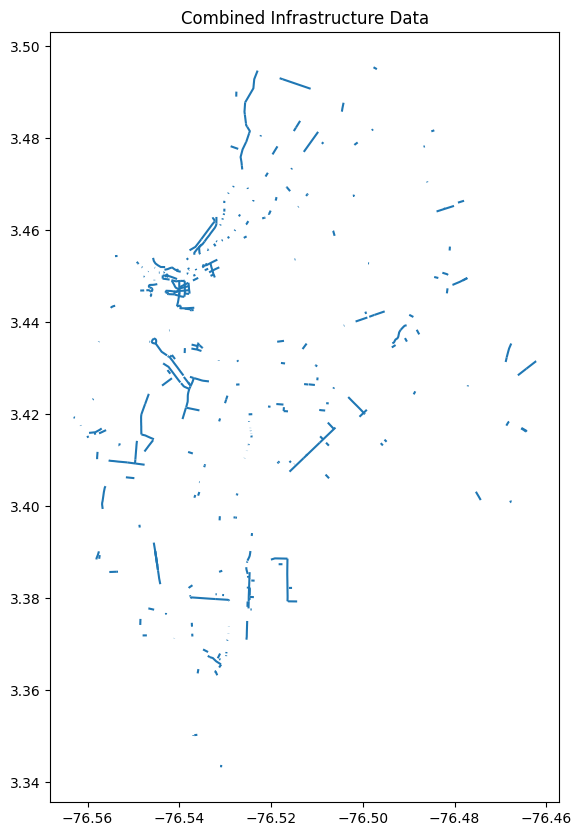

In [87]:
import matplotlib.pyplot as plt

# Plot the combined geodataframe
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
gdf_combined.plot(ax=ax)

# Add a title
ax.set_title("Combined Infrastructure Data")

# Display the plot
plt.show()

## **ANALIZAR DATA DE EXCEL**

In [88]:
# Cargar el archivo Excel desde Google Drive
print("="*60)
print("CARGANDO: Reporte Inicial Vías")
print("="*60)

df = load_excel_from_drive(
    drive_service,
    SHAPES_FOLDER_ID,
    "15-10-2025 - REPORTE INICIAL VIAS.xlsx"
)

# Display the first few rows of the dataframe
display(df.head())

CARGANDO: Reporte Inicial Vías

📥 Descargando archivo Excel: 15-10-2025 - REPORTE INICIAL VIAS.xlsx
  Descargando 15-10-2025 - REPORTE INICIAL VIAS.xlsx: 100%
✅ Excel cargado: 499 registros


,Id,FID,Dirección,Barrio,Comuna,Tipo Infraestructura,Tipo Intervención,Tipo Mezcla,Tipo Grupo,Longitud,...,X_INICIAL,Y_INICIAL,X_FINAL,Y_FINAL,% AVANCE,ESTADO,BP,Nompre BP,BPIN,VALOR INTERVENCIÓN
0,1,0,CALLE 44 BIS ENTRE CARRERAS 6 Y 7,LA ESMERALDA,COMUNA 4,VIA LOCAL,RECARPETEO,MEZCLA CALIENTE,GRUPO OPERATIVO,121,...,-77,3,-77,3,1,FINALIZADO,BP26004834,Conservación del estado de la malla vial de Sa...,2023760010185,91233179
1,2,1,CARRERA 7A BIS ENTRE CALLES 82 Y 84,ALFONSO LOPEZ P. 1A ETAPA,COMUNA 7,VIA LOCAL,RECARPETEO,MEZCLA CALIENTE,GRUPO OPERATIVO,147,...,-76,3,-76,3,1,FINALIZADO,BP26004834,Conservación del estado de la malla vial de Sa...,2023760010185,110837003
2,4,2,CALLE 38N ENTRE CARRERAS 5N Y 7N,UNIDAD RESIDENCIAL BUENO MADRID,COMUNA 4,VIA LOCAL,RECARPETEO,MEZCLA CALIENTE,GRUPO OPERATIVO,128,...,-77,3,-77,3,1,FINALIZADO,BP26004834,Conservación del estado de la malla vial de Sa...,2023760010185,96511132
3,5,3,CARRERA 41 ENTRE CALLES 41C Y 42,ANTONIO NARIÑO,COMUNA 16,VIA LOCAL,RECARPETEO,MEZCLA CALIENTE,GRUPO OPERATIVO,91,...,-77,3,-77,3,1,FINALIZADO,BP26004239,Rehabilitación de vías en la zona urbana y rur...,2022760010012,68613383
4,6,4,AVENIDA 5 OESTE,TERRON COLORADO,COMUNA 1,VIA COLECTORA,RECARPETEO,MEZCLA CALIENTE,GRUPO OPERATIVO,8,...,-77,3,-77,3,1,FINALIZADO,BP26004834,Conservación del estado de la malla vial de Sa...,2023760010185,5730348


In [89]:
df.columns

Index(['Id', 'FID', 'Dirección', 'Barrio', 'Comuna', 'Tipo Infraestructura',
       'Tipo Intervención', 'Tipo Mezcla', 'Tipo Grupo', 'Longitud', 'Año',
       'X_INICIAL', 'Y_INICIAL', 'X_FINAL', 'Y_FINAL', '% AVANCE', 'ESTADO',
       'BP', 'Nompre BP', 'BPIN', 'VALOR INTERVENCIÓN'],
      dtype='object')

### **Análisis de Completitud**

In [90]:
# Calculate the percentage of missing values for each column
completeness_report = df.isnull().sum() / len(df) * 100

# Display the completeness report
print("Completeness Report (% of missing values):")
display(completeness_report)

Completeness Report (% of missing values):


Id                     0
FID                    0
Dirección              0
Barrio                 0
Comuna                 0
Tipo Infraestructura   0
Tipo Intervención      0
Tipo Mezcla            0
Tipo Grupo             0
Longitud               0
Año                    0
X_INICIAL              0
Y_INICIAL              0
X_FINAL                0
Y_FINAL                0
% AVANCE               0
ESTADO                 0
BP                     0
Nompre BP              0
BPIN                   0
VALOR INTERVENCIÓN     0
dtype: float64

In [91]:
df.shape

(499, 21)

In [92]:
gdf_combined.columns


Index(['FID', 'referencia_proceso', 'referencia_contrato', 'bpin',
       'identificador', 'tipo_equipamiento', 'fuente_financiacion',
       'nombre_up', 'nombre_up_detalle', 'comuna_corregimiento', 'clase_obra',
       'unidad', 'cantidad', 'direccion', 'barrio_vereda', 'tipo_intervencion',
       'estado', 'presupuesto_base', 'avance_obra', 'ano', 'fecha_inicio',
       'fecha_fin', 'plataforma', 'url_proceso', 'descripcion_intervencion',
       'nombre_centro_gestor', 'geometry'],
      dtype='object')

### **Análisis de valores ceros o nulos**

In [93]:
# Calculate the number of null/NaN values per column
null_counts = df.isnull().sum()

# Calculate the number of zero values per column
zero_counts = (df == 0).sum()

# Combine the reports
combined_report = pd.DataFrame({
    'Null/NaN Count': null_counts,
    'Zero Count': zero_counts
})

print("Reporte de valores Nulos, NaN o Cero:")
display(combined_report)

Reporte de valores Nulos, NaN o Cero:


,Null/NaN Count,Zero Count
Id,0,2
FID,0,4
Dirección,0,0
Barrio,1,0
Comuna,0,0
Tipo Infraestructura,0,0
Tipo Intervención,0,0
Tipo Mezcla,0,0
Tipo Grupo,0,0
Longitud,0,0


In [94]:
# Análisis de duplicados y corrección cruzando con el Excel

# 1. Analizar duplicados en el GeoDataFrame combinado
print("="*80)
print("ANÁLISIS DE DUPLICADOS EN gdf_combined")
print("="*80)

# Verificar duplicados por nombre_up
duplicados_nombre = gdf_combined[gdf_combined.duplicated(subset=['nombre_up'], keep=False)].sort_values('nombre_up')
print(f"\n1. Registros con nombre_up duplicado: {len(duplicados_nombre)}")
if len(duplicados_nombre) > 0:
    print("\nPrimeros 10 duplicados por nombre_up:")
    display(duplicados_nombre[['FID', 'nombre_up', 'presupuesto_base', 'identificador', 'ano']].head(10))

# Verificar duplicados por presupuesto_base (excluyendo ceros)
duplicados_presupuesto = gdf_combined[(gdf_combined['presupuesto_base'] > 0) & 
                                       gdf_combined.duplicated(subset=['presupuesto_base'], keep=False)].sort_values('presupuesto_base')
print(f"\n2. Registros con presupuesto_base duplicado (>0): {len(duplicados_presupuesto)}")
if len(duplicados_presupuesto) > 0:
    print("\nPrimeros 10 duplicados por presupuesto_base:")
    display(duplicados_presupuesto[['FID', 'nombre_up', 'direccion', 'presupuesto_base', 'identificador']].head(10))

# 2. Preparar datos del Excel para cruce
print("\n" + "="*80)
print("PREPARACIÓN DE DATOS DEL EXCEL")
print("="*80)

# Normalizar columnas del Excel para cruce
df_excel = df.copy()
df_excel['direccion_normalizada'] = df_excel['Dirección'].str.upper().str.strip()
df_excel['valor_intervencion'] = df_excel['VALOR INTERVENCIÓN'].astype(float)

print(f"\nTotal registros en Excel: {len(df_excel)}")
print(f"Sumatoria VALOR INTERVENCIÓN en Excel: ${df_excel['valor_intervencion'].sum():,.2f}")

# 3. Normalizar direcciones en gdf_combined para cruce
gdf_combined['direccion_normalizada'] = gdf_combined['direccion'].str.upper().str.strip()
gdf_combined['nombre_up_normalizado'] = gdf_combined['nombre_up'].str.upper().str.strip()

# 4. Intentar cruzar datos
print("\n" + "="*80)
print("CRUCE DE DATOS: gdf_combined vs Excel")
print("="*80)

# Crear copia para corrección
gdf_corrected = gdf_combined.copy()

# Intentar match por dirección
matches = 0
corrections = 0

for idx, row in gdf_corrected.iterrows():
    if pd.notna(row['direccion_normalizada']):
        # Buscar en Excel
        match = df_excel[df_excel['direccion_normalizada'] == row['direccion_normalizada']]
        
        if len(match) > 0:
            matches += 1
            valor_excel = match.iloc[0]['valor_intervencion']
            valor_actual = row['presupuesto_base']
            
            # Si hay diferencia, corregir
            if abs(valor_excel - valor_actual) > 1:  # tolerancia de 1 peso
                gdf_corrected.at[idx, 'presupuesto_base'] = int(valor_excel)
                corrections += 1

print(f"\nRegistros con match por dirección: {matches}")
print(f"Correcciones realizadas: {corrections}")

# 5. COMPARATIVA DE SUMATORIAS
print("\n" + "="*80)
print("COMPARATIVA DE SUMATORIAS")
print("="*80)

# Sumatoria original
suma_original = gdf_combined['presupuesto_base'].sum()
print(f"\n1. Sumatoria ORIGINAL (gdf_combined):")
print(f"   ${suma_original:,.2f}")

# Sumatoria después de corrección
suma_corregida = gdf_corrected['presupuesto_base'].sum()
print(f"\n2. Sumatoria CORREGIDA (después del cruce):")
print(f"   ${suma_corregida:,.2f}")

# Sumatoria del Excel
suma_excel = df_excel['valor_intervencion'].sum()
print(f"\n3. Sumatoria EXCEL (VALOR INTERVENCIÓN):")
print(f"   ${suma_excel:,.2f}")

# Diferencias
diferencia_original = suma_original - suma_excel
diferencia_corregida = suma_corregida - suma_excel

print(f"\n4. DIFERENCIAS:")
print(f"   Original vs Excel: ${diferencia_original:,.2f} ({(diferencia_original/suma_excel)*100:.2f}%)")
print(f"   Corregida vs Excel: ${diferencia_corregida:,.2f} ({(diferencia_corregida/suma_excel)*100:.2f}%)")

# 6. Análisis de registros no coincidentes
print("\n" + "="*80)
print("ANÁLISIS DE REGISTROS NO COINCIDENTES")
print("="*80)

# Registros en gdf_combined pero no en Excel
registros_solo_gdf = gdf_corrected[~gdf_corrected['direccion_normalizada'].isin(df_excel['direccion_normalizada'])]
print(f"\nRegistros solo en GeoDataFrame: {len(registros_solo_gdf)}")
print(f"Presupuesto acumulado: ${registros_solo_gdf['presupuesto_base'].sum():,.2f}")

# Mostrar algunos ejemplos
if len(registros_solo_gdf) > 0:
    print("\nEjemplos de registros solo en GeoDataFrame:")
    display(registros_solo_gdf[['FID', 'nombre_up', 'direccion', 'presupuesto_base', 'identificador', 'ano']].head(10))

# Registros en Excel pero no en gdf
direcciones_gdf = set(gdf_corrected['direccion_normalizada'].dropna())
registros_solo_excel = df_excel[~df_excel['direccion_normalizada'].isin(direcciones_gdf)]
print(f"\nRegistros solo en Excel: {len(registros_solo_excel)}")
print(f"Valor acumulado: ${registros_solo_excel['valor_intervencion'].sum():,.2f}")

# 7. Resumen final
print("\n" + "="*80)
print("RESUMEN FINAL")
print("="*80)

resumen = pd.DataFrame({
    'Fuente': ['GeoDataFrame Original', 'GeoDataFrame Corregido', 'Excel'],
    'Cantidad Registros': [len(gdf_combined), len(gdf_corrected), len(df_excel)],
    'Sumatoria Presupuesto': [suma_original, suma_corregida, suma_excel],
    'Diferencia vs Excel': [diferencia_original, diferencia_corregida, 0]
})

display(resumen)

# Actualizar gdf_combined con los valores corregidos
if corrections > 0:
    print(f"\n✓ Se actualizó gdf_combined con {corrections} correcciones")
    gdf_combined = gdf_corrected.copy()

ANÁLISIS DE DUPLICADOS EN gdf_combined

1. Registros con nombre_up duplicado: 205

Primeros 10 duplicados por nombre_up:


,FID,nombre_up,presupuesto_base,identificador,ano
313,32,Area Parque Loma De La Cruz Calle 2 Entre Carr...,5132273,Puntos Estrategicos,2024
314,32,Area Parque Loma De La Cruz Calle 2 Entre Carr...,5132273,Puntos Estrategicos,2024
320,37,Area Parque Loma De La Cruz Carrera 16 Entre C...,52097562,Puntos Estrategicos,2024
321,37,Area Parque Loma De La Cruz Carrera 16 Entre C...,52097562,Puntos Estrategicos,2024
186,174,Autopista Suroriental Entre Calle 25 Y 44,31483884,Grupo Operativo,2024
185,174,Autopista Suroriental Entre Calle 25 Y 44,31483884,Grupo Operativo,2024
189,178,Autopista Suroriental Entre Calle 44 Y 52,10653243,Grupo Operativo,2024
190,178,Autopista Suroriental Entre Calle 44 Y 52,10653243,Grupo Operativo,2024
194,180,Autopista Suroriental Entre Calle 52 Y 58,29260907,Grupo Operativo,2024
193,180,Autopista Suroriental Entre Calle 52 Y 58,29260907,Grupo Operativo,2024



2. Registros con presupuesto_base duplicado (>0): 229

Primeros 10 duplicados por presupuesto_base:


,FID,nombre_up,direccion,presupuesto_base,identificador
95,87,Calle 25 Entre Carrera 83B Y 83C,Calle 25 Entre Carrera 83B Y 83C,710216,Grupo Operativo
110,104,Carrera 4 Oeste Entre Calle 1 Y 2A,Carrera 4 Oeste Entre Calle 1 Y 2A,710216,Grupo Operativo
65,49,Calle 5 Oe Entre Avenidas 3 Oe Y 4 Oe,Calle 5 Oe Entre Avenidas 3 Oe Y 4 Oe,710216,Grupo Operativo
17,14,Carrera 1 Con Calle 35,Carrera 1 Con Calle 35,3769966,Grupo Operativo
83,70,Calle 39A Con Carrera 43B,Calle 39A Con Carrera 43B,3769966,Grupo Operativo
16,14,Carrera 1 Con Calle 35,Carrera 1 Con Calle 35,3769966,Grupo Operativo
72,58,Carrera 8N Entre Calles 51 Y 51B,Carrera 8N Entre Calles 51 Y 51B,4261297,Grupo Operativo
147,139,Avenida 3 Norte Con Calle 20N,Avenida 3 Norte Con Calle 20N,4261297,Grupo Operativo
313,32,Area Parque Loma De La Cruz Calle 2 Entre Carr...,Area Parque Loma De La Cruz Calle 2 Entre Carr...,5132273,Puntos Estrategicos
314,32,Area Parque Loma De La Cruz Calle 2 Entre Carr...,Area Parque Loma De La Cruz Calle 2 Entre Carr...,5132273,Puntos Estrategicos



PREPARACIÓN DE DATOS DEL EXCEL

Total registros en Excel: 499
Sumatoria VALOR INTERVENCIÓN en Excel: $88,405,372,888.39

CRUCE DE DATOS: gdf_combined vs Excel

Registros con match por dirección: 353
Correcciones realizadas: 0

COMPARATIVA DE SUMATORIAS

1. Sumatoria ORIGINAL (gdf_combined):
   $100,147,305,863.22

2. Sumatoria CORREGIDA (después del cruce):
   $100,147,305,863.22

3. Sumatoria EXCEL (VALOR INTERVENCIÓN):
   $88,405,372,888.39

4. DIFERENCIAS:
   Original vs Excel: $11,741,932,974.83 (13.28%)
   Corregida vs Excel: $11,741,932,974.83 (13.28%)

ANÁLISIS DE REGISTROS NO COINCIDENTES

Registros solo en GeoDataFrame: 16
Presupuesto acumulado: $1,604,605,552.00

Ejemplos de registros solo en GeoDataFrame:


,FID,nombre_up,direccion,presupuesto_base,identificador,ano
265,0,Carrera 33 A Entre Calle 36 Y Calle 44 (Diagon...,None,0,None,0
313,32,Area Parque Loma De La Cruz Calle 2 Entre Carr...,Area Parque Loma De La Cruz Calle 2 Entre Carr...,5132273,Puntos Estrategicos,2024
314,32,Area Parque Loma De La Cruz Calle 2 Entre Carr...,Area Parque Loma De La Cruz Calle 2 Entre Carr...,5132273,Puntos Estrategicos,2024
315,33,Area Parque Loma De La Cruz Calle 2A Entre Car...,Area Parque Loma De La Cruz Calle 2A Entre Car...,3292637,Puntos Estrategicos,2024
316,34,Area Parque Loma De La Cruz Carrera 14 Entre C...,Area Parque Loma De La Cruz Carrera 14 Entre C...,14915084,Puntos Estrategicos,2024
317,35,Area Parque Loma De La Cruz Carrera 16 Entre C...,Area Parque Loma De La Cruz Carrera 16 Entre C...,23614381,Puntos Estrategicos,2024
320,37,Area Parque Loma De La Cruz Carrera 16 Entre C...,Area Parque Loma De La Cruz Carrera 16 Entre C...,52097562,Puntos Estrategicos,2024
321,37,Area Parque Loma De La Cruz Carrera 16 Entre C...,Area Parque Loma De La Cruz Carrera 16 Entre C...,52097562,Puntos Estrategicos,2024
324,40,Carrera 9 Entre Calles 2 Hasta Calle 4,Carrera 9 Entre Calles 2 Hasta Calle 4,294653600,Puntos Estrategicos,2024
337,52,Calle 3 Oeste Entre Carrera 3 Hasta Carrera 4,Calle 3 Oeste Entre Carrera 3 Hasta Carrera 4,59242522,Puntos Estrategicos,2024



Registros solo en Excel: 266
Valor acumulado: $35,984,975,883.42

RESUMEN FINAL


,Fuente,Cantidad Registros,Sumatoria Presupuesto,Diferencia vs Excel
0,GeoDataFrame Original,369,100147305863,11741932975
1,GeoDataFrame Corregido,369,100147305863,11741932975
2,Excel,499,88405372888,0


In [95]:
import re
import pandas as pd
from difflib import SequenceMatcher

def normalizar_direccion_avanzado(texto):
    """Normaliza direcciones de forma más agresiva para mejorar el matching"""
    if pd.isna(texto) or texto is None:
        return None
    
    texto = str(texto).upper().strip()
    
    # Reemplazos comunes
    reemplazos = {
        'CARRERA': 'CR',
        'CALLE': 'CL',
        'AVENIDA': 'AV',
        'DIAGONAL': 'DG',
        'TRANSVERSAL': 'TV',
        ' BIS': 'BIS',
        ' ESTE': 'E',
        ' OESTE': 'O',
        ' NORTE': 'N',
        ' SUR': 'S',
        'ENTRE': '',
        'HASTA': '',
        'Y': '',
        'CON': ''
    }
    
    for old, new in reemplazos.items():
        texto = texto.replace(old, new)
    
    # Eliminar caracteres especiales y espacios múltiples
    texto = re.sub(r'[^\w\s]', '', texto)
    texto = re.sub(r'\s+', '', texto)
    
    return texto

def similarity_ratio(str1, str2):
    """Calcula la similitud entre dos strings"""
    if str1 is None or str2 is None:
        return 0
    return SequenceMatcher(None, str1, str2).ratio()

print("="*80)
print("CRUCE DE DATOS: GEODATAFRAME vs EXCEL (MEJORADO)")
print("="*80)

# 1. Preparar datos normalizados
print("\n1. Normalizando direcciones y nombres...")
gdf_combined['dir_norm'] = gdf_combined['direccion'].apply(normalizar_direccion_avanzado)
gdf_combined['nombre_norm'] = gdf_combined['nombre_up'].apply(normalizar_direccion_avanzado)
df_excel['dir_norm'] = df_excel['Dirección'].apply(normalizar_direccion_avanzado)

# 2. Crear DataFrame de correcciones
correcciones_realizadas = []
gdf_final = gdf_combined.copy()

print("\n2. Buscando coincidencias (múltiples estrategias)...")
matches_exactos_dir = 0
matches_exactos_nombre = 0
matches_similares = 0
matches_barrio_comuna = 0
sin_match = 0

for idx, row in gdf_final.iterrows():
    dir_gdf = row['dir_norm']
    nombre_gdf = row['nombre_norm']
    presupuesto_actual = row['presupuesto_base']
    barrio_gdf = row.get('barrio_vereda')
    comuna_gdf = row.get('comuna_corregimiento')
    
    # ESTRATEGIA 1: Match exacto por dirección normalizada
    if pd.notna(dir_gdf):
        match_exacto = df_excel[df_excel['dir_norm'] == dir_gdf]
        
        if len(match_exacto) > 0:
            matches_exactos_dir += 1
            valor_excel = match_exacto.iloc[0]['valor_intervencion']
            
            if abs(valor_excel - presupuesto_actual) > 1:
                gdf_final.at[idx, 'presupuesto_base'] = int(valor_excel)
                correcciones_realizadas.append({
                    'FID': row['FID'],
                    'direccion': row['direccion'],
                    'nombre_up': row['nombre_up'],
                    'valor_anterior': presupuesto_actual,
                    'valor_nuevo': int(valor_excel),
                    'tipo_match': 'Exacto dirección'
                })
            continue
    
    # ESTRATEGIA 2: Match exacto por nombre_up normalizado
    if pd.notna(nombre_gdf):
        match_nombre = df_excel[df_excel['dir_norm'] == nombre_gdf]
        
        if len(match_nombre) > 0:
            matches_exactos_nombre += 1
            valor_excel = match_nombre.iloc[0]['valor_intervencion']
            
            if abs(valor_excel - presupuesto_actual) > 1:
                gdf_final.at[idx, 'presupuesto_base'] = int(valor_excel)
                correcciones_realizadas.append({
                    'FID': row['FID'],
                    'direccion': row['direccion'],
                    'nombre_up': row['nombre_up'],
                    'valor_anterior': presupuesto_actual,
                    'valor_nuevo': int(valor_excel),
                    'tipo_match': 'Exacto nombre_up'
                })
            continue
    
    # ESTRATEGIA 3: Match por similitud (>85%) en dirección o nombre
    mejores_matches = []
    for idx_excel, row_excel in df_excel.iterrows():
        dir_excel = row_excel['dir_norm']
        
        max_sim = 0
        if pd.notna(dir_excel):
            if pd.notna(dir_gdf):
                max_sim = max(max_sim, similarity_ratio(dir_gdf, dir_excel))
            if pd.notna(nombre_gdf):
                max_sim = max(max_sim, similarity_ratio(nombre_gdf, dir_excel))
        
        if max_sim > 0.85:
            mejores_matches.append({
                'idx': idx_excel,
                'similitud': max_sim,
                'valor': row_excel['valor_intervencion']
            })
    
    if mejores_matches:
        mejor_match = max(mejores_matches, key=lambda x: x['similitud'])
        matches_similares += 1
        valor_excel = mejor_match['valor']
        
        if abs(valor_excel - presupuesto_actual) > 1:
            gdf_final.at[idx, 'presupuesto_base'] = int(valor_excel)
            correcciones_realizadas.append({
                'FID': row['FID'],
                'direccion': row['direccion'],
                'nombre_up': row['nombre_up'],
                'valor_anterior': presupuesto_actual,
                'valor_nuevo': int(valor_excel),
                'tipo_match': f"Similar ({mejor_match['similitud']:.2%})"
            })
        continue
    
    # ESTRATEGIA 4: Match por Barrio + Comuna (para casos sin dirección)
    if pd.notna(barrio_gdf) and pd.notna(comuna_gdf):
        match_barrio = df_excel[
            (df_excel['Barrio'].str.upper() == str(barrio_gdf).upper()) &
            (df_excel['Comuna'].str.upper() == str(comuna_gdf).upper())
        ]
        
        if len(match_barrio) == 1:  # Solo si hay 1 match único
            matches_barrio_comuna += 1
            valor_excel = match_barrio.iloc[0]['valor_intervencion']
            
            if abs(valor_excel - presupuesto_actual) > 1:
                gdf_final.at[idx, 'presupuesto_base'] = int(valor_excel)
                correcciones_realizadas.append({
                    'FID': row['FID'],
                    'direccion': row['direccion'],
                    'nombre_up': row['nombre_up'],
                    'valor_anterior': presupuesto_actual,
                    'valor_nuevo': int(valor_excel),
                    'tipo_match': 'Barrio+Comuna'
                })
            continue
    
    sin_match += 1

print(f"\n   ✓ Matches exactos por dirección: {matches_exactos_dir}")
print(f"   ✓ Matches exactos por nombre_up: {matches_exactos_nombre}")
print(f"   ✓ Matches por similitud: {matches_similares}")
print(f"   ✓ Matches por Barrio+Comuna: {matches_barrio_comuna}")
print(f"   ✗ Sin match: {sin_match}")

# 3. Mostrar correcciones realizadas
print(f"\n3. Correcciones realizadas: {len(correcciones_realizadas)}")
if correcciones_realizadas:
    df_correcciones = pd.DataFrame(correcciones_realizadas)
    df_correcciones['diferencia'] = df_correcciones['valor_nuevo'] - df_correcciones['valor_anterior']
    print("\nPrimeras 20 correcciones:")
    display(df_correcciones.head(20))
    
    print(f"\nTotal diferencia acumulada: ${df_correcciones['diferencia'].sum():,.2f}")
    
    # Resumen por tipo de match
    print("\nResumen por tipo de match:")
    display(df_correcciones.groupby('tipo_match').agg({
        'FID': 'count',
        'diferencia': 'sum'
    }).rename(columns={'FID': 'Cantidad', 'diferencia': 'Diferencia Total'}))

# 4. Comparativa final
print("\n" + "="*80)
print("COMPARATIVA FINAL")
print("="*80)

suma_original = gdf_combined['presupuesto_base'].sum()
suma_corregida = gdf_final['presupuesto_base'].sum()
suma_excel = df_excel['valor_intervencion'].sum()

resumen_final = pd.DataFrame({
    'Fuente': ['GeoDataFrame Original', 'GeoDataFrame Corregido', 'Excel'],
    'Cantidad Registros': [len(gdf_combined), len(gdf_final), len(df_excel)],
    'Sumatoria Presupuesto': [suma_original, suma_corregida, suma_excel],
    'Diferencia vs Excel ($)': [
        suma_original - suma_excel,
        suma_corregida - suma_excel,
        0
    ],
    'Diferencia vs Excel (%)': [
        ((suma_original - suma_excel) / suma_excel * 100),
        ((suma_corregida - suma_excel) / suma_excel * 100),
        0
    ]
})

display(resumen_final)

# 5. Actualizar geodataframes
print("\n5. Actualizando geodataframes...")
gdf_combined = gdf_final.copy()
gdf_corrected = gdf_final.copy()

# Limpiar columnas auxiliares
columnas_limpiar = ['dir_norm', 'nombre_norm']
for col in columnas_limpiar:
    if col in gdf_combined.columns:
        gdf_combined = gdf_combined.drop(columns=[col])
    if col in gdf_corrected.columns:
        gdf_corrected = gdf_corrected.drop(columns=[col])

print("\n✓ Proceso completado")
print(f"✓ Total de correcciones aplicadas: {len(correcciones_realizadas)}")
print(f"✓ Nueva diferencia con Excel: ${suma_corregida - suma_excel:,.2f} ({((suma_corregida - suma_excel) / suma_excel * 100):.2f}%)")

CRUCE DE DATOS: GEODATAFRAME vs EXCEL (MEJORADO)

1. Normalizando direcciones y nombres...

2. Buscando coincidencias (múltiples estrategias)...

   ✓ Matches exactos por dirección: 354
   ✓ Matches exactos por nombre_up: 0
   ✓ Matches por similitud: 1
   ✓ Matches por Barrio+Comuna: 0
   ✗ Sin match: 14

3. Correcciones realizadas: 1

Primeras 20 correcciones:


,FID,direccion,nombre_up,valor_anterior,valor_nuevo,tipo_match,diferencia
0,52,Calle 3 Oeste Entre Carrera 3 Hasta Carrera 4,Calle 3 Oeste Entre Carrera 3 Hasta Carrera 4,59242522,133196882,Similar (85.71%),73954360



Total diferencia acumulada: $73,954,360.00

Resumen por tipo de match:


,Cantidad,Diferencia Total
tipo_match,,
Similar (85.71%),1,73954360



COMPARATIVA FINAL


,Fuente,Cantidad Registros,Sumatoria Presupuesto,Diferencia vs Excel ($),Diferencia vs Excel (%)
0,GeoDataFrame Original,369,100147305863,11741932975,13
1,GeoDataFrame Corregido,369,100221260223,11815887335,13
2,Excel,499,88405372888,0,0



5. Actualizando geodataframes...

✓ Proceso completado
✓ Total de correcciones aplicadas: 1
✓ Nueva diferencia con Excel: $11,815,887,334.83 (13.37%)
